# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Data Analysis

In this jupyter notebook, we will check the data, attributes that are available and make data analysis. Data analysis will be helpful for decision making in further steps.

### Setup and reading the data

At first, we need to import libraries and set initial configs.

In [1]:
import numpy as np
import pandas as pd

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Automatically reload imported modules
%load_ext autoreload
%autoreload 2

In [3]:
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

And now, let's import the dataset:

In [4]:
df = pd.read_csv('../data/dataset.csv')

### Descriptive data analysis

In this section, we will check how the data look like and try to describe them - how many values and attributes are available, what data types are attributes of, etc.

How many of the data are available and how many attributes?

In [5]:
print(f'Number of samples: {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')

Number of samples: 590540
Number of attributes: 434


Quite a lot of samples are available, but more surprising is the number of attributes. Because transactions data has to be anonymized, it will be hard to describe or explain the attributes.

Let's check how the data look like:

In [6]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
df.tail()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Duplicates

Are there any duplicated rows in the dataframe?

In [44]:
df.duplicated().any()

False

#### One-value columns

Let's check columns with only one value. Those attributes are useless and should be dropped.

In [56]:
for col in df.columns:
    if len(df.loc[:, col].dropna().unique()) == 1:
        print(col)

Our data do not contain columns with only one value.

#### Data types

Available attributes are of different data types. What is the distribution of data types across attributes?

In [8]:
df.dtypes.value_counts()

float64    399
object      31
int64        4
dtype: int64

Majority of attributes are floats. In this case, pandas dataframe by default choose `float64` type, but sometimes there are only small numbers in values. We can save a lot of memory when reading dataframe by setting data type as `float16` or `float32` in attributes where `float64` is not needed.

There can be also problem with data type `object`. Sometimes, it is just `float`/`int` but with some string representing for example missing value (e.g. `?`). Let's check, which columns are of type `object`:

In [9]:
df.select_dtypes(include=['object']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

According to dataset source at Kaggle, all of those attributes should be categorical. Except those, also `card1 - card6`, `addr1, addr2` and `id_12 - id_38` should be treated as categorical. This has to be figured out in preprocessing phase.

#### Predicted class distribution

Our task will be to predict whether transaction was fraud or not. This is described by attribute `isFraud`. We need to know the distribution of the values in this attribute:

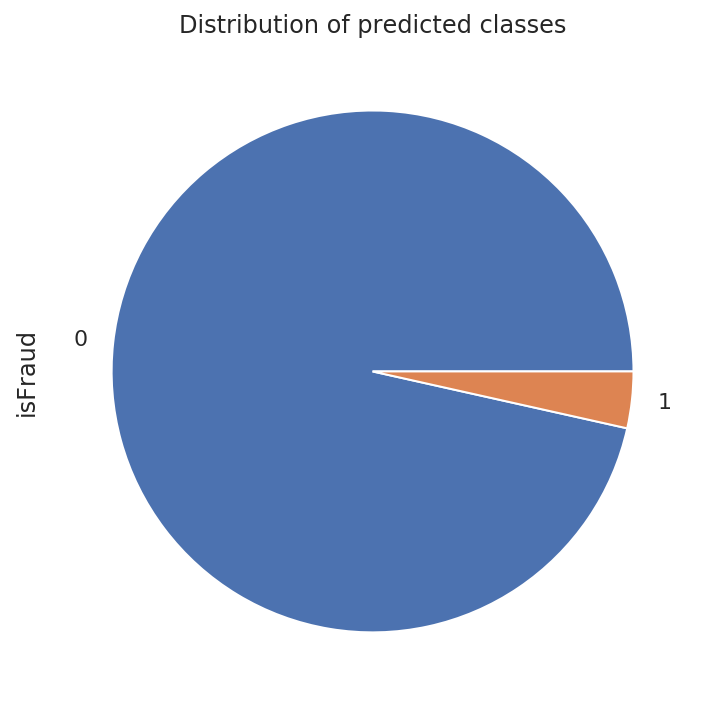

In [10]:
df.isFraud.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [11]:
df.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

As we can see, the classes are heavily imbalanced. Because of that, oversampling or undersampling has to be done to avoid classifier being overfitted to major class.

### Missing values

To know which attributes can be helpful in our prediction, let's check how many values are missing in each attribute.

**Note:** Plots below are showing fraction of the data that are **not** missing (column with value 1 has no missing values).

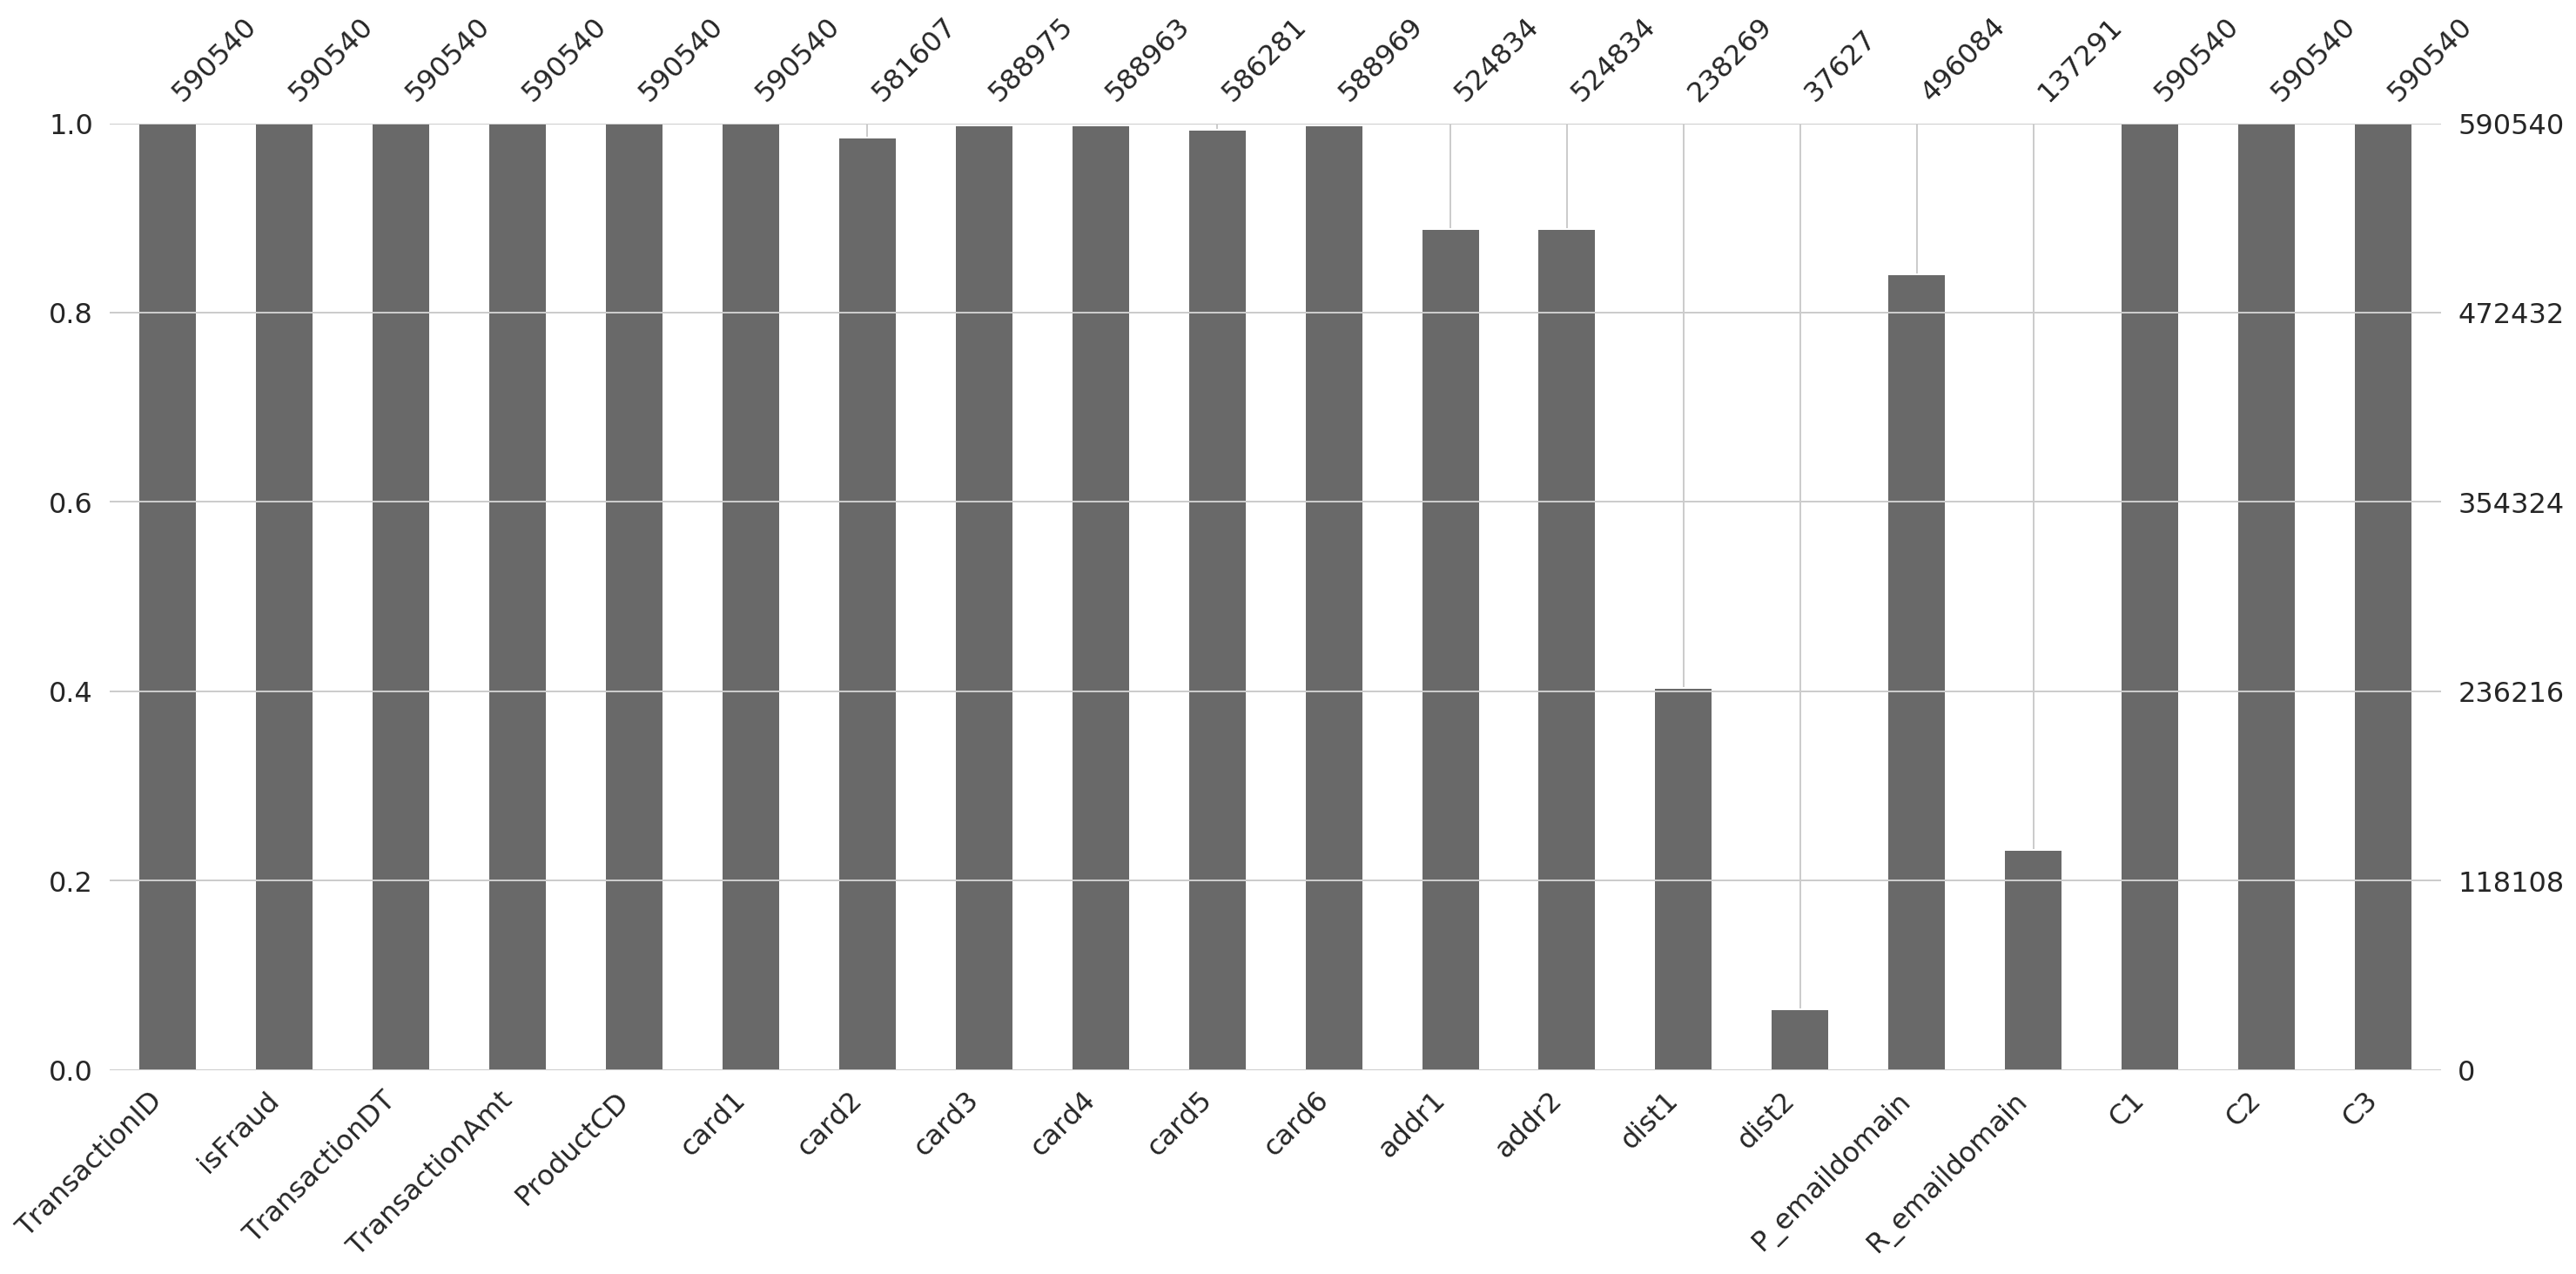

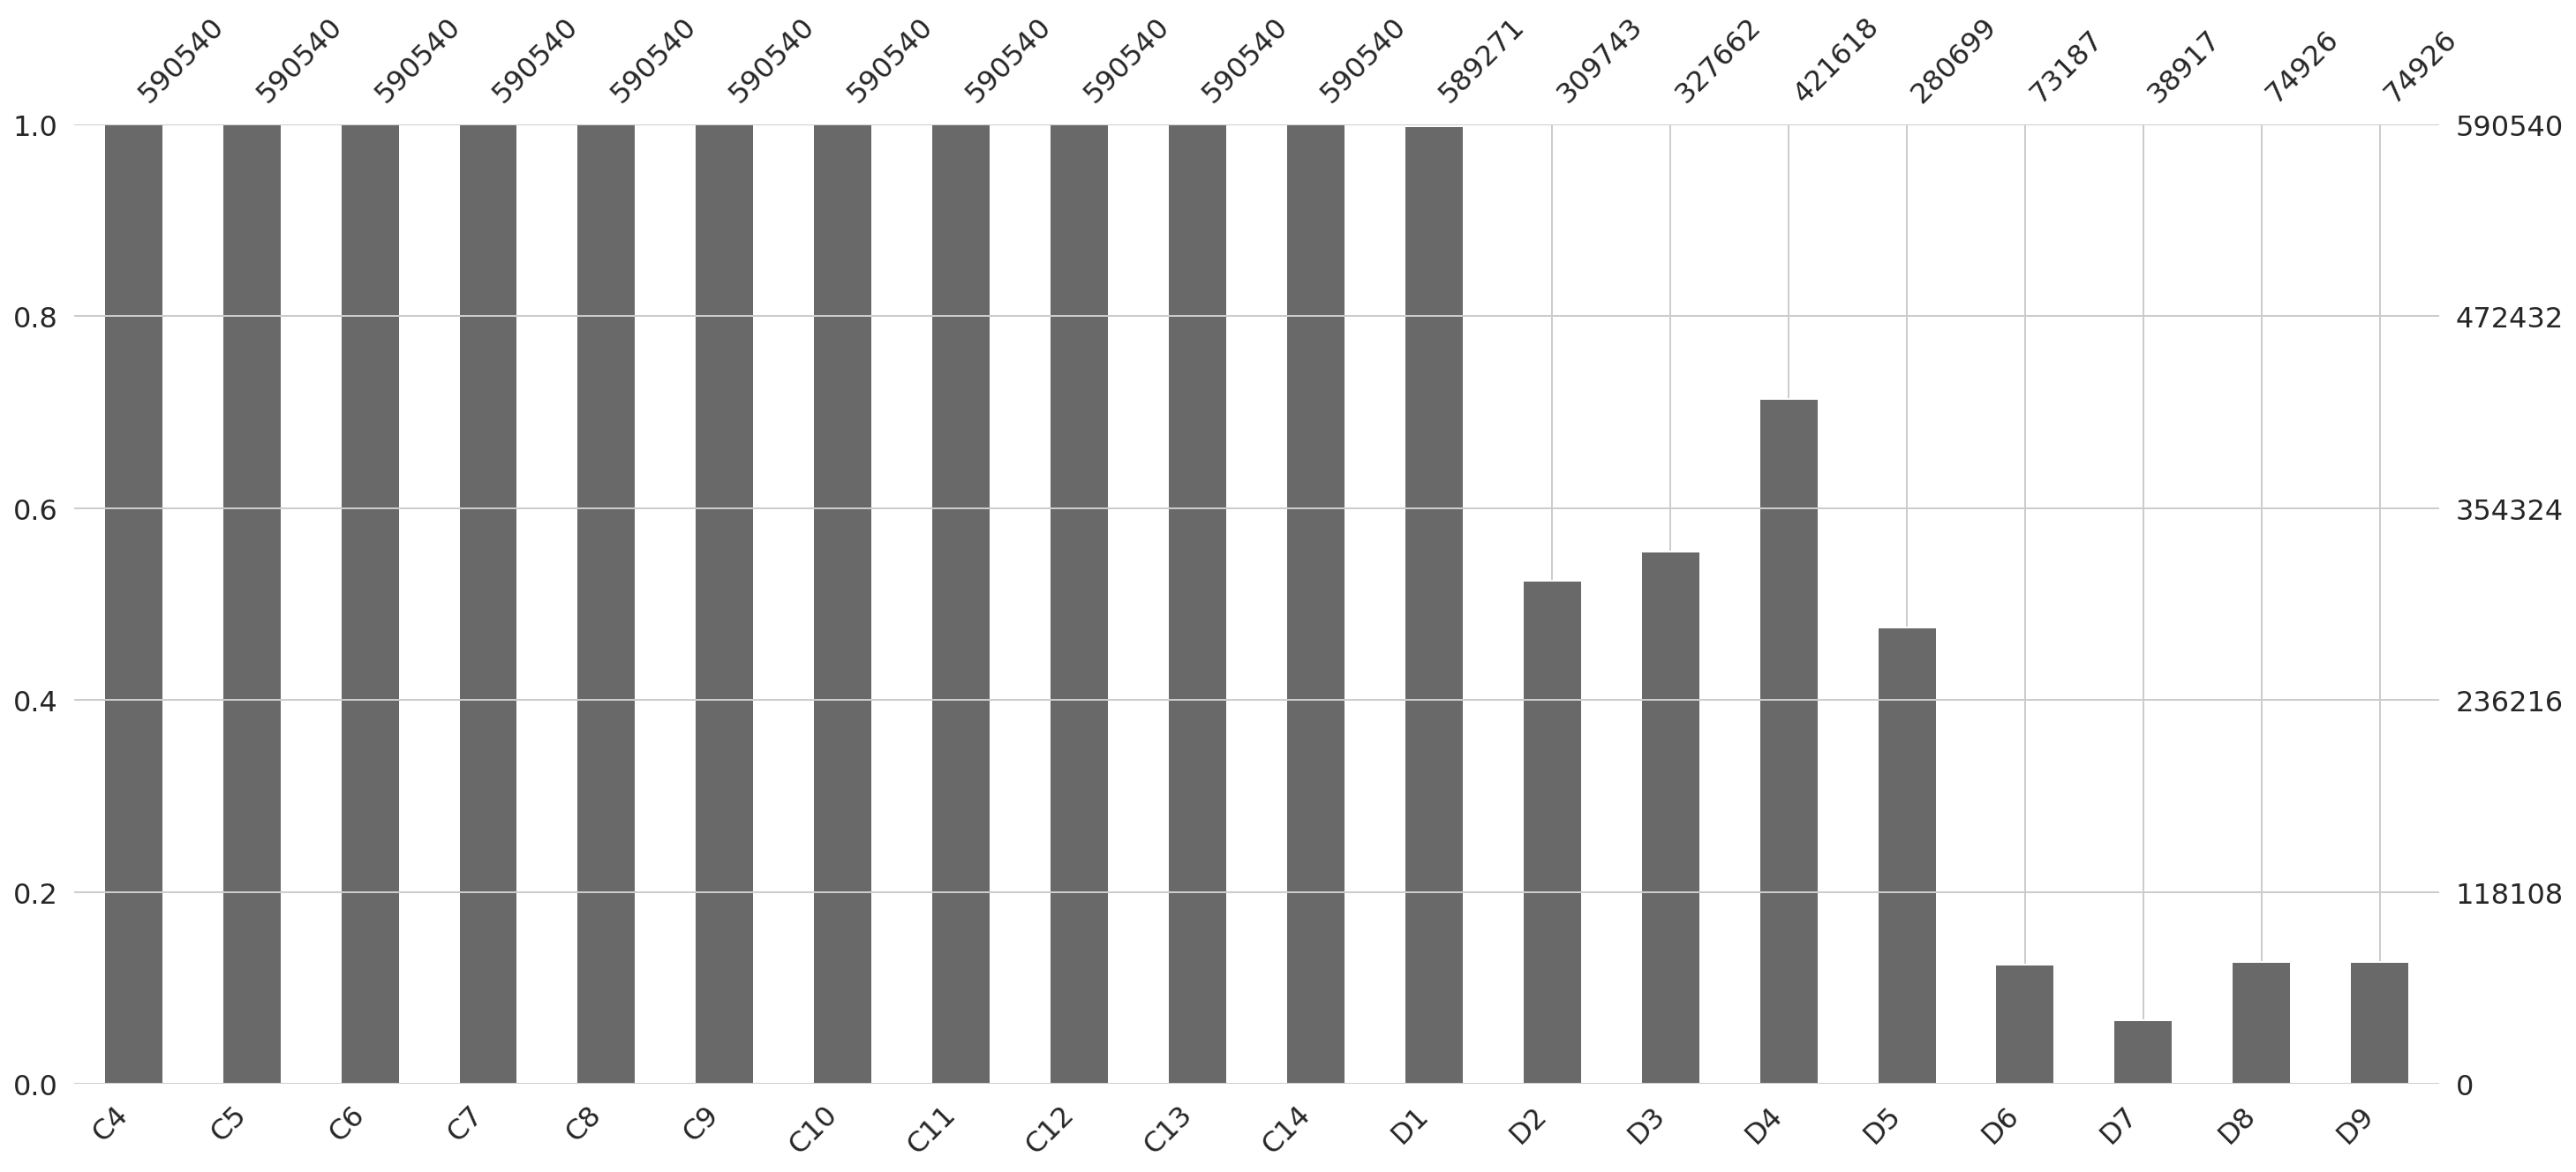

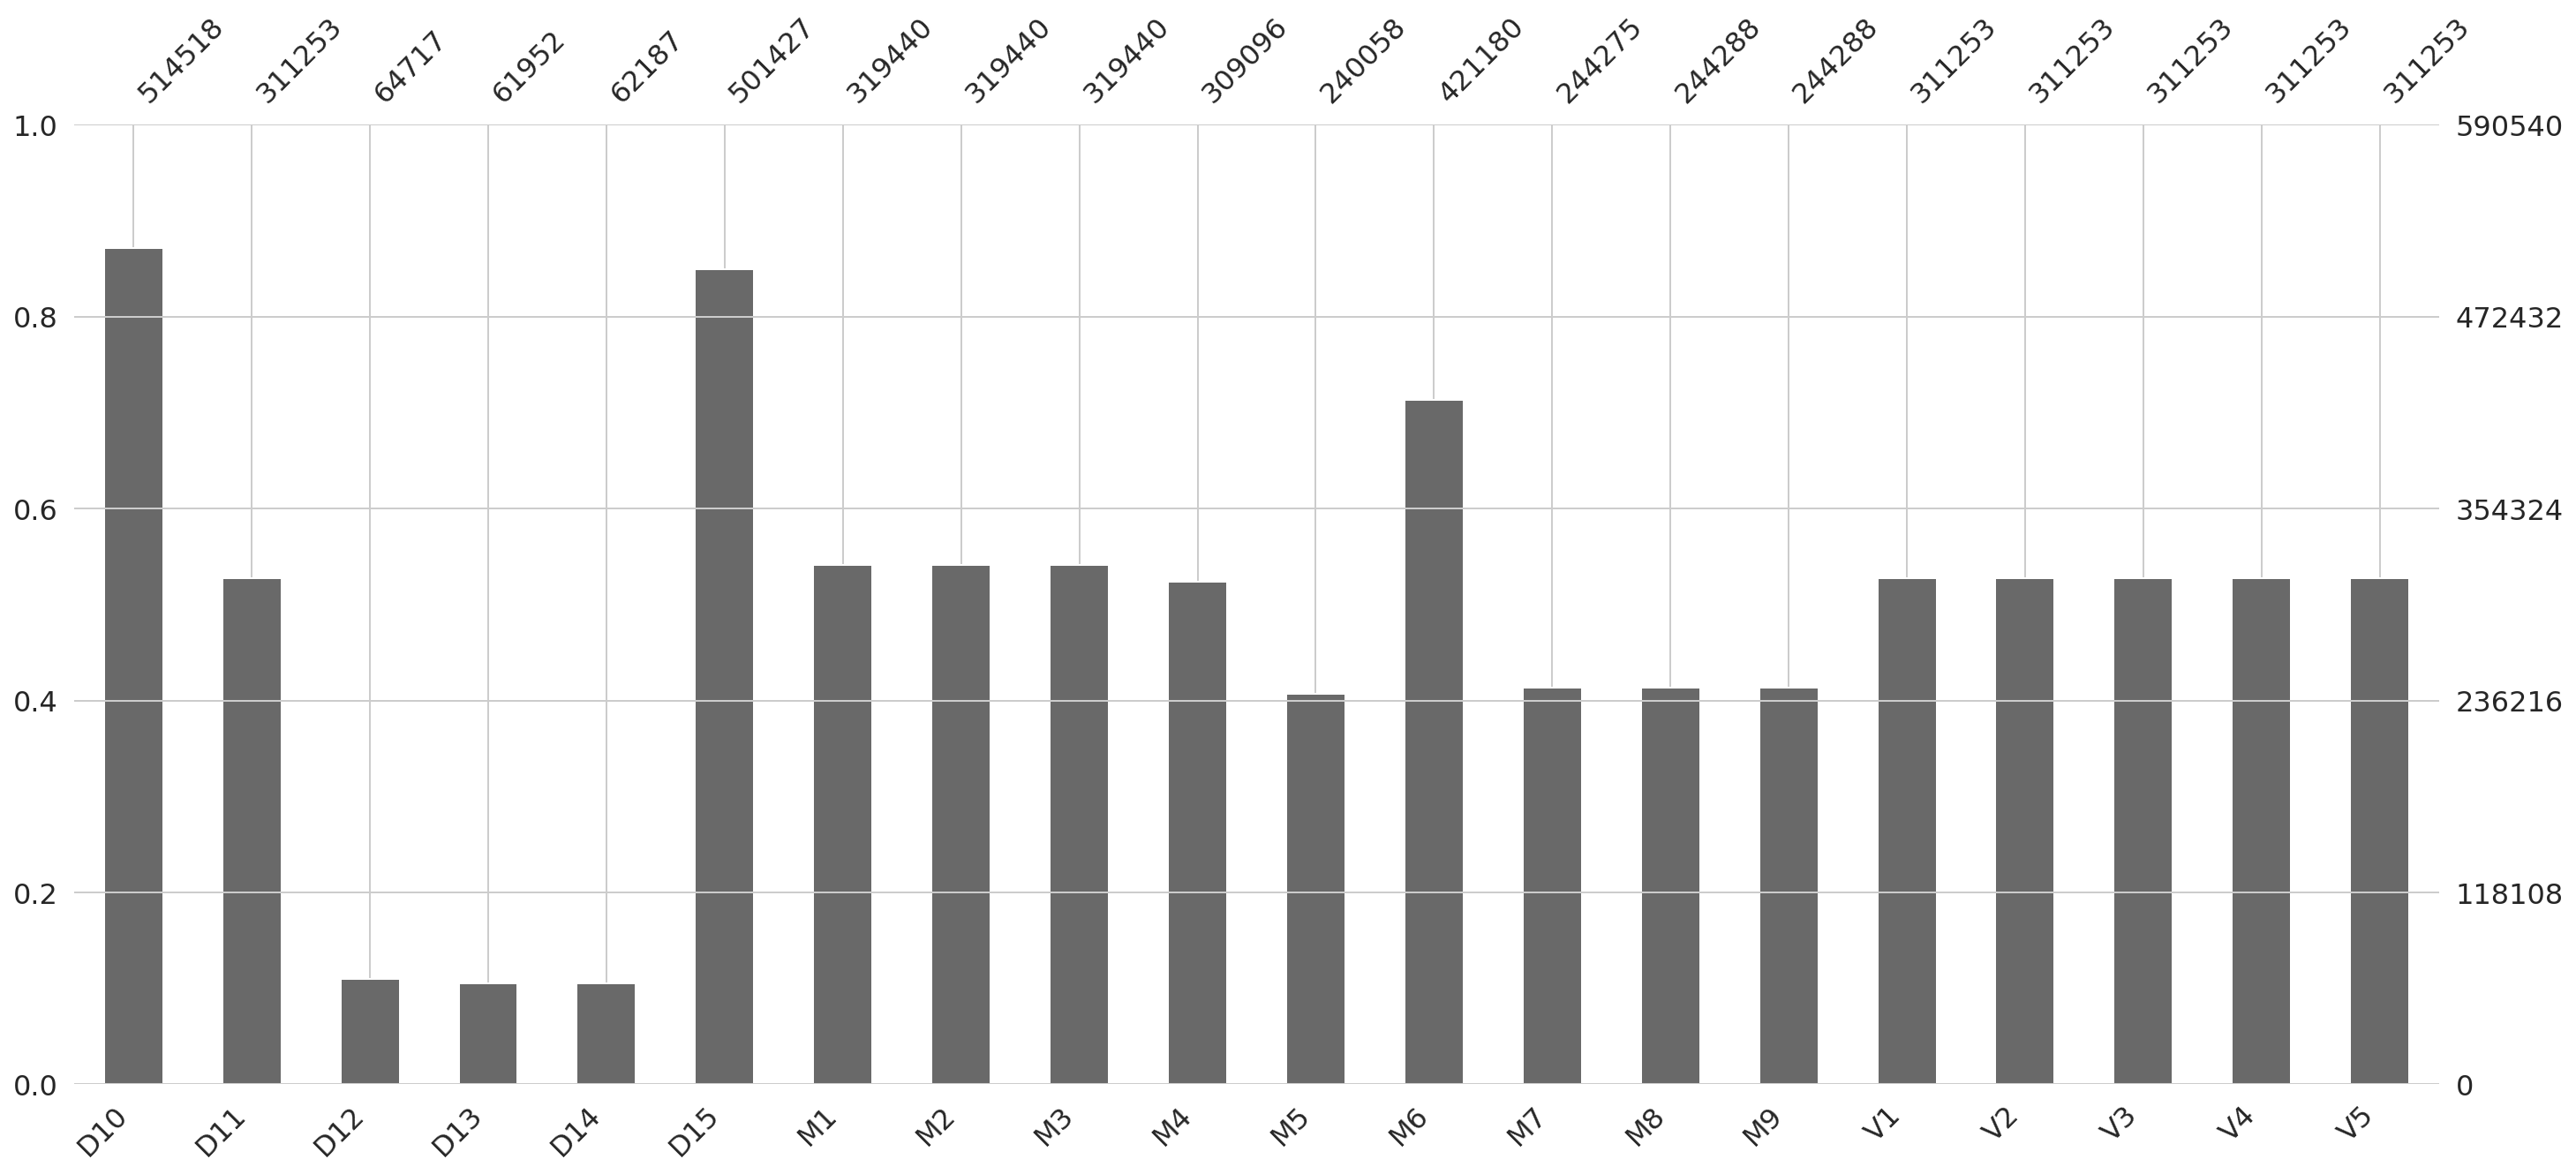

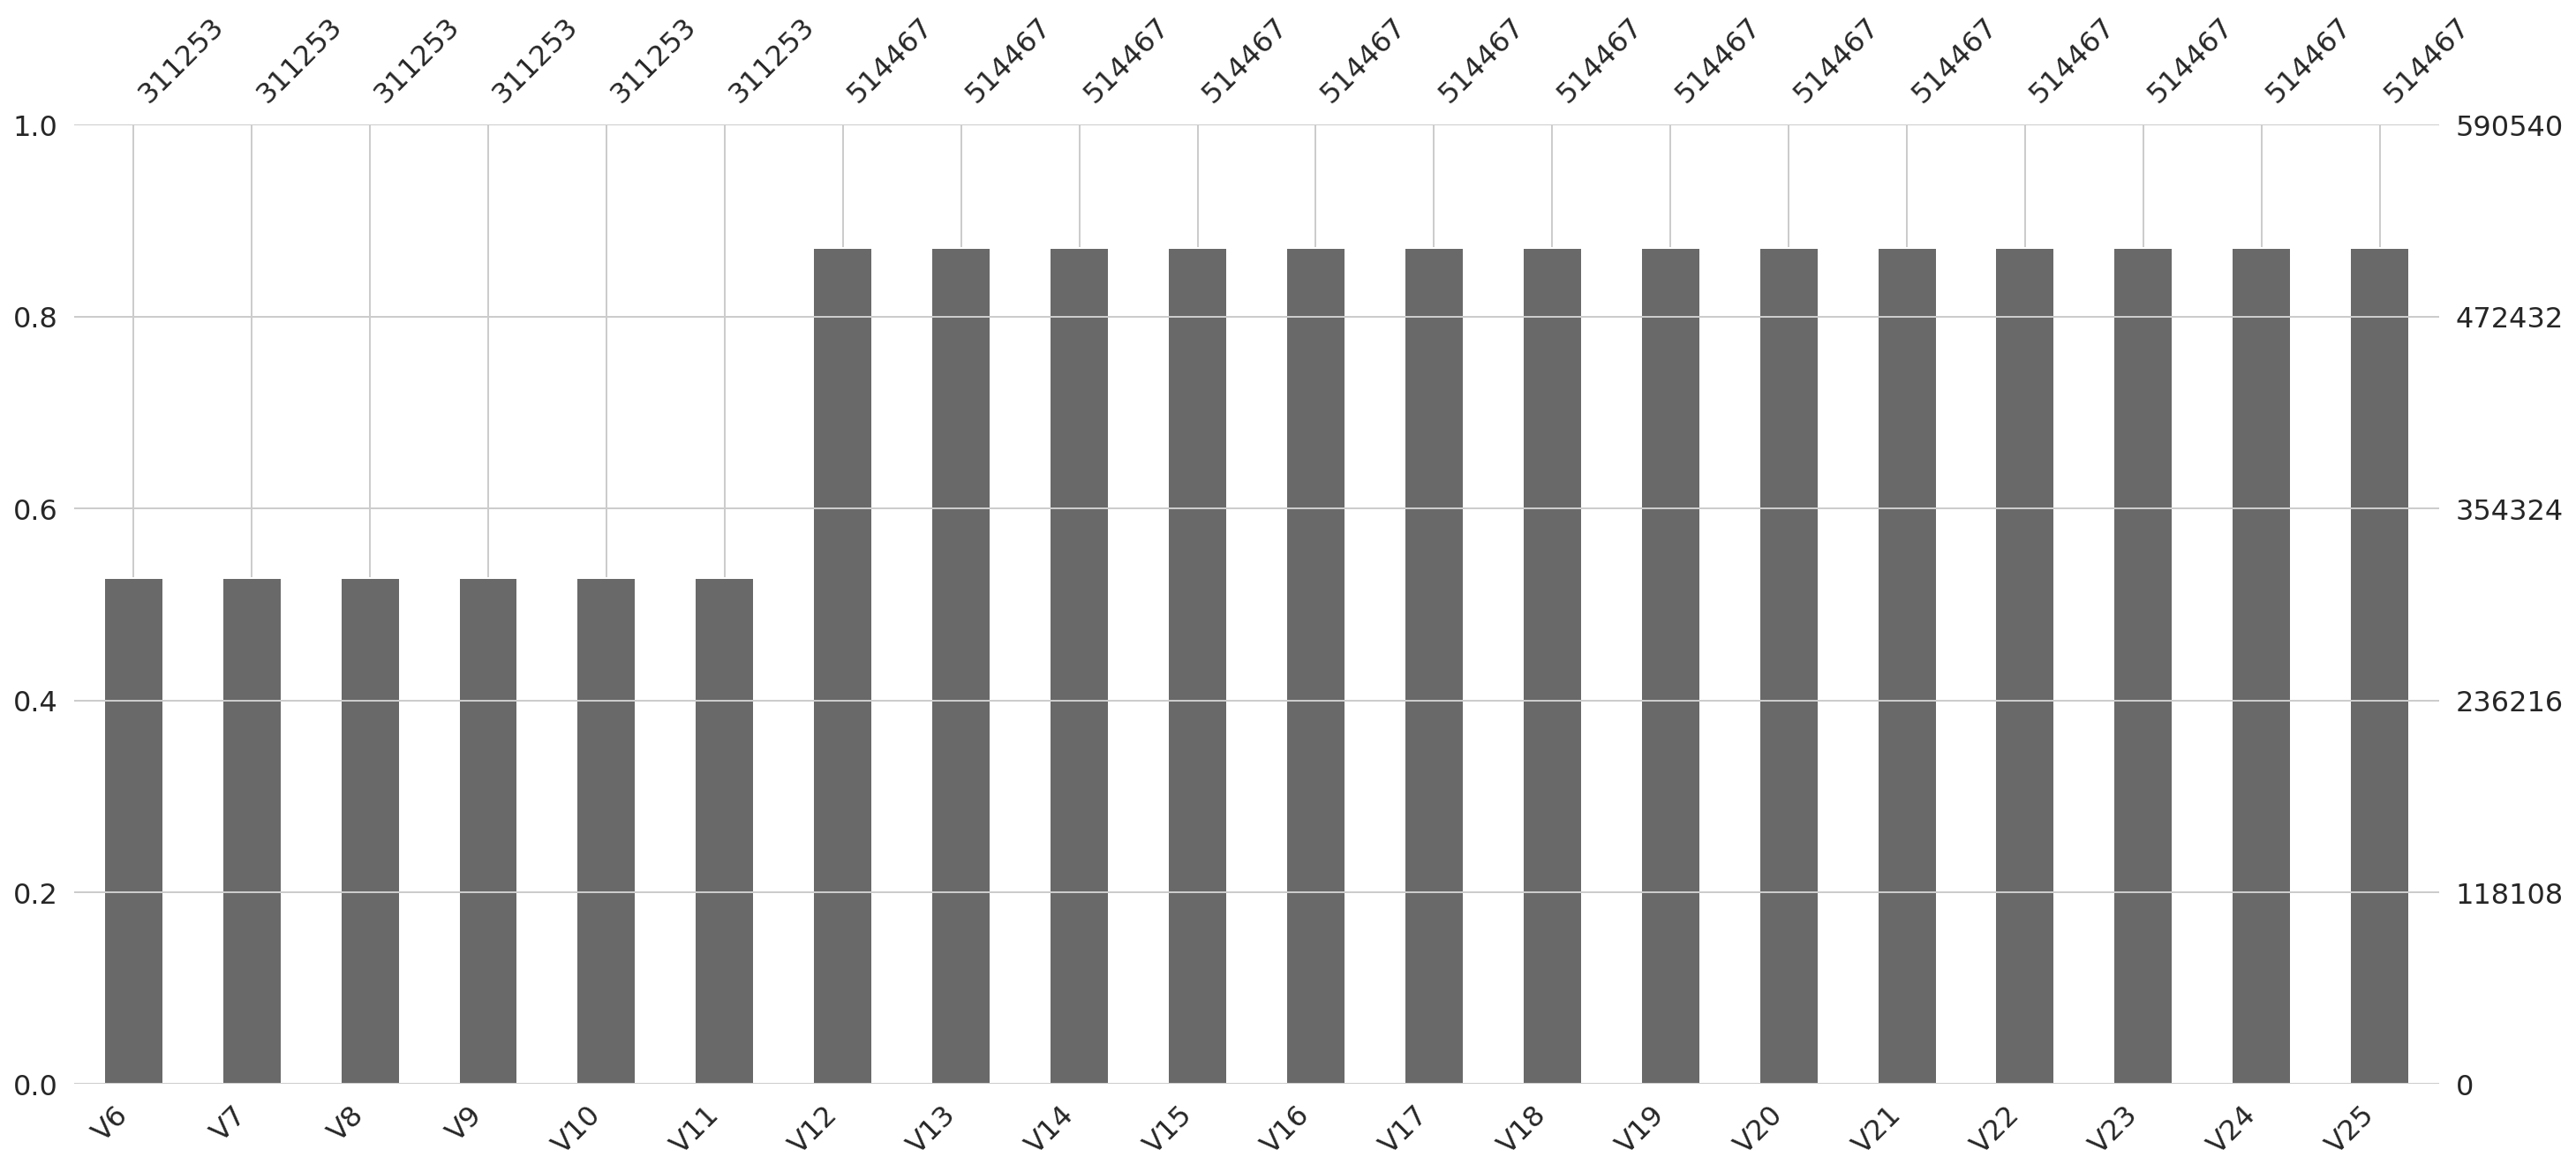

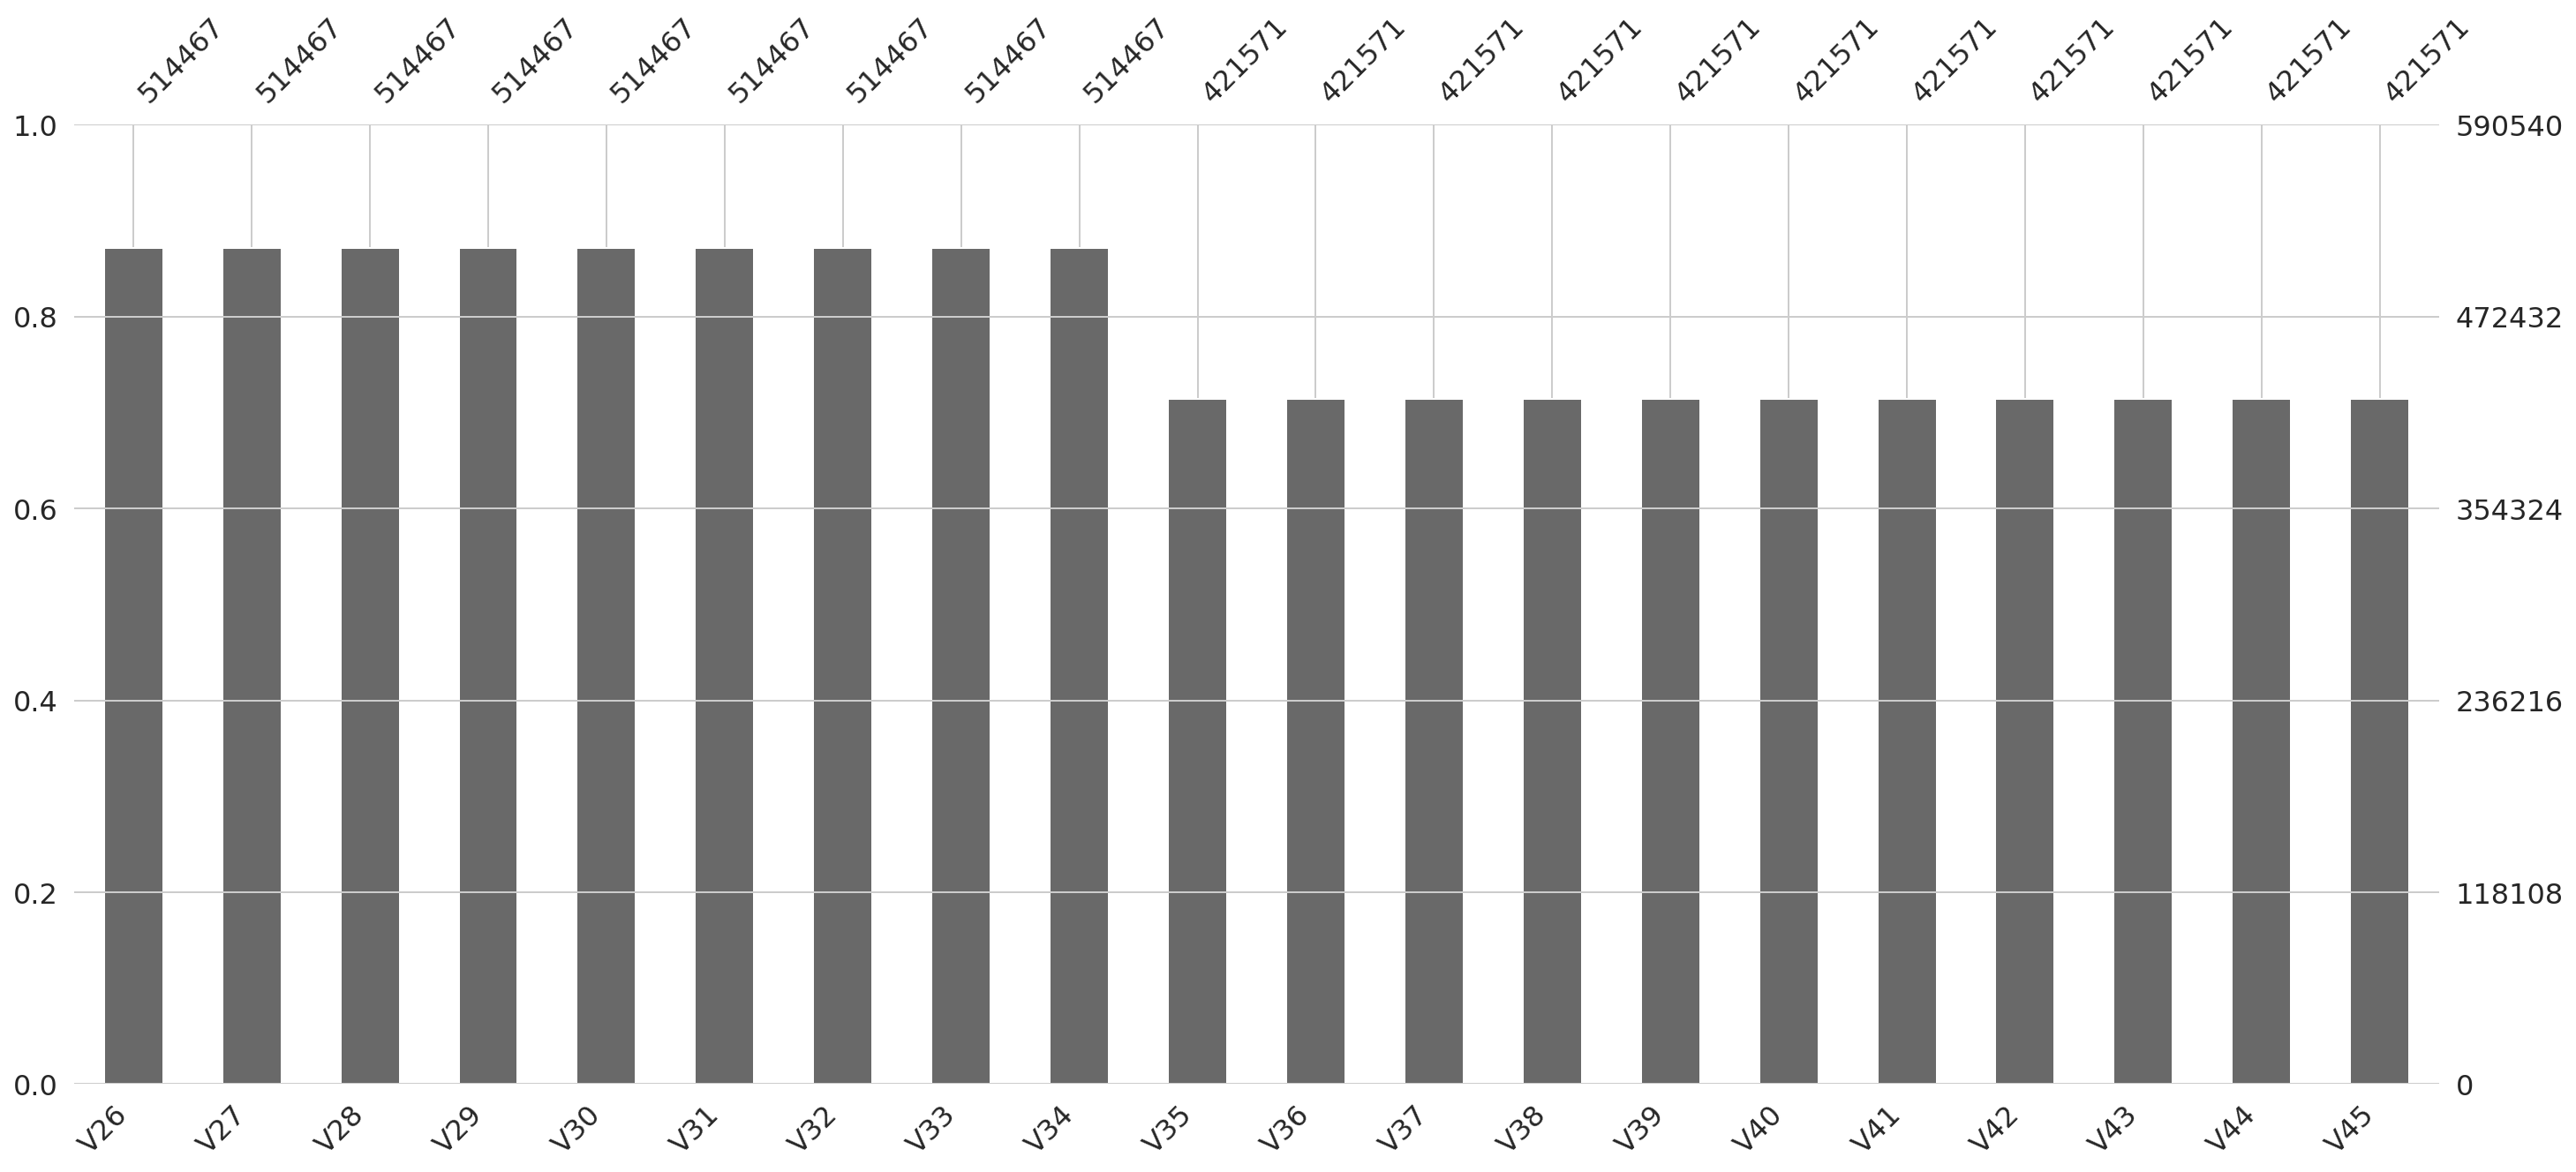

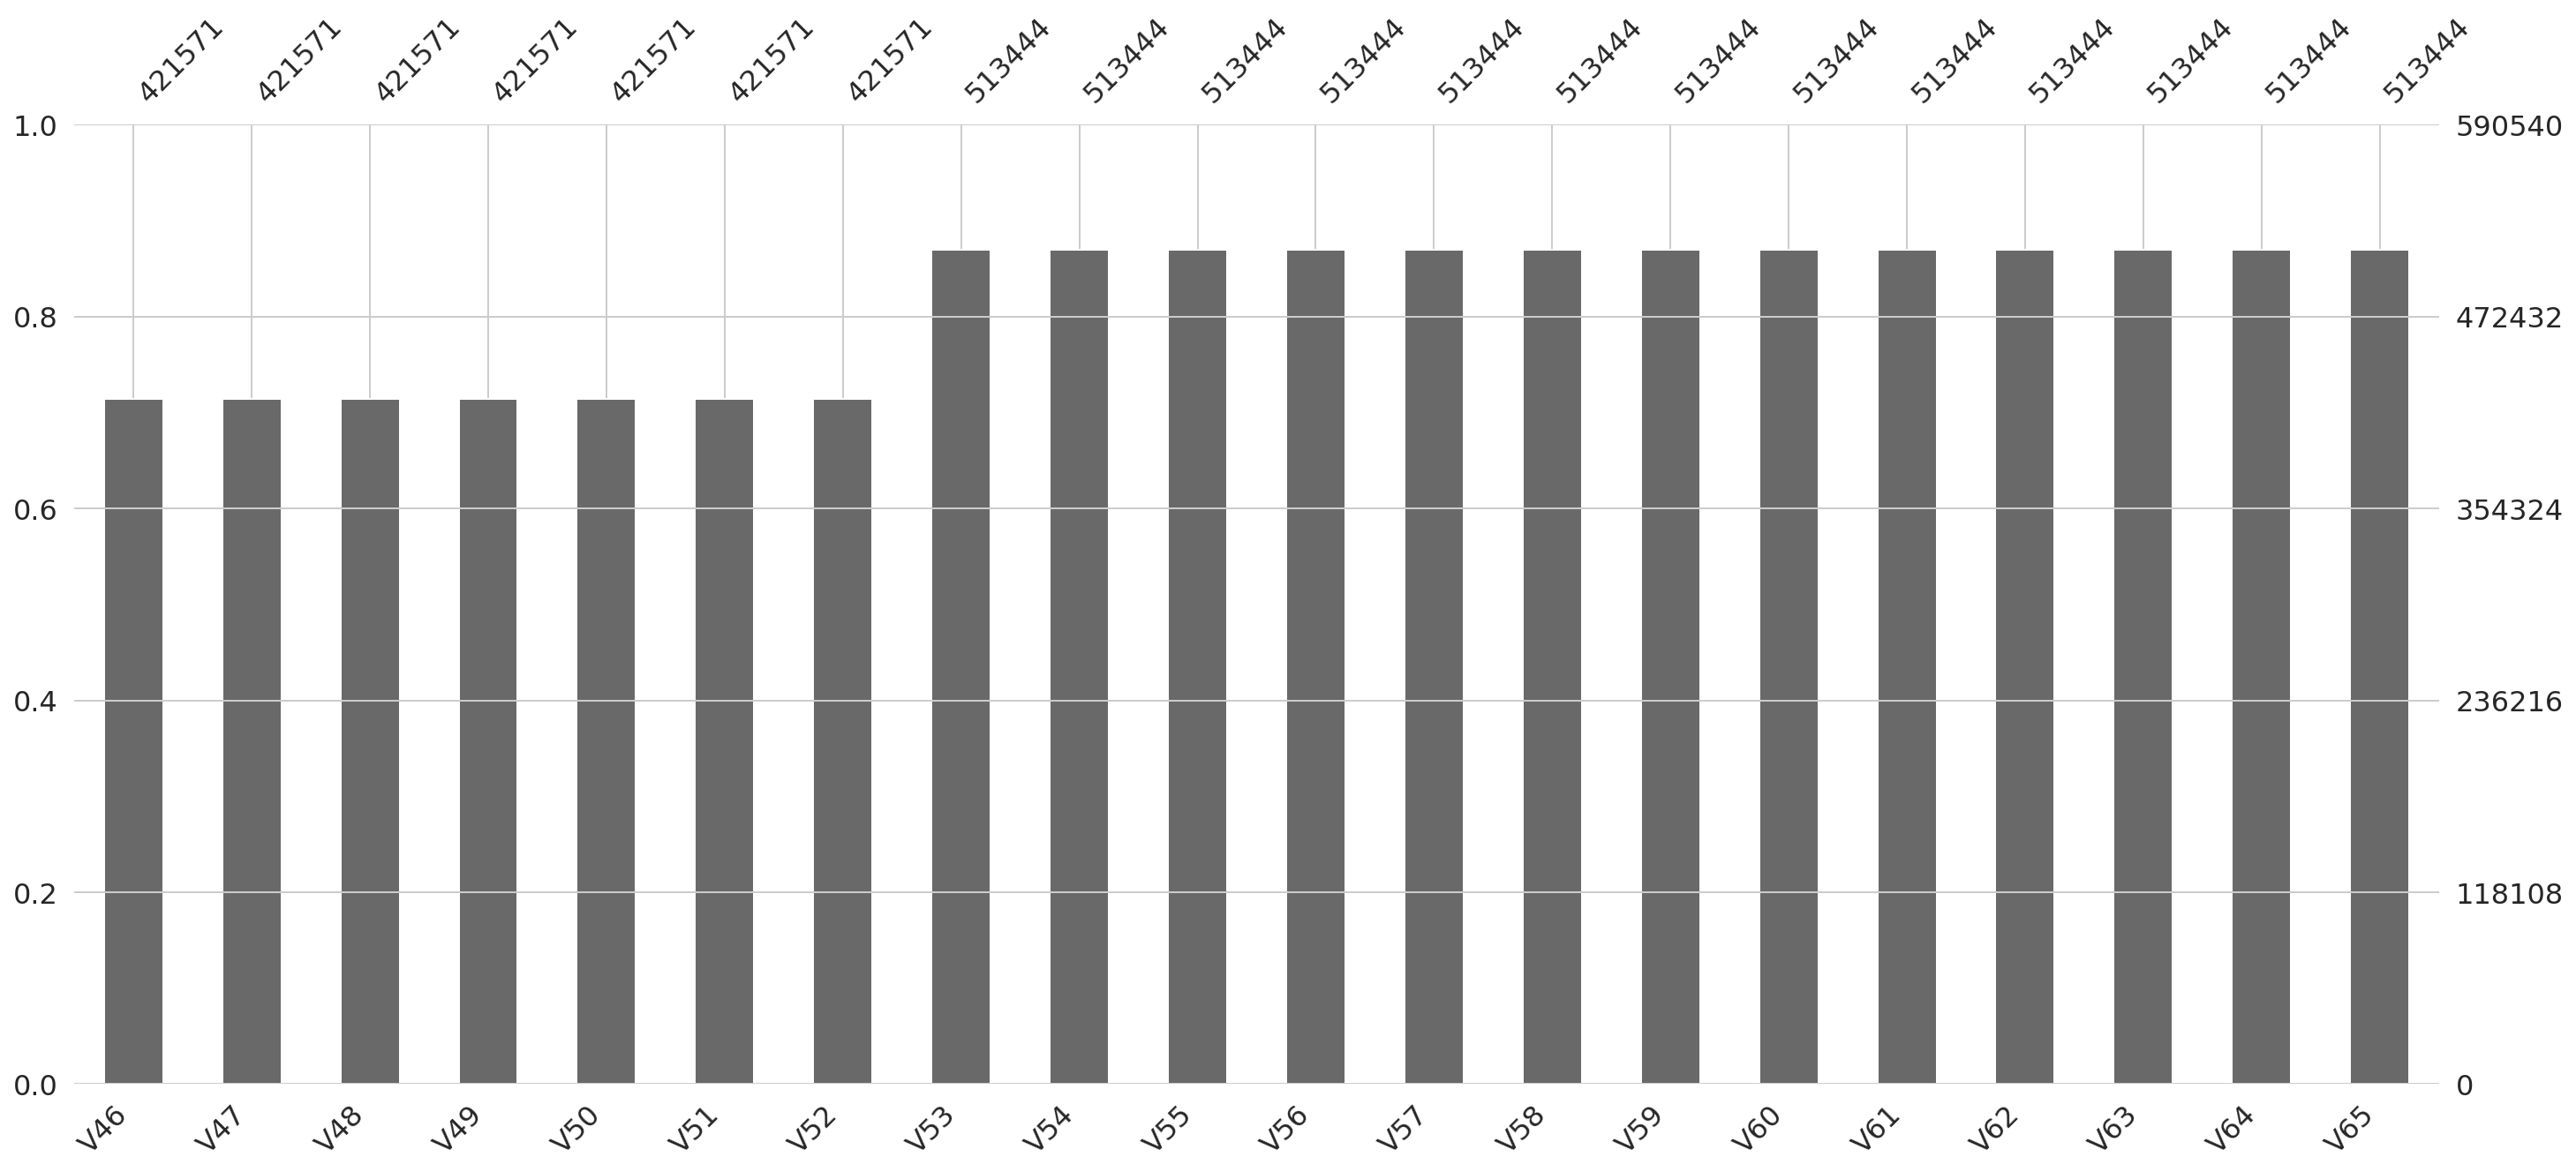

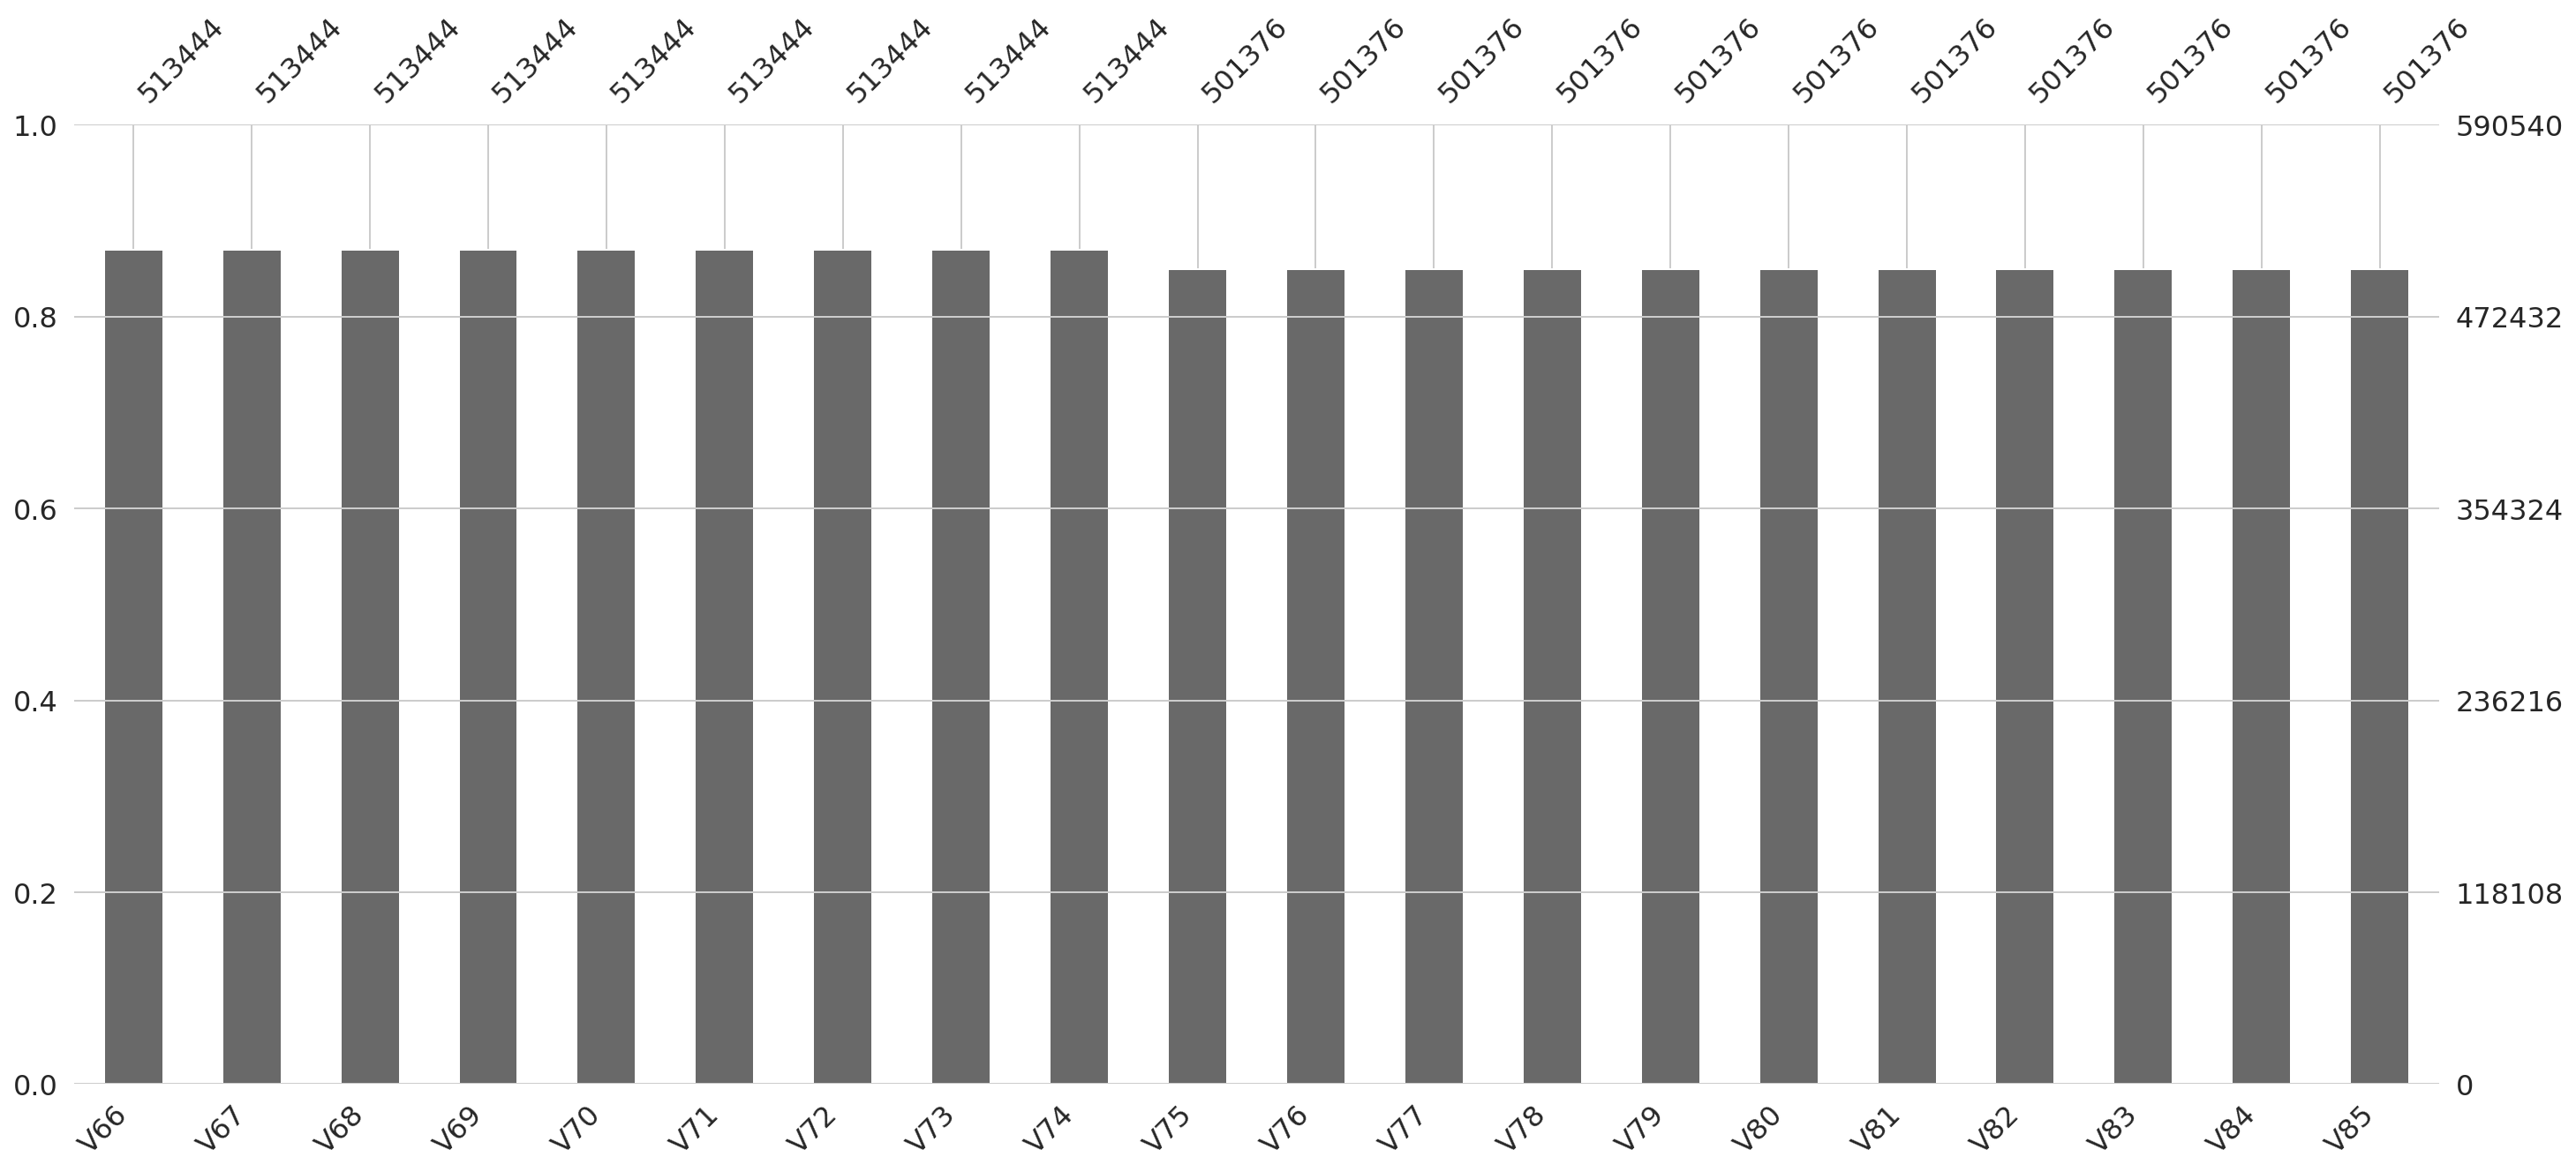

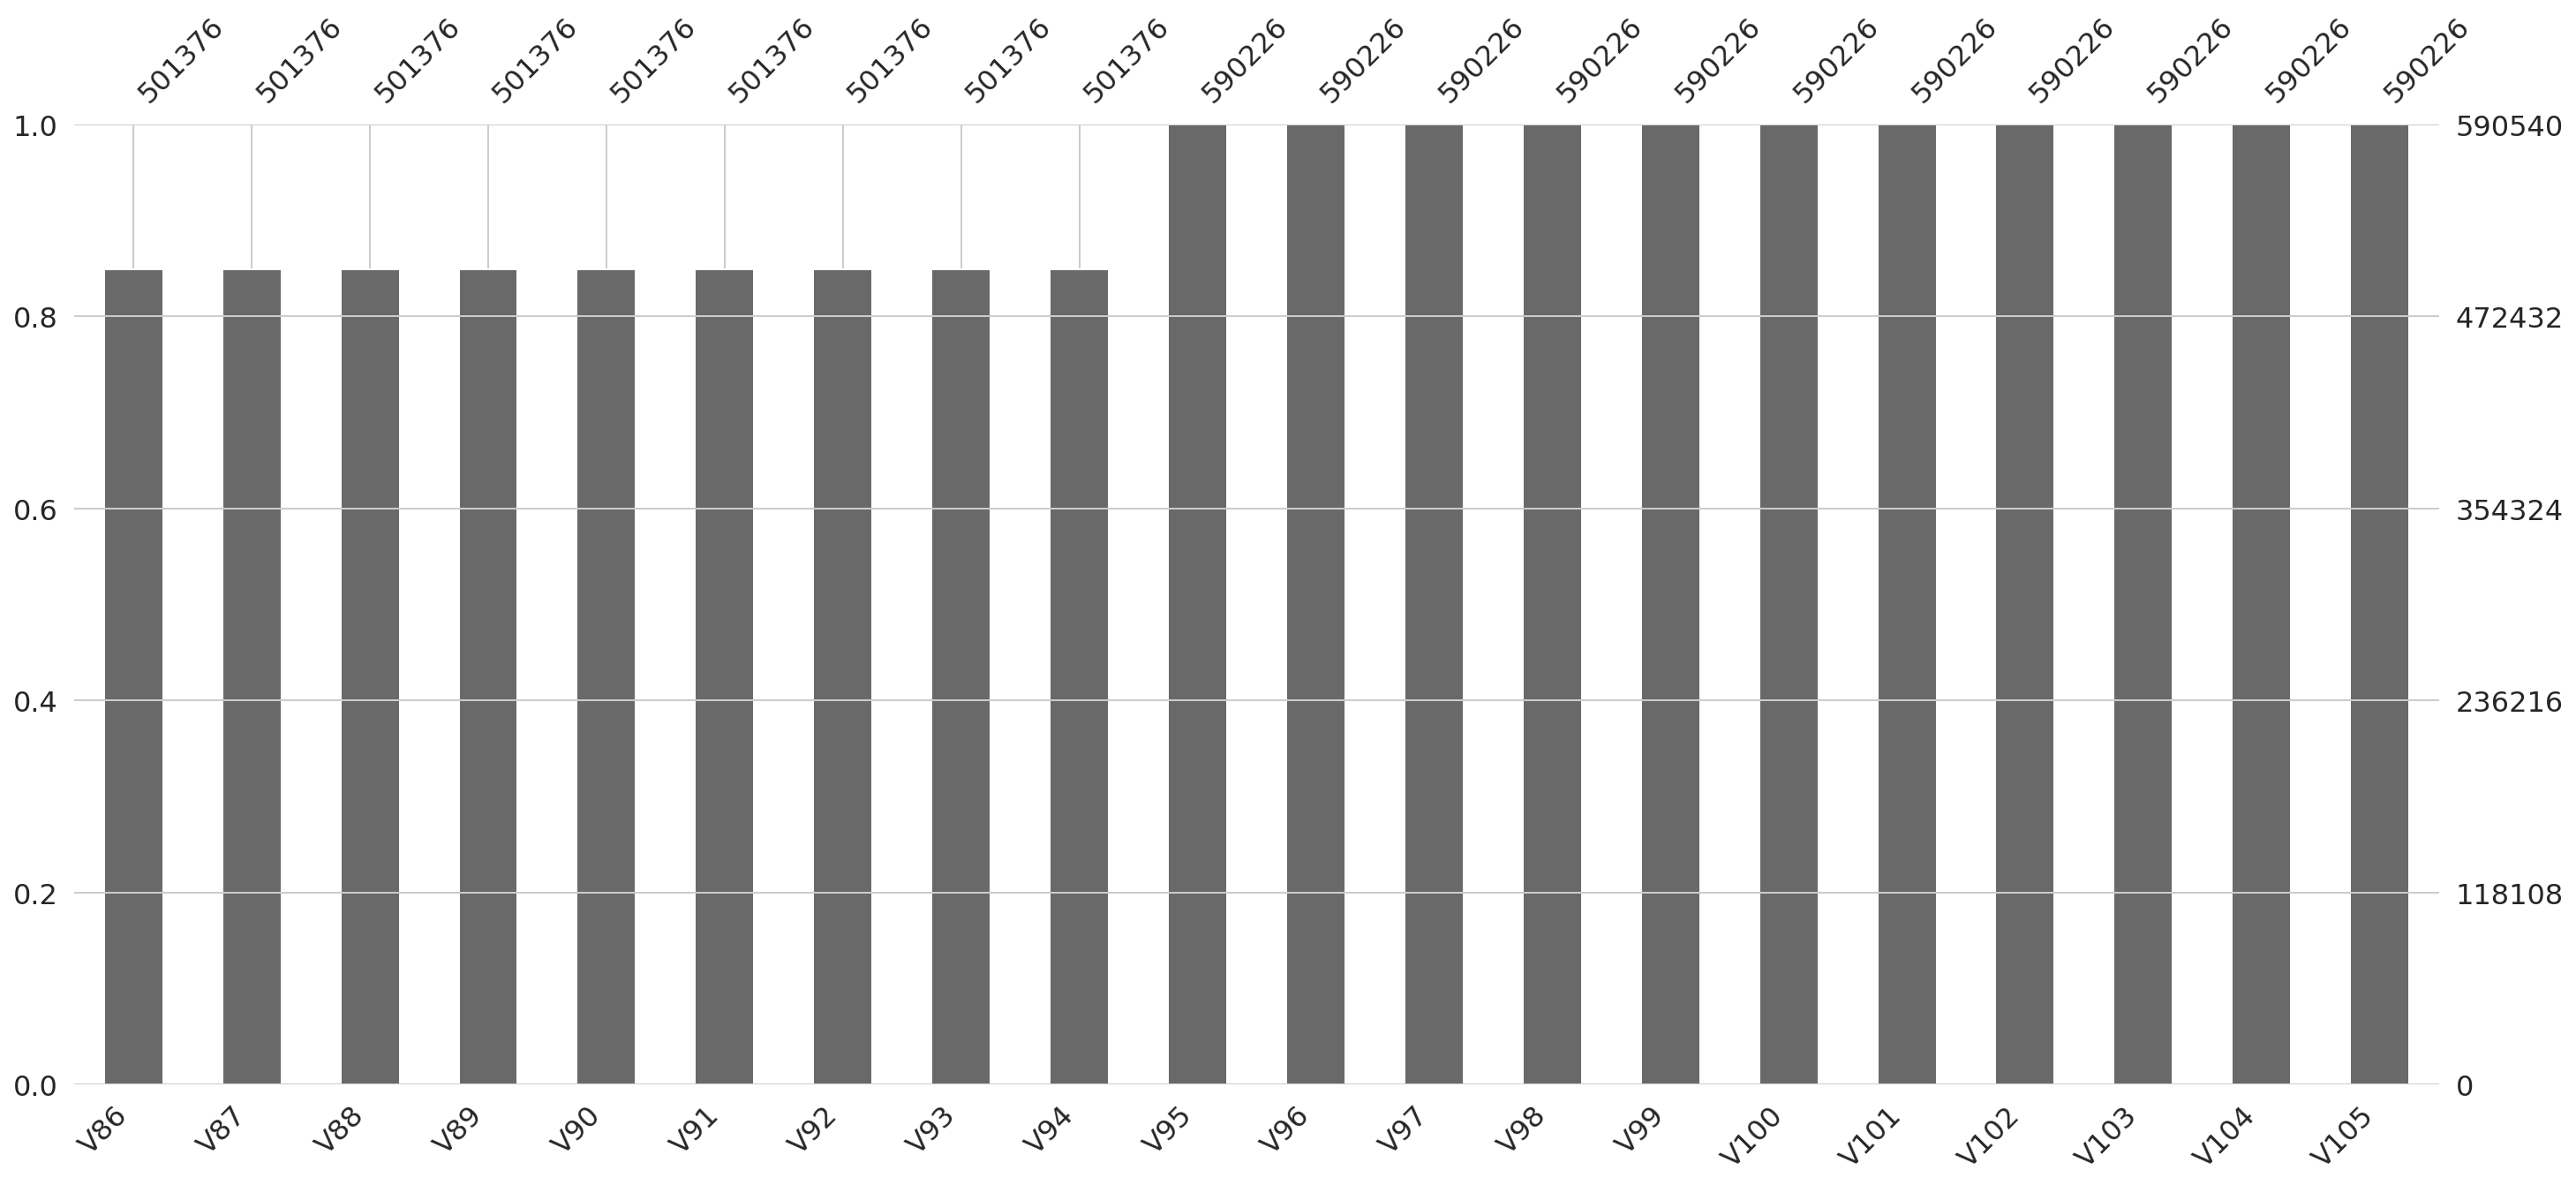

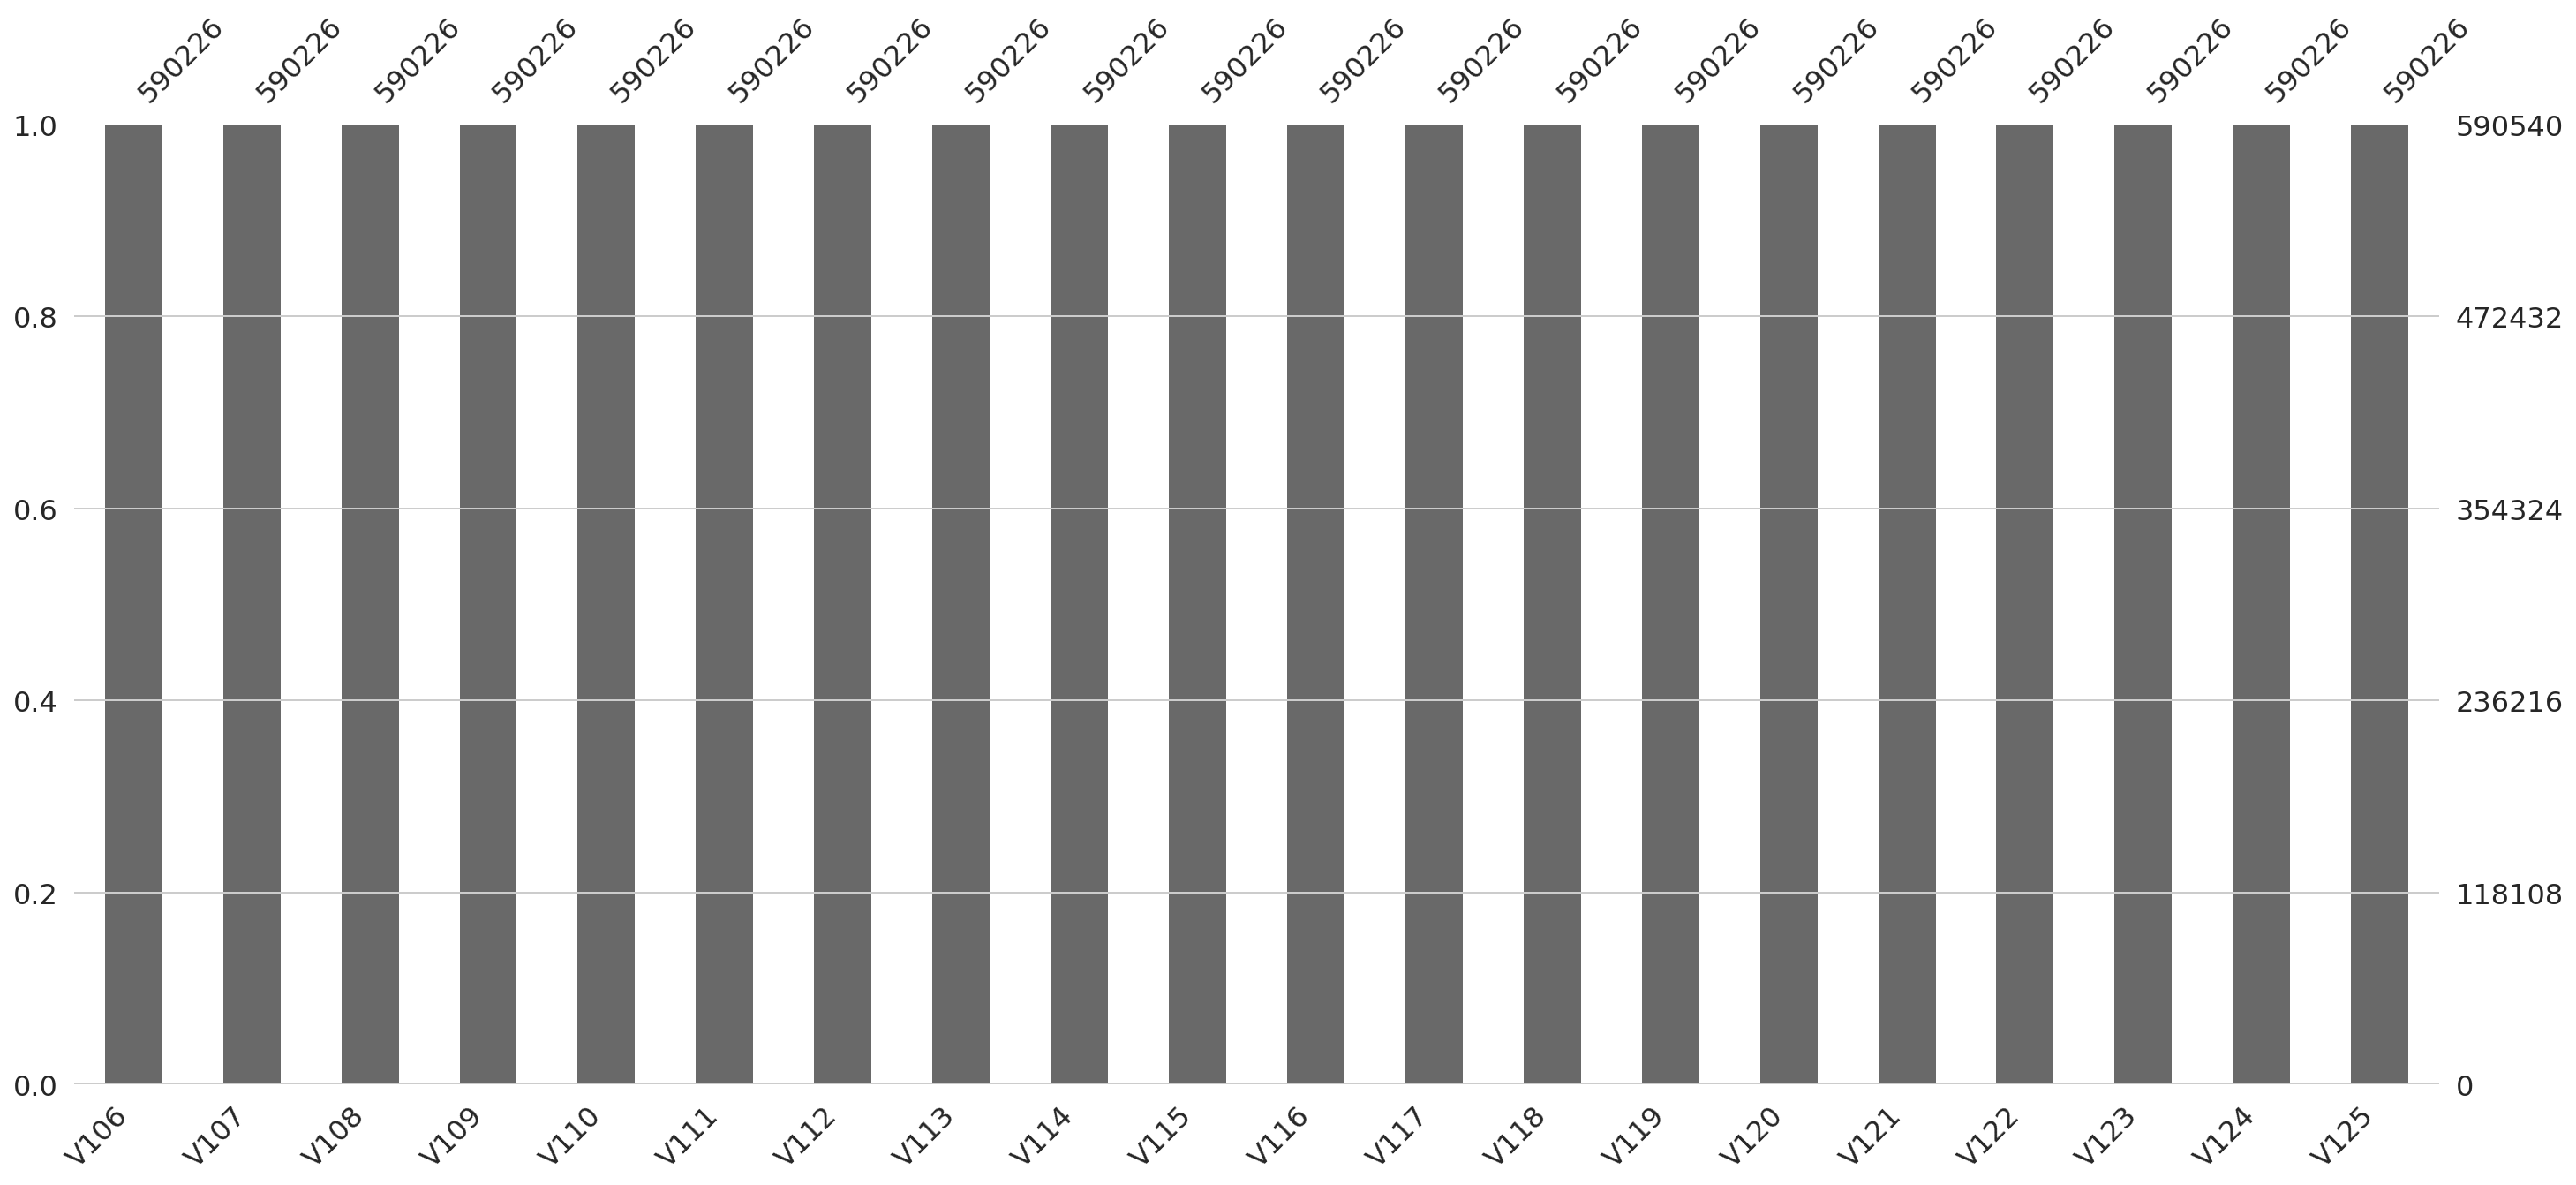

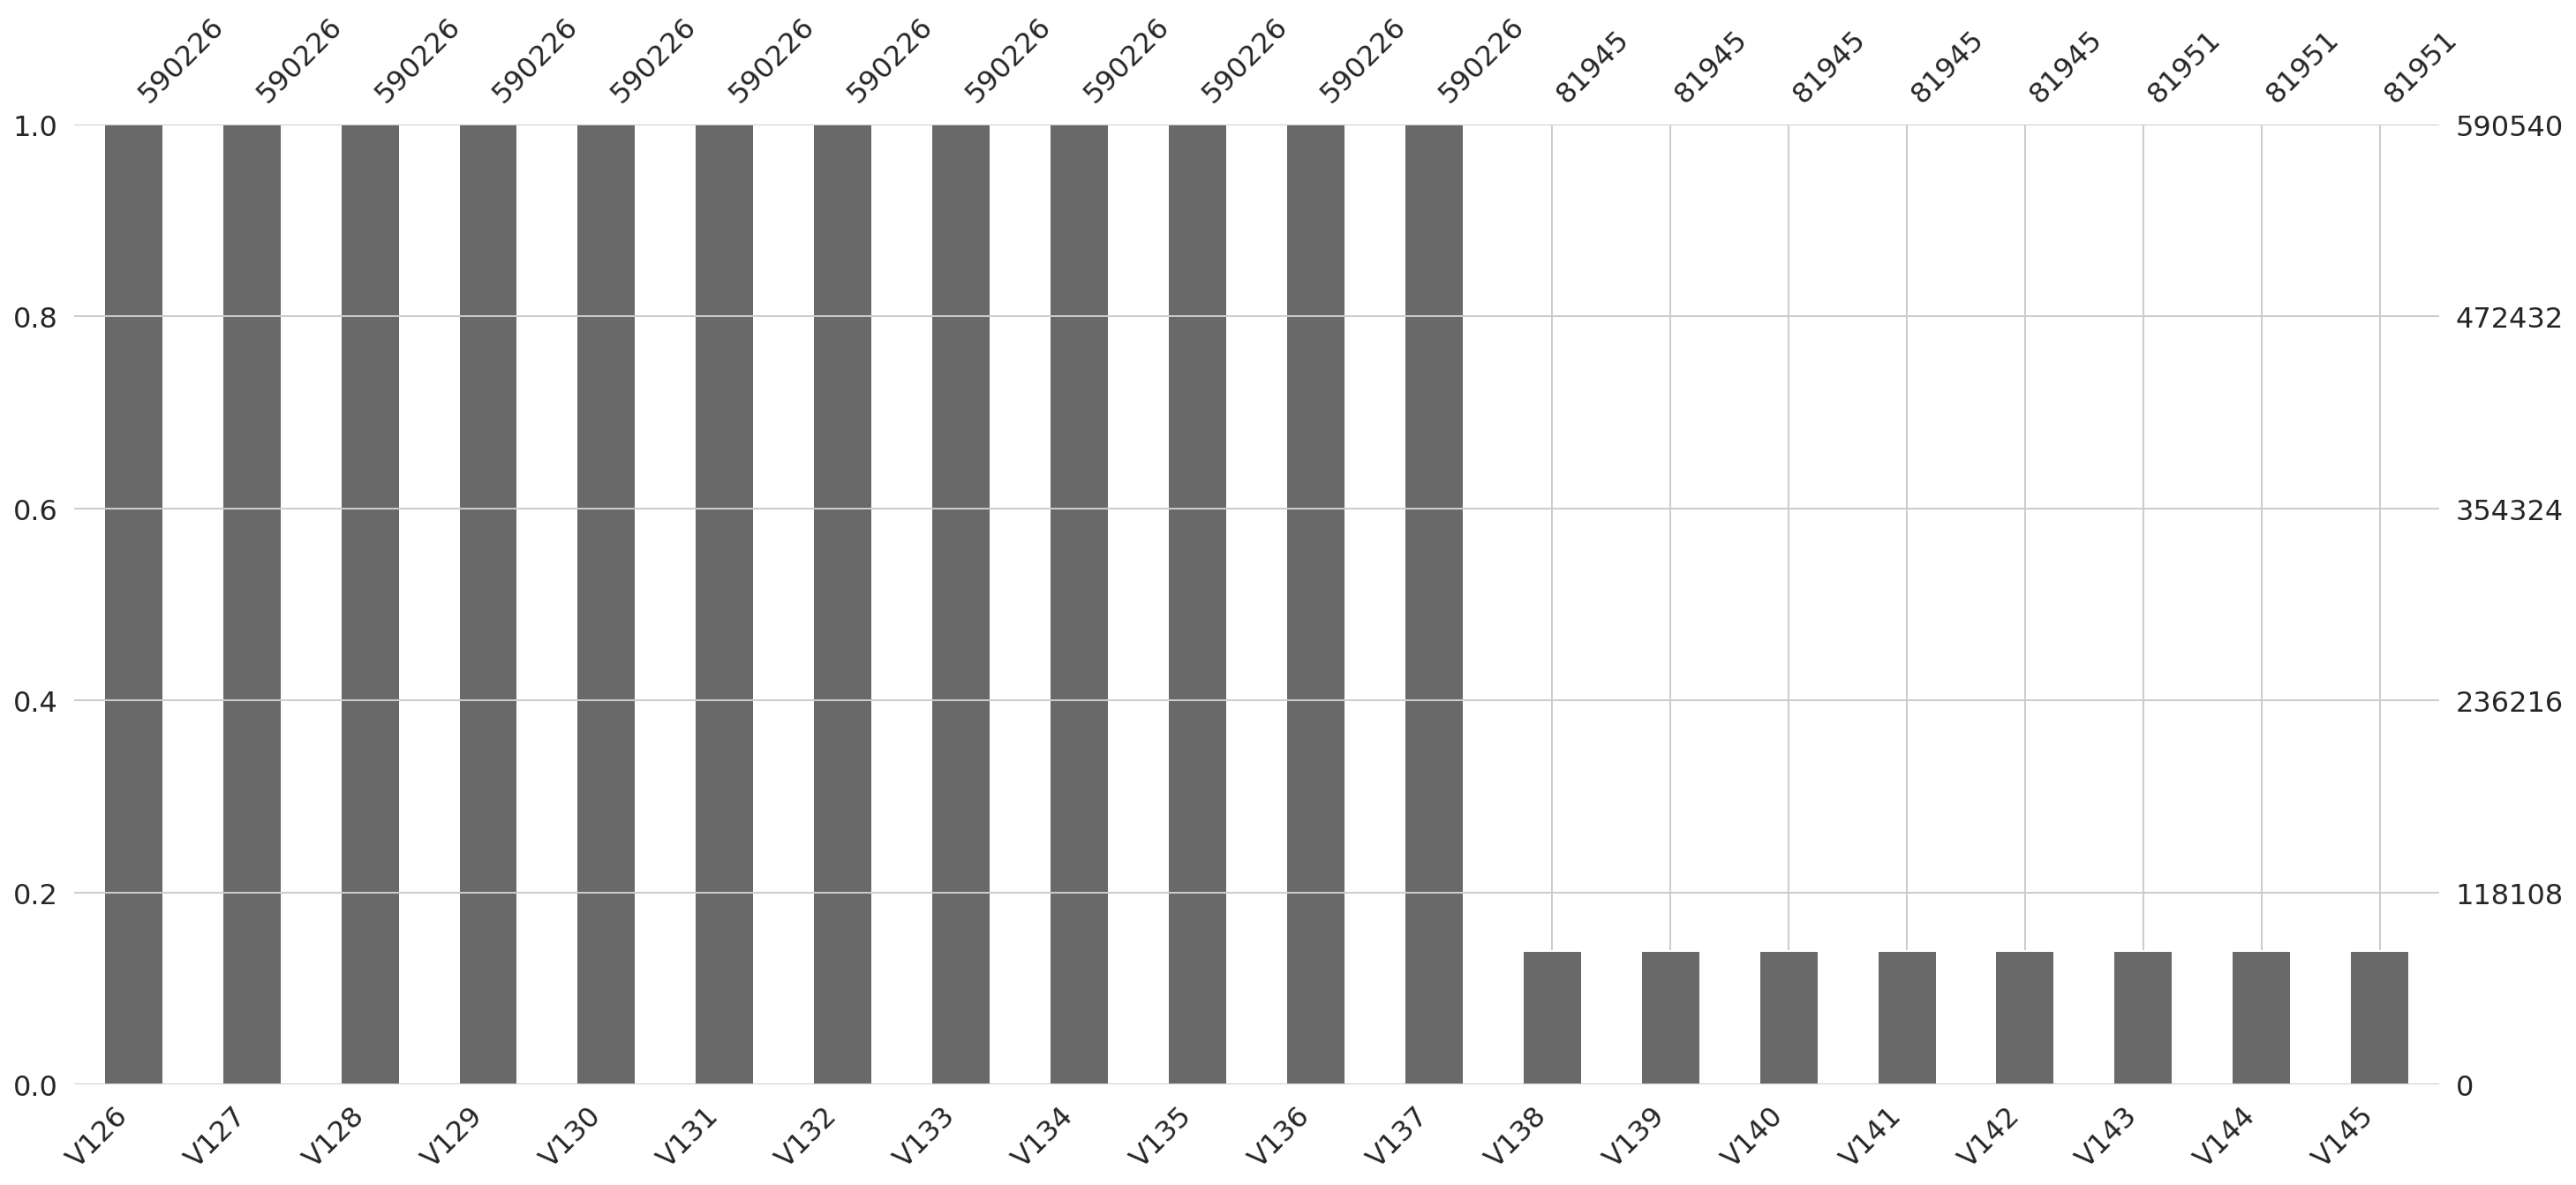

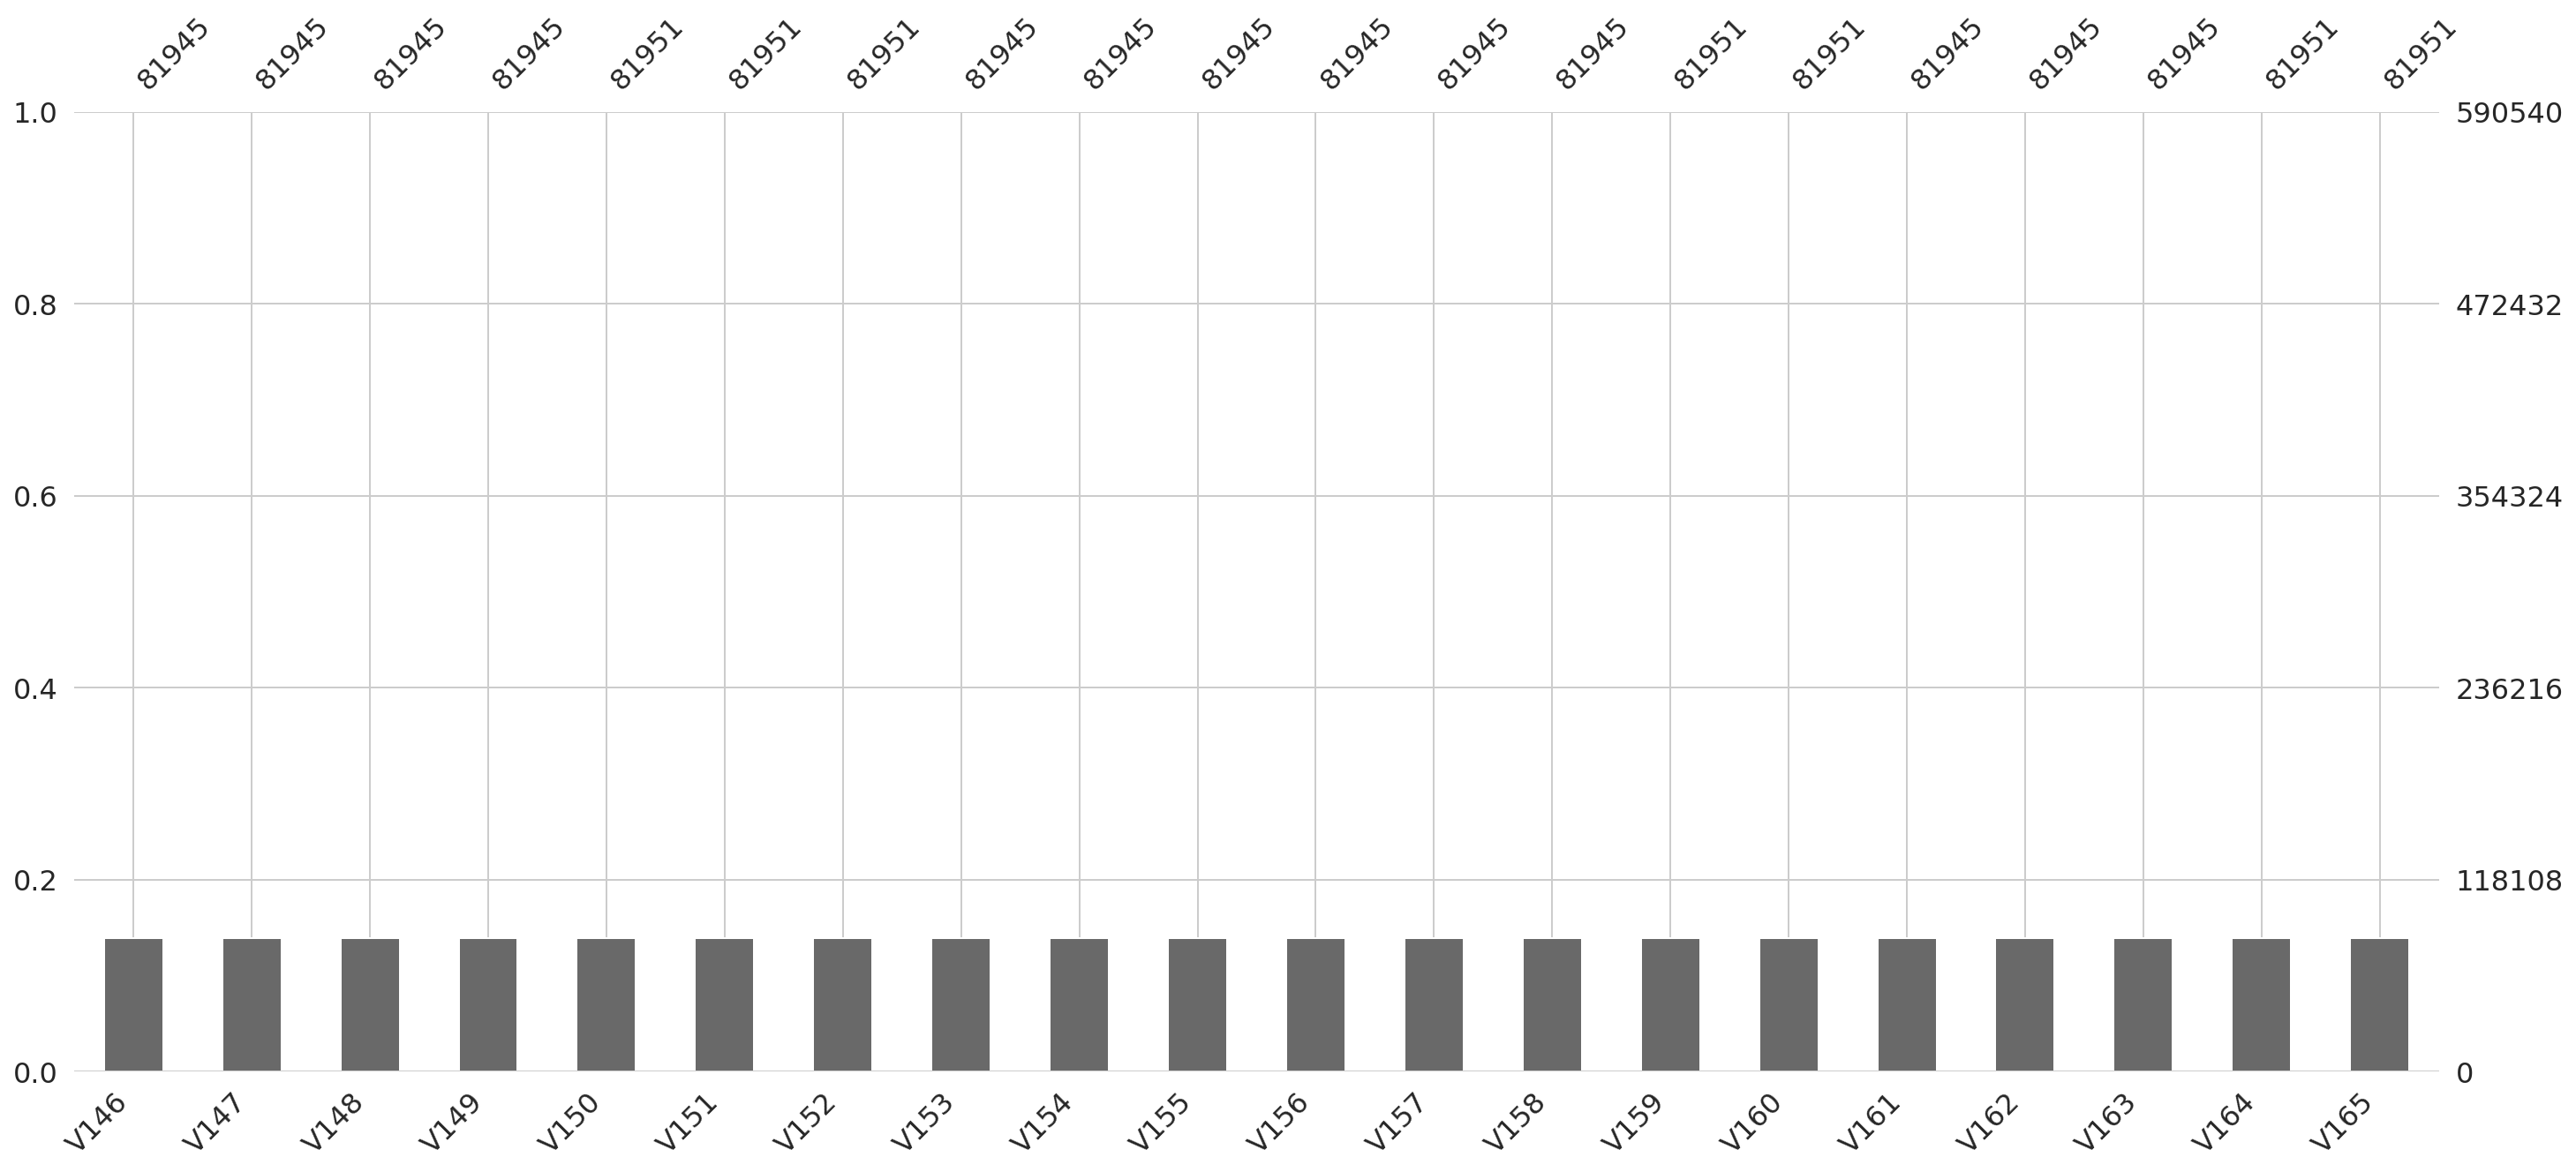

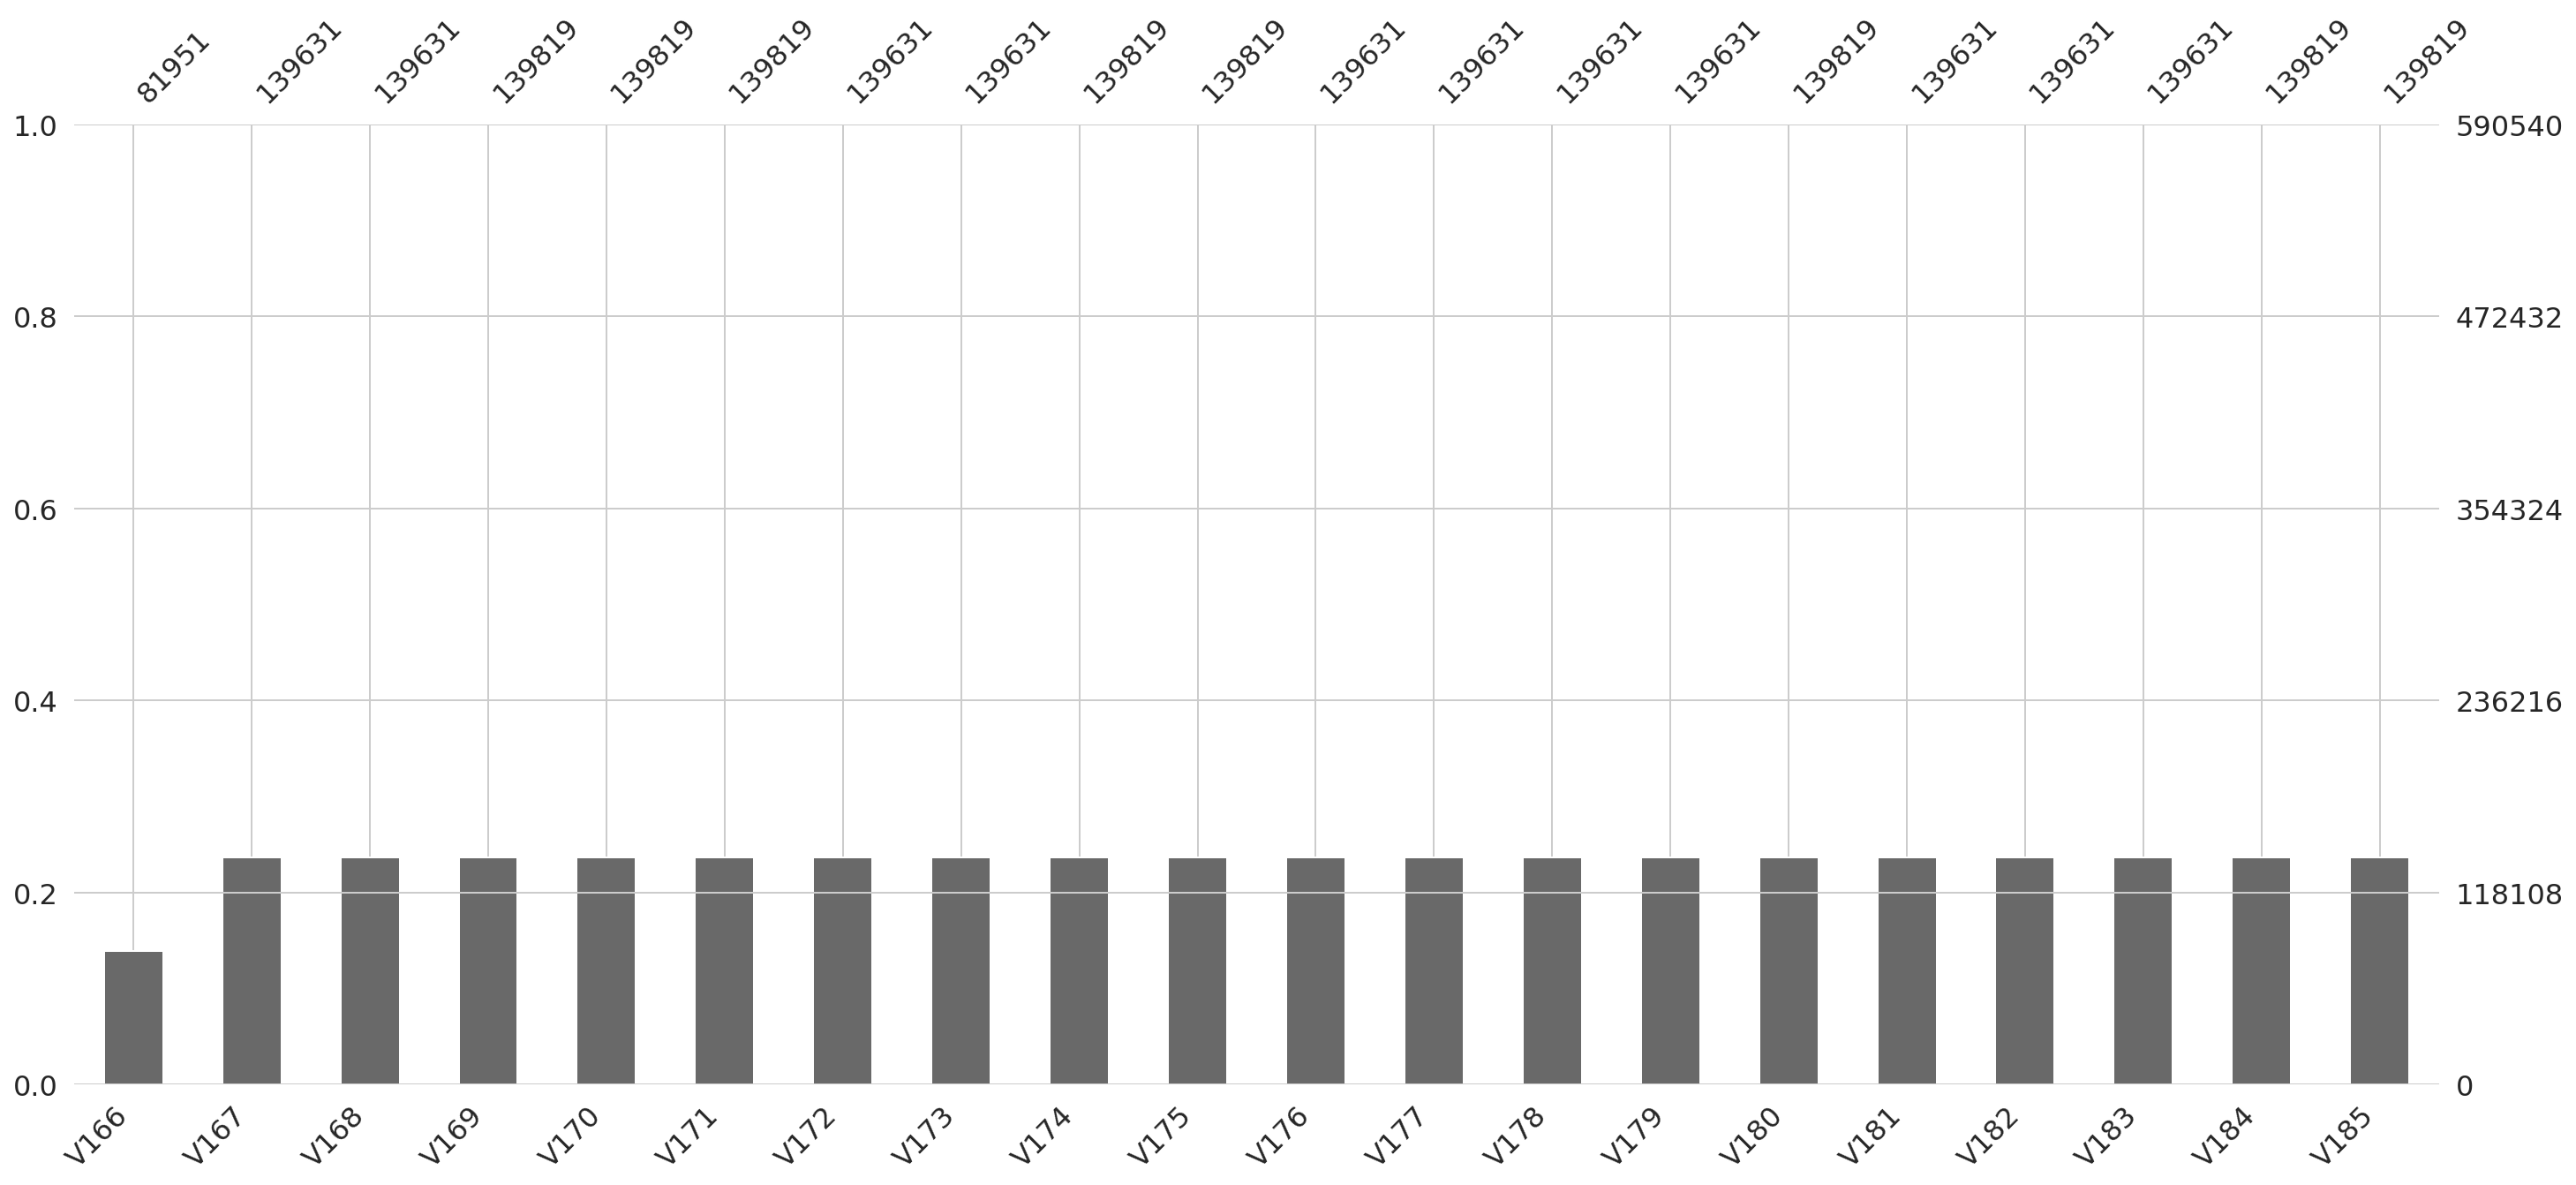

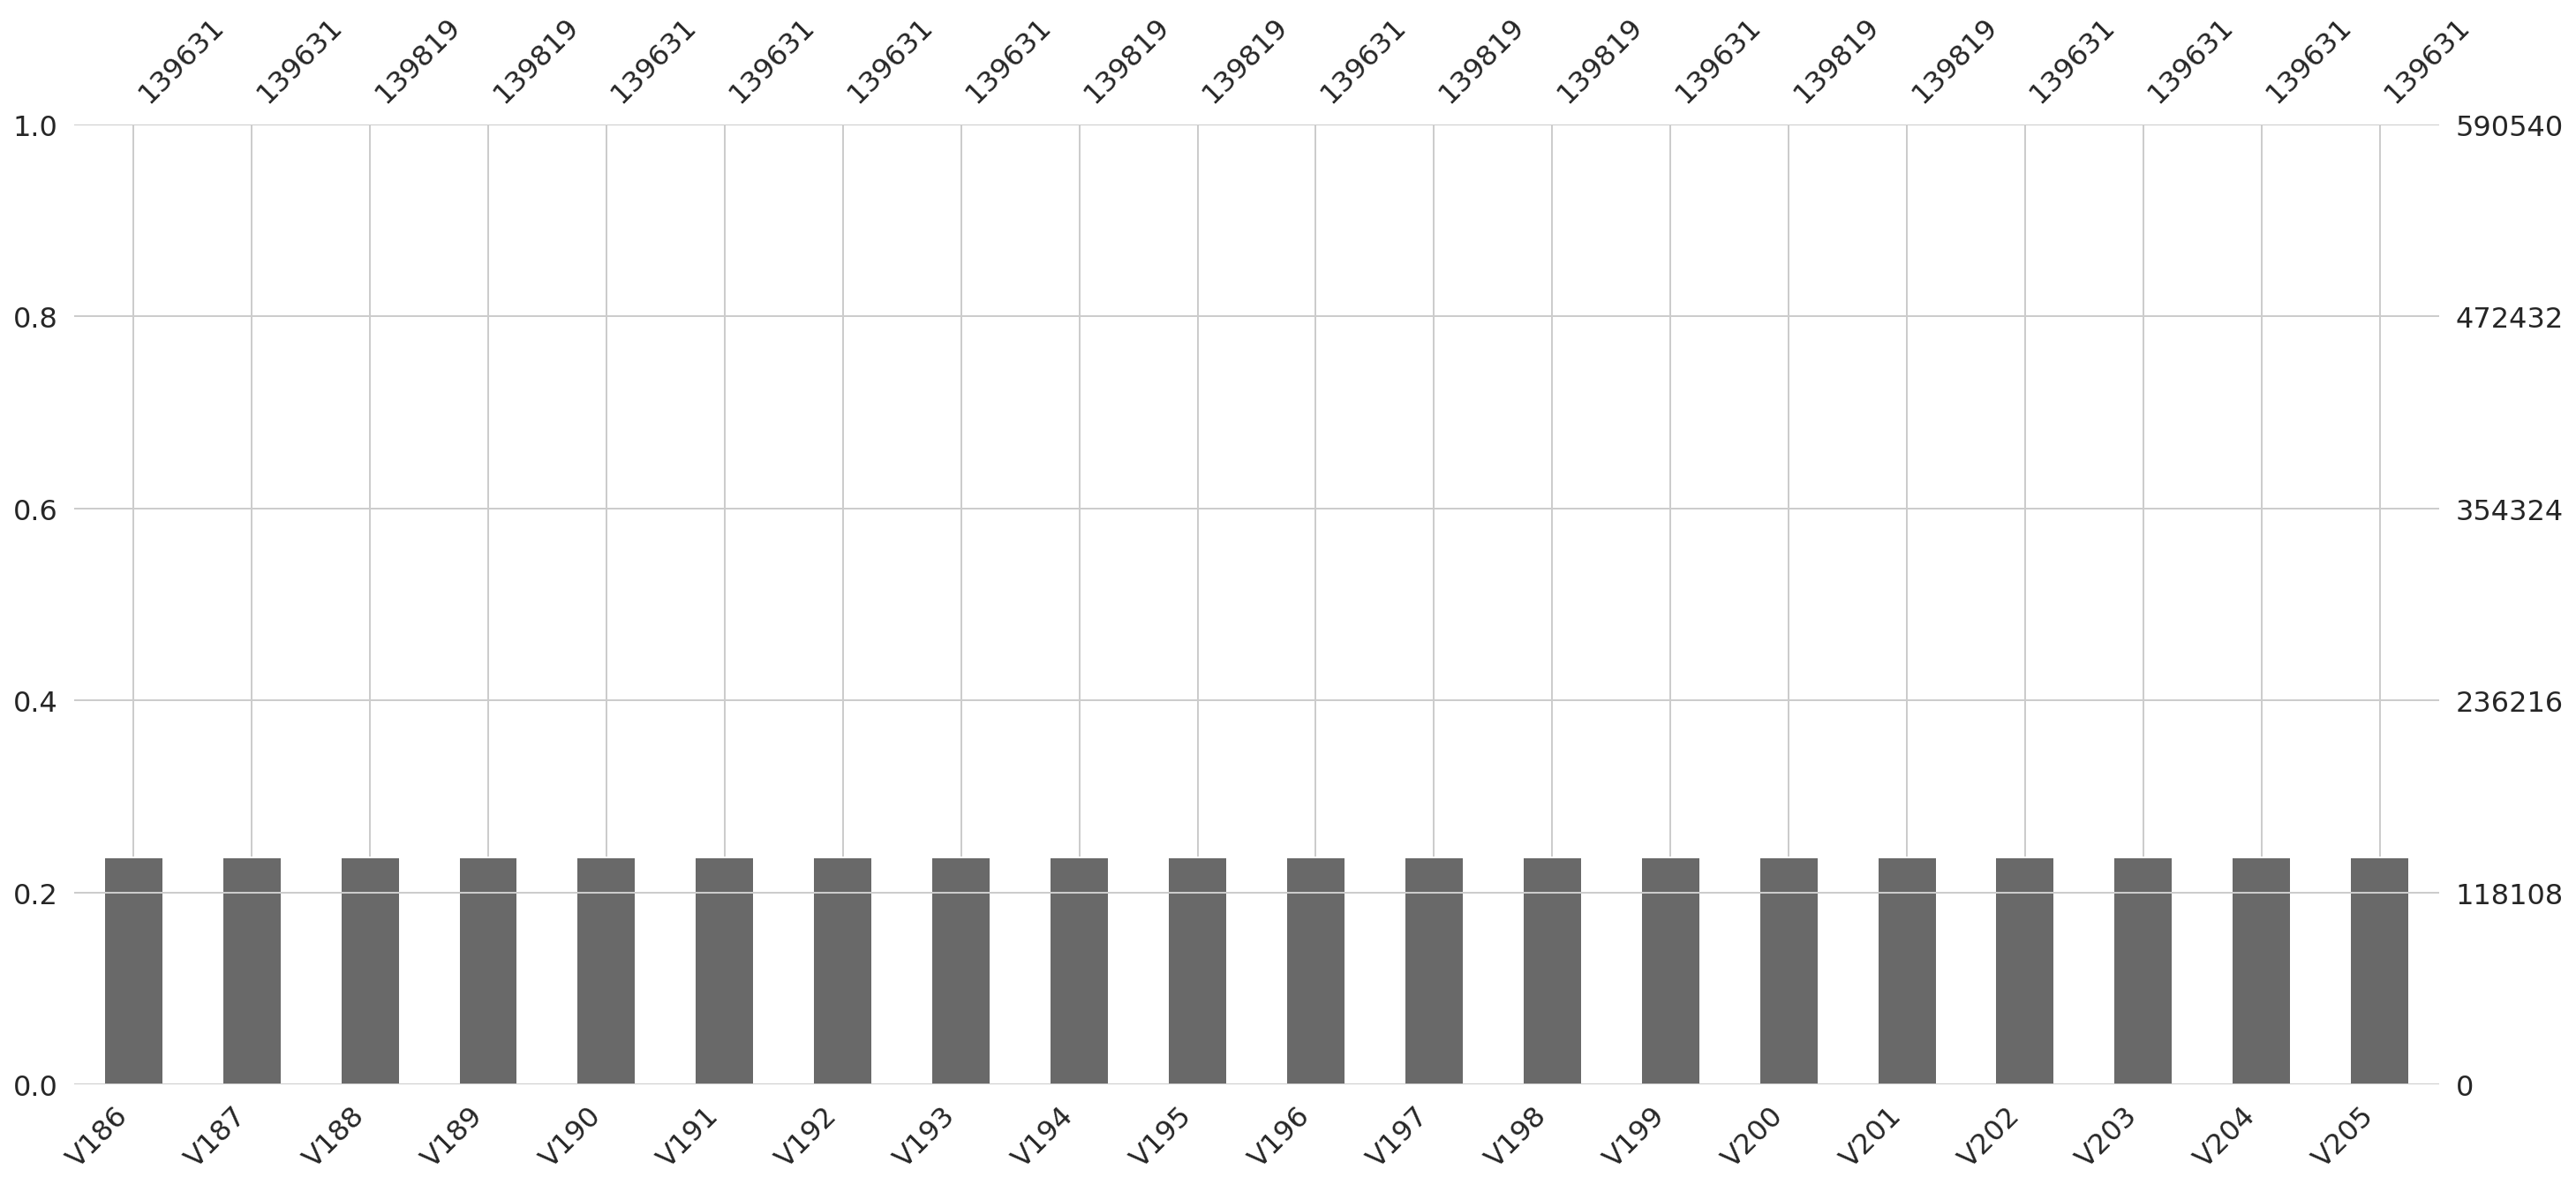

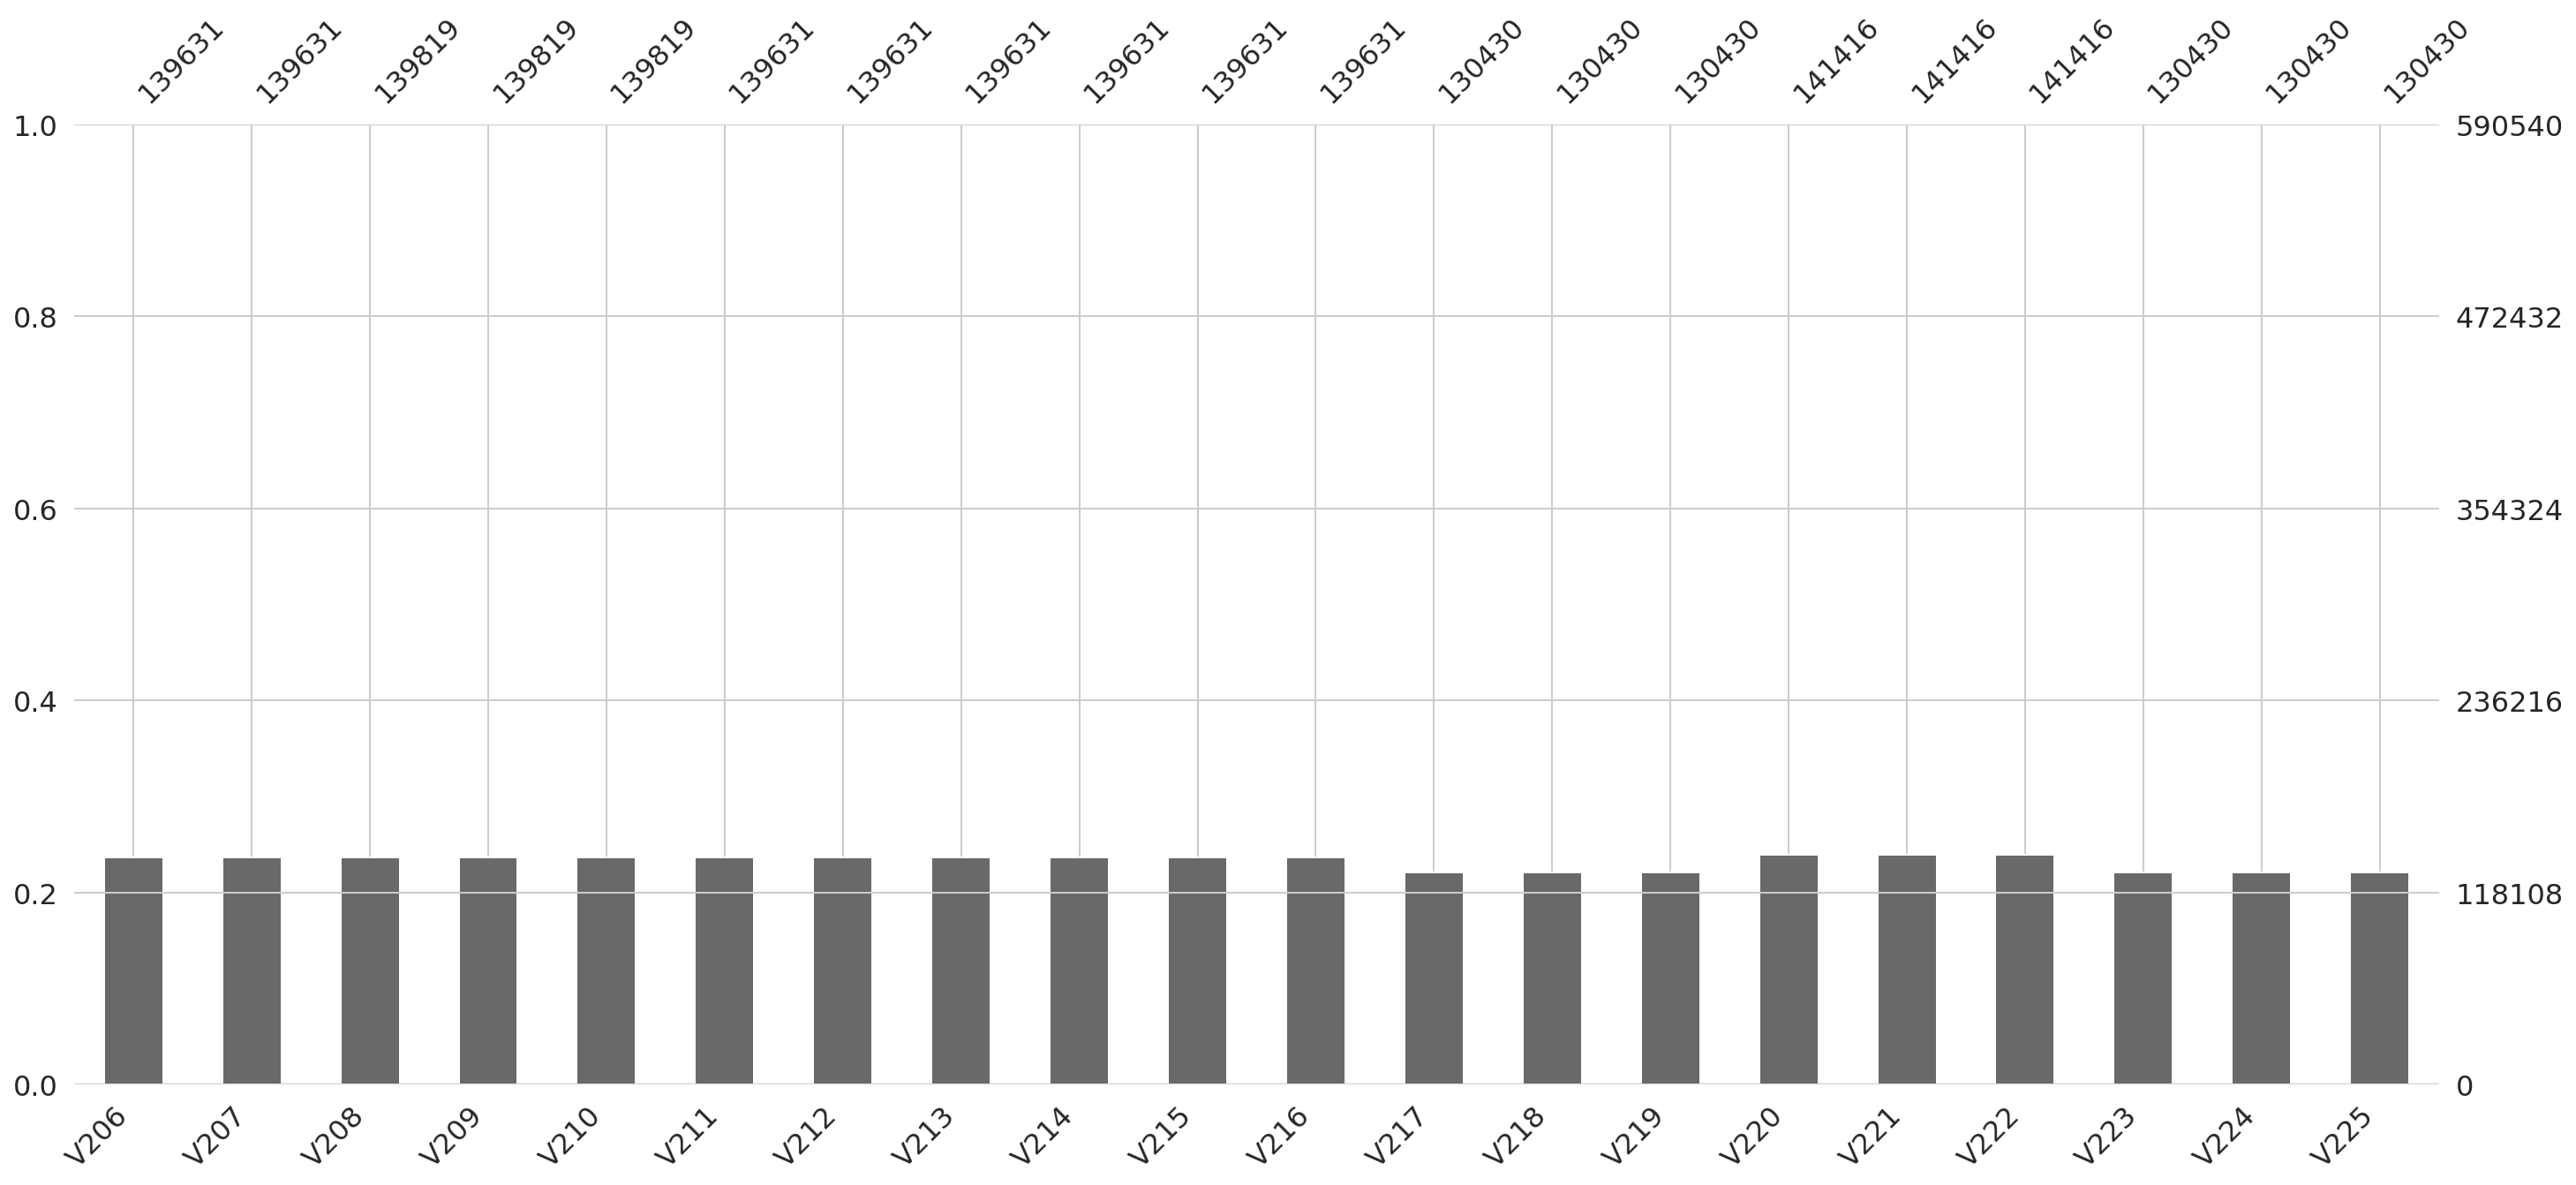

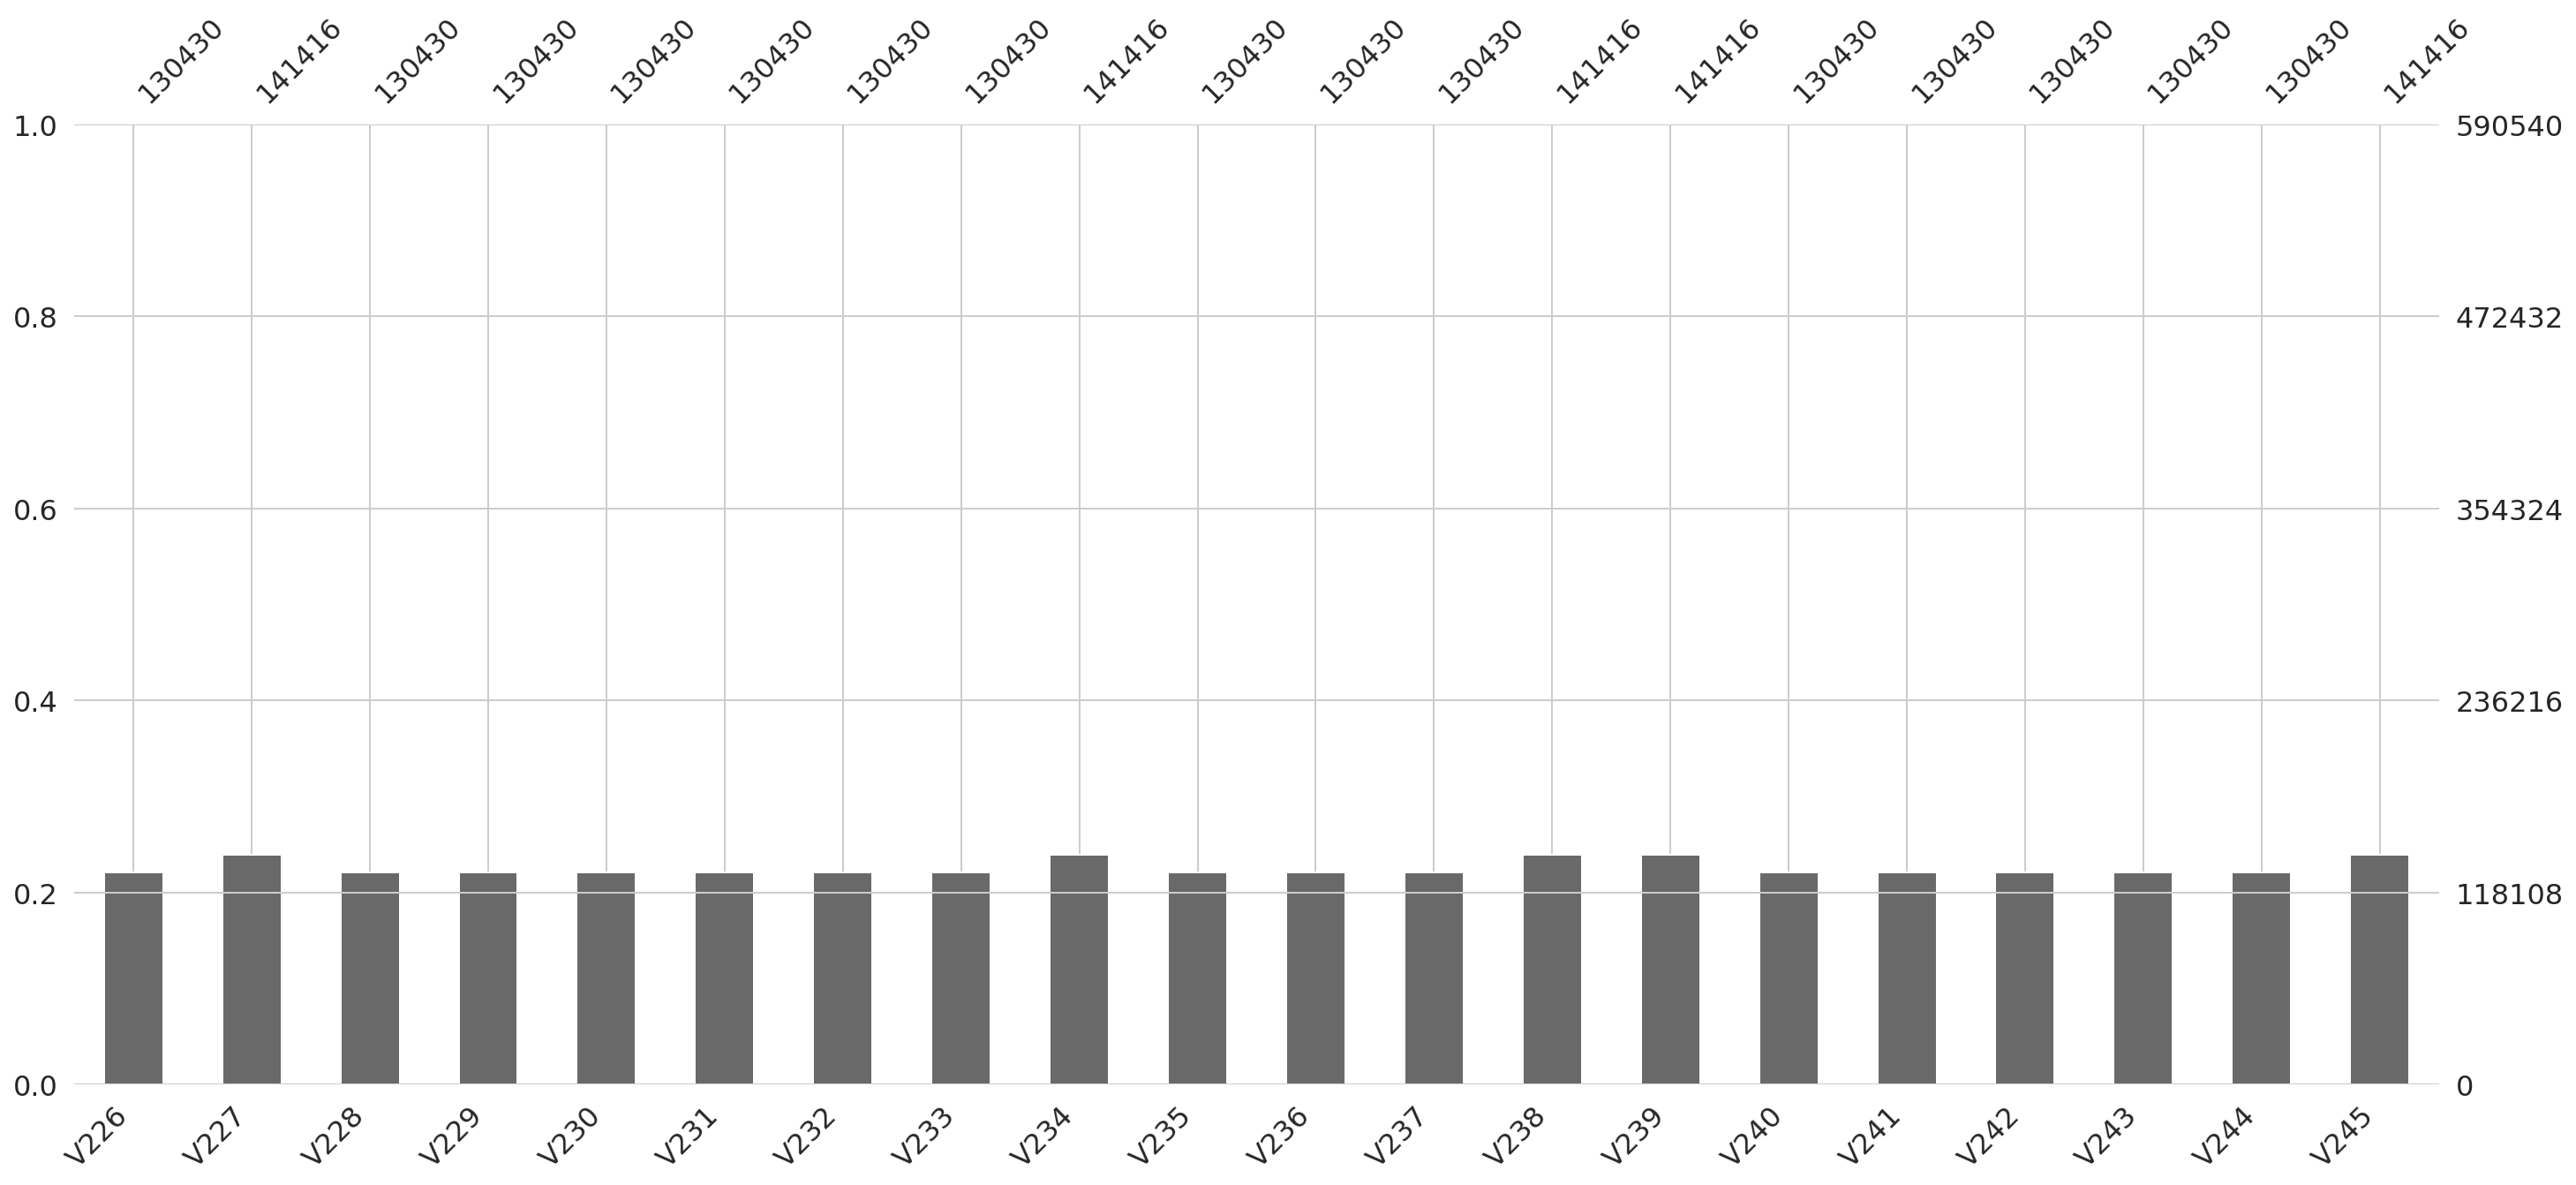

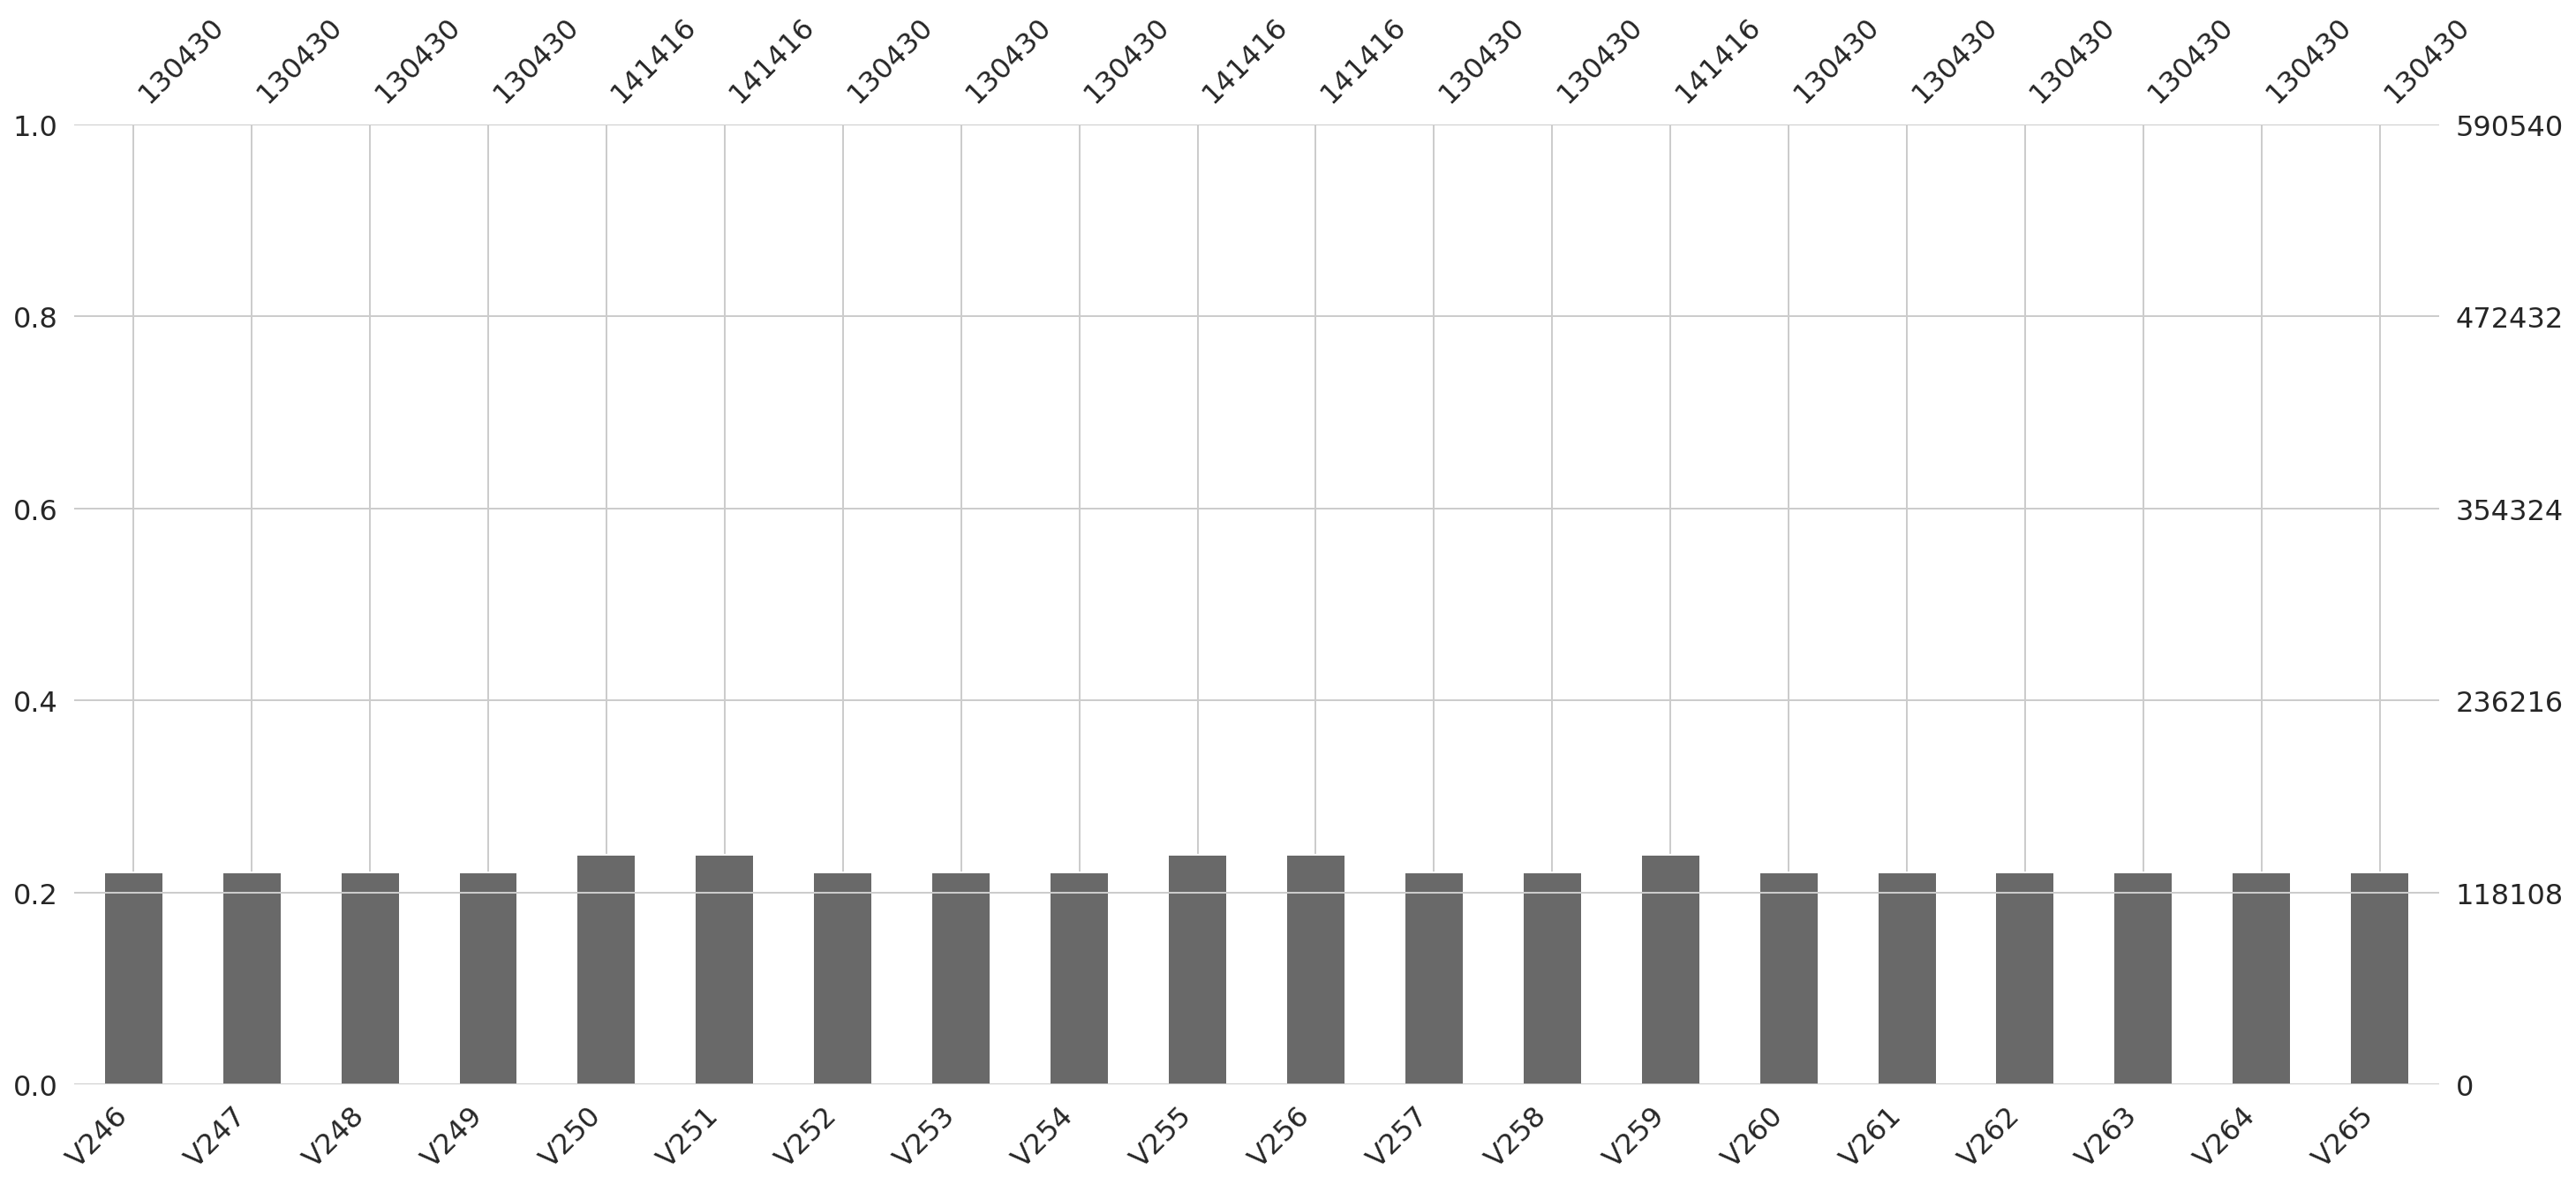

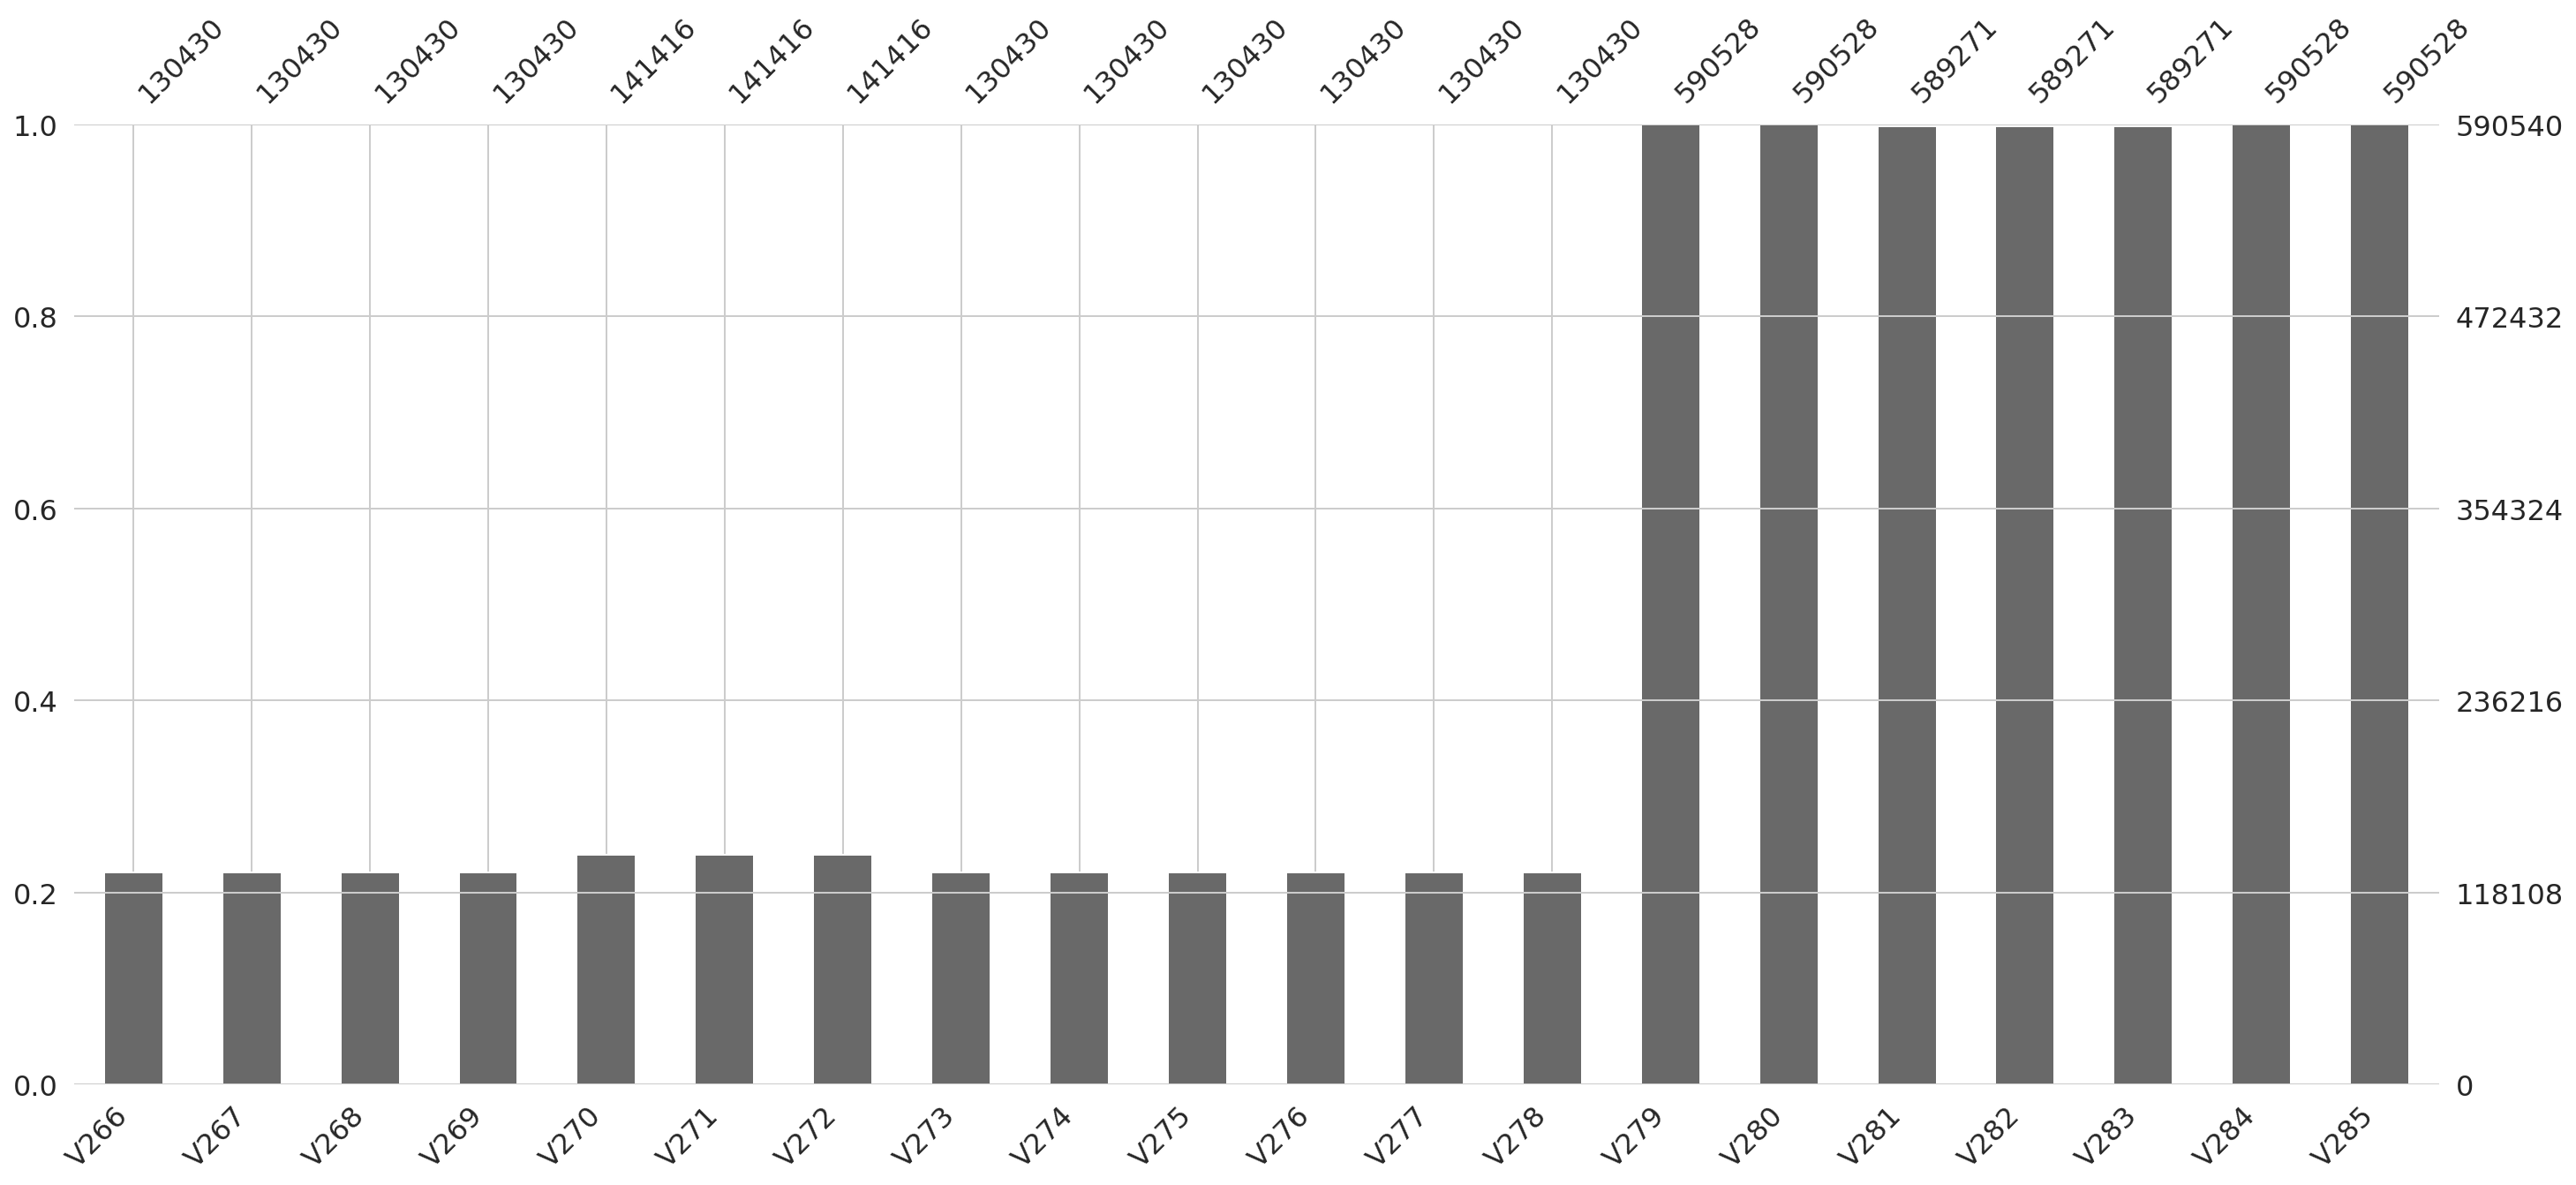

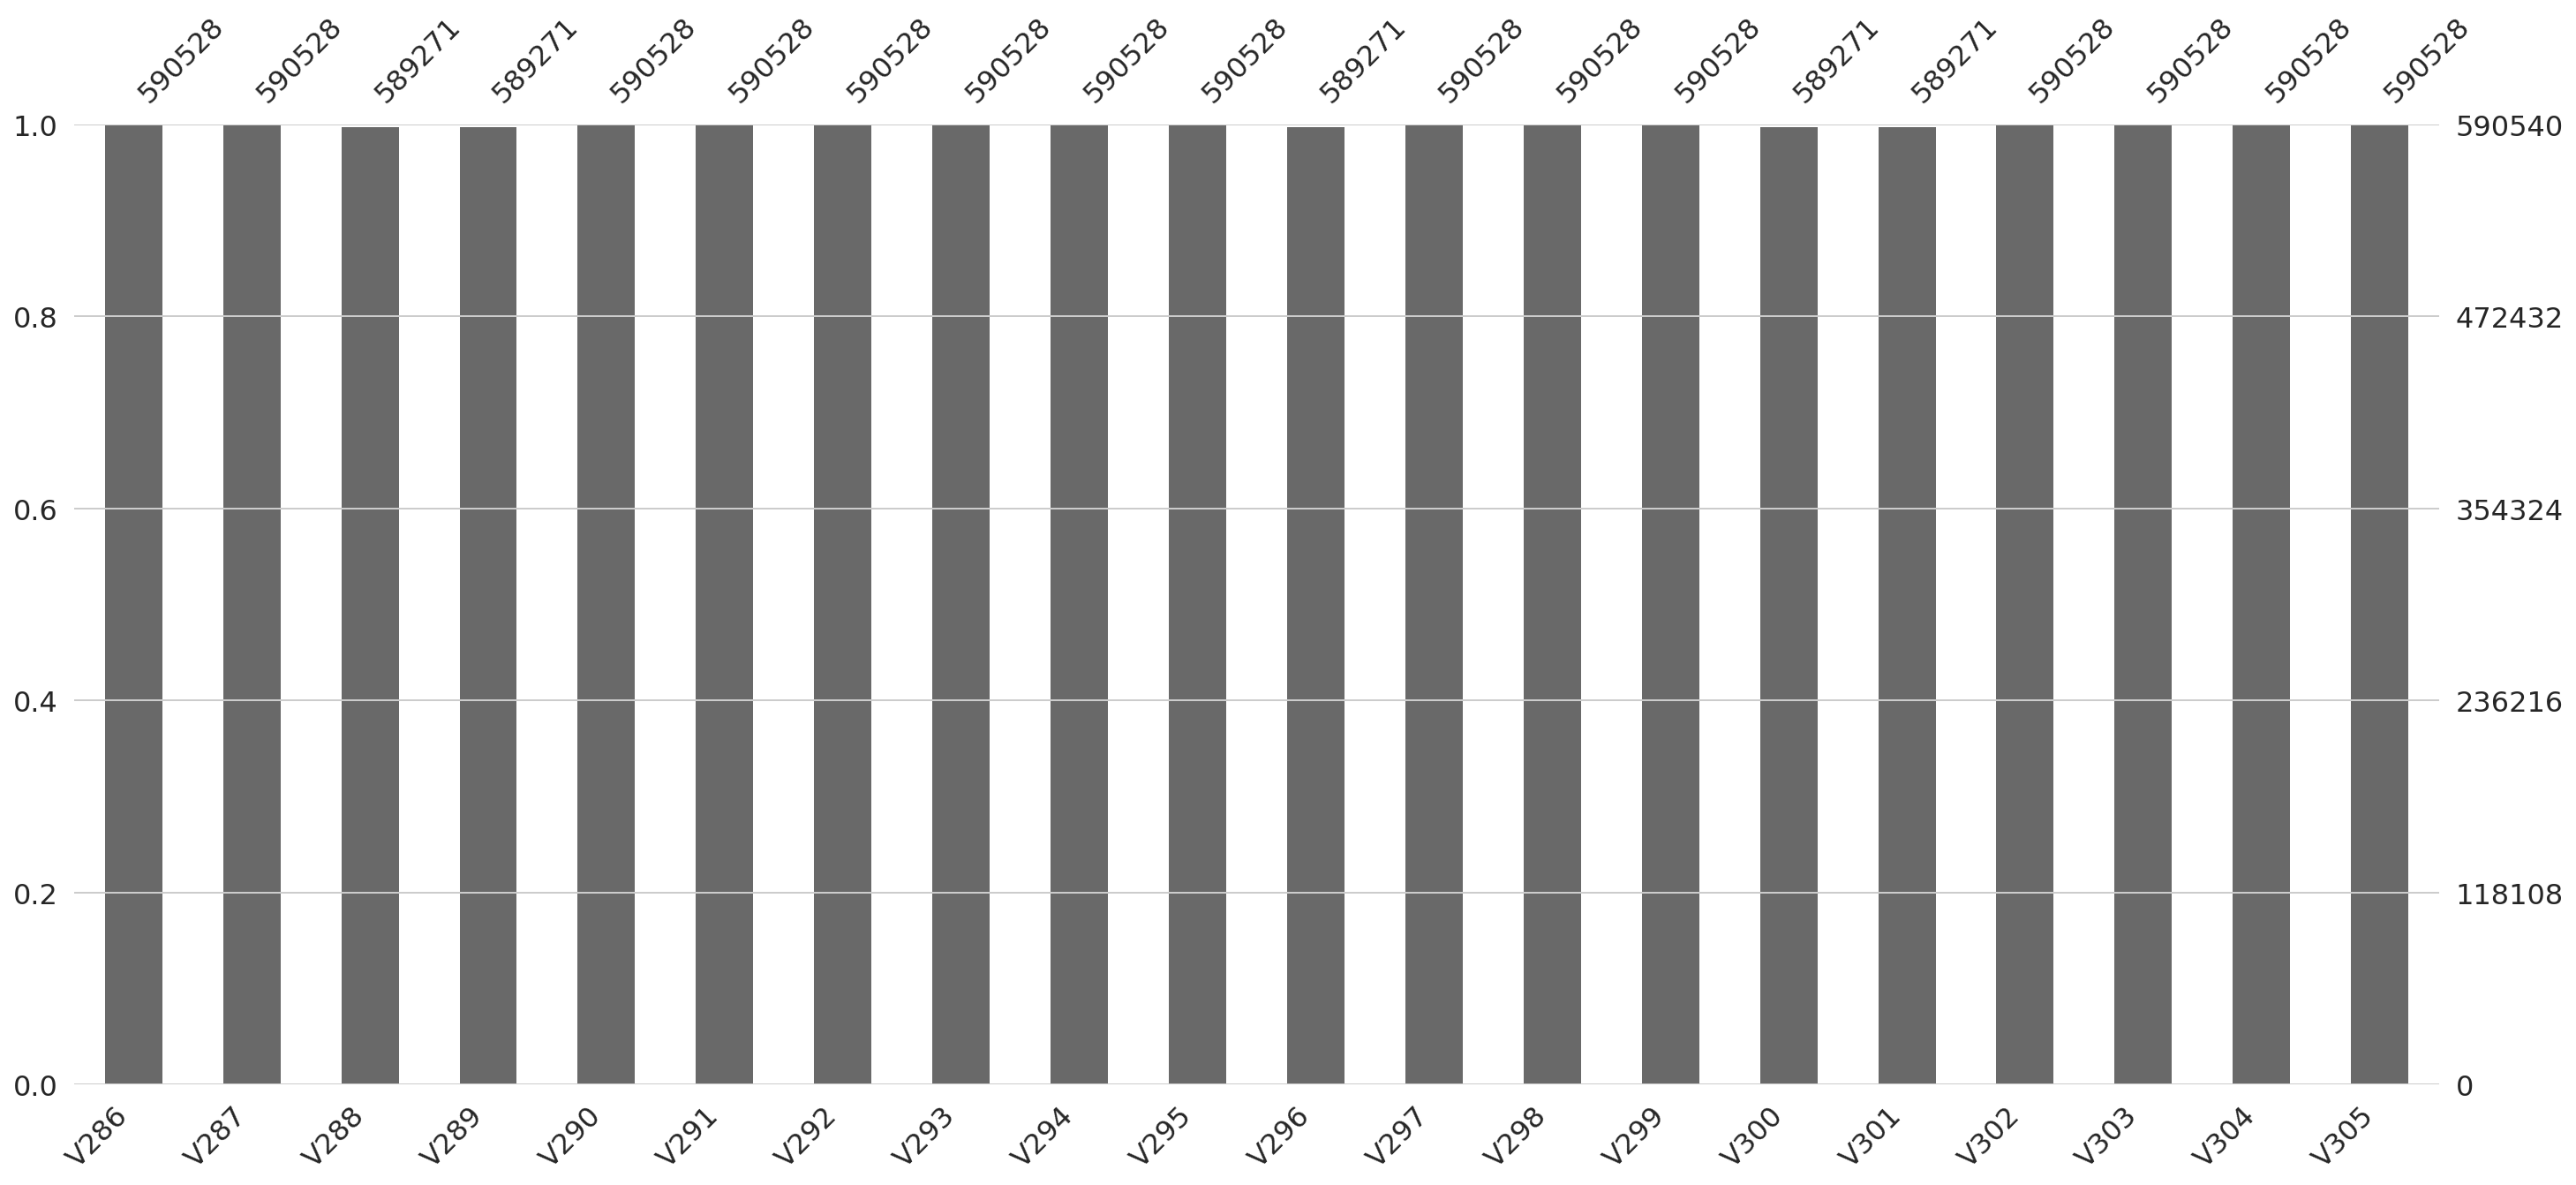

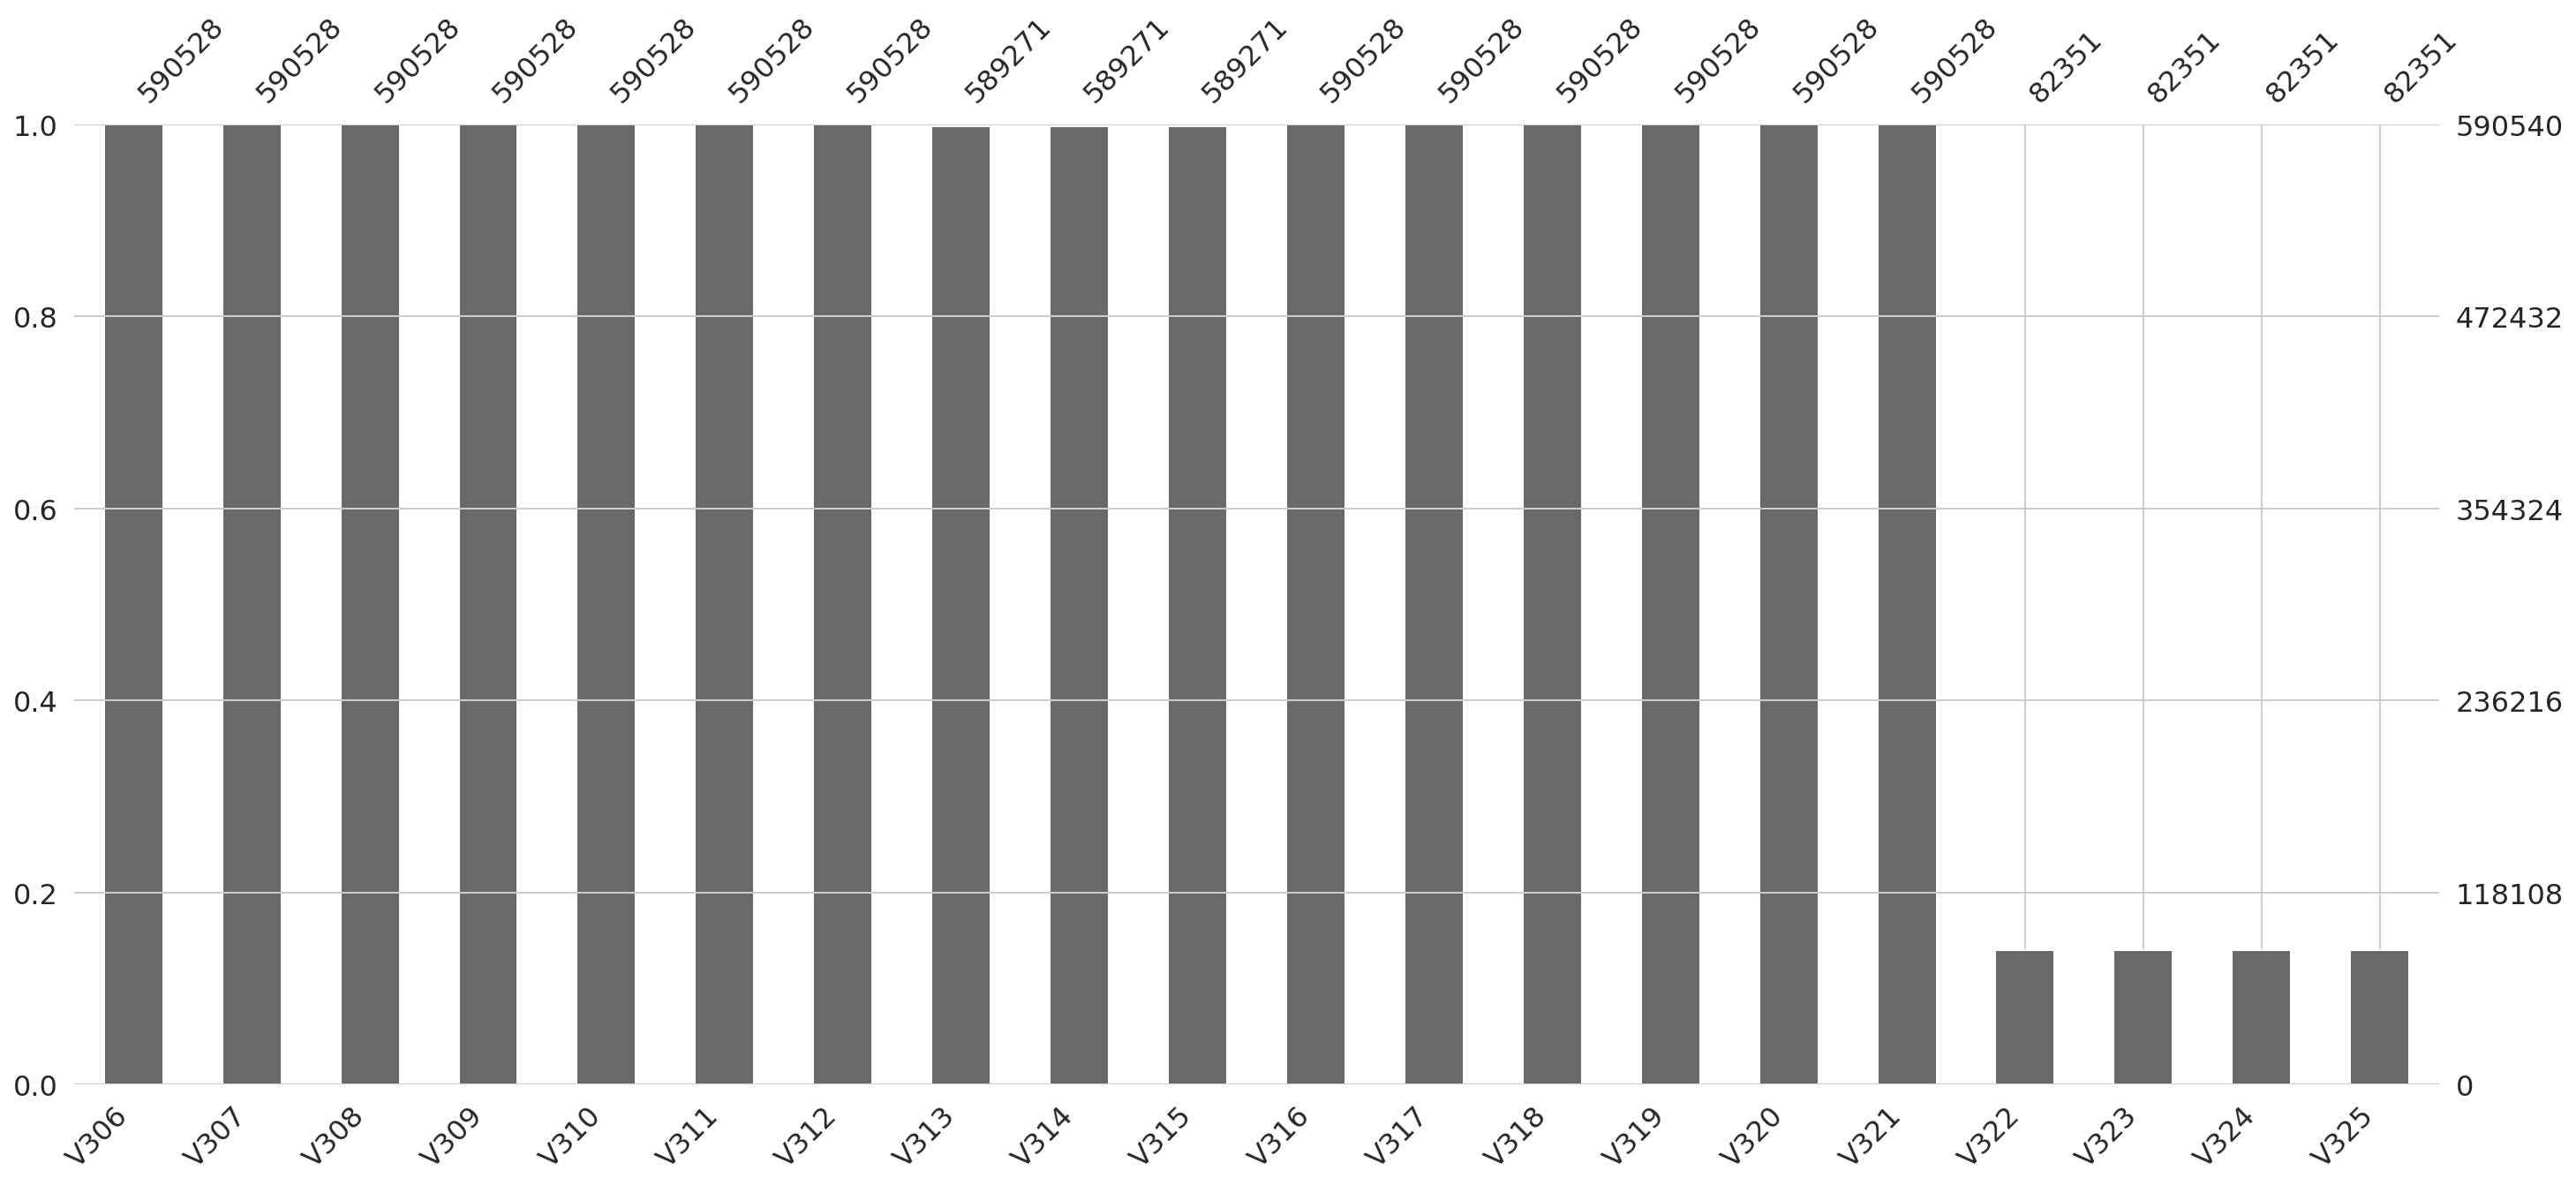

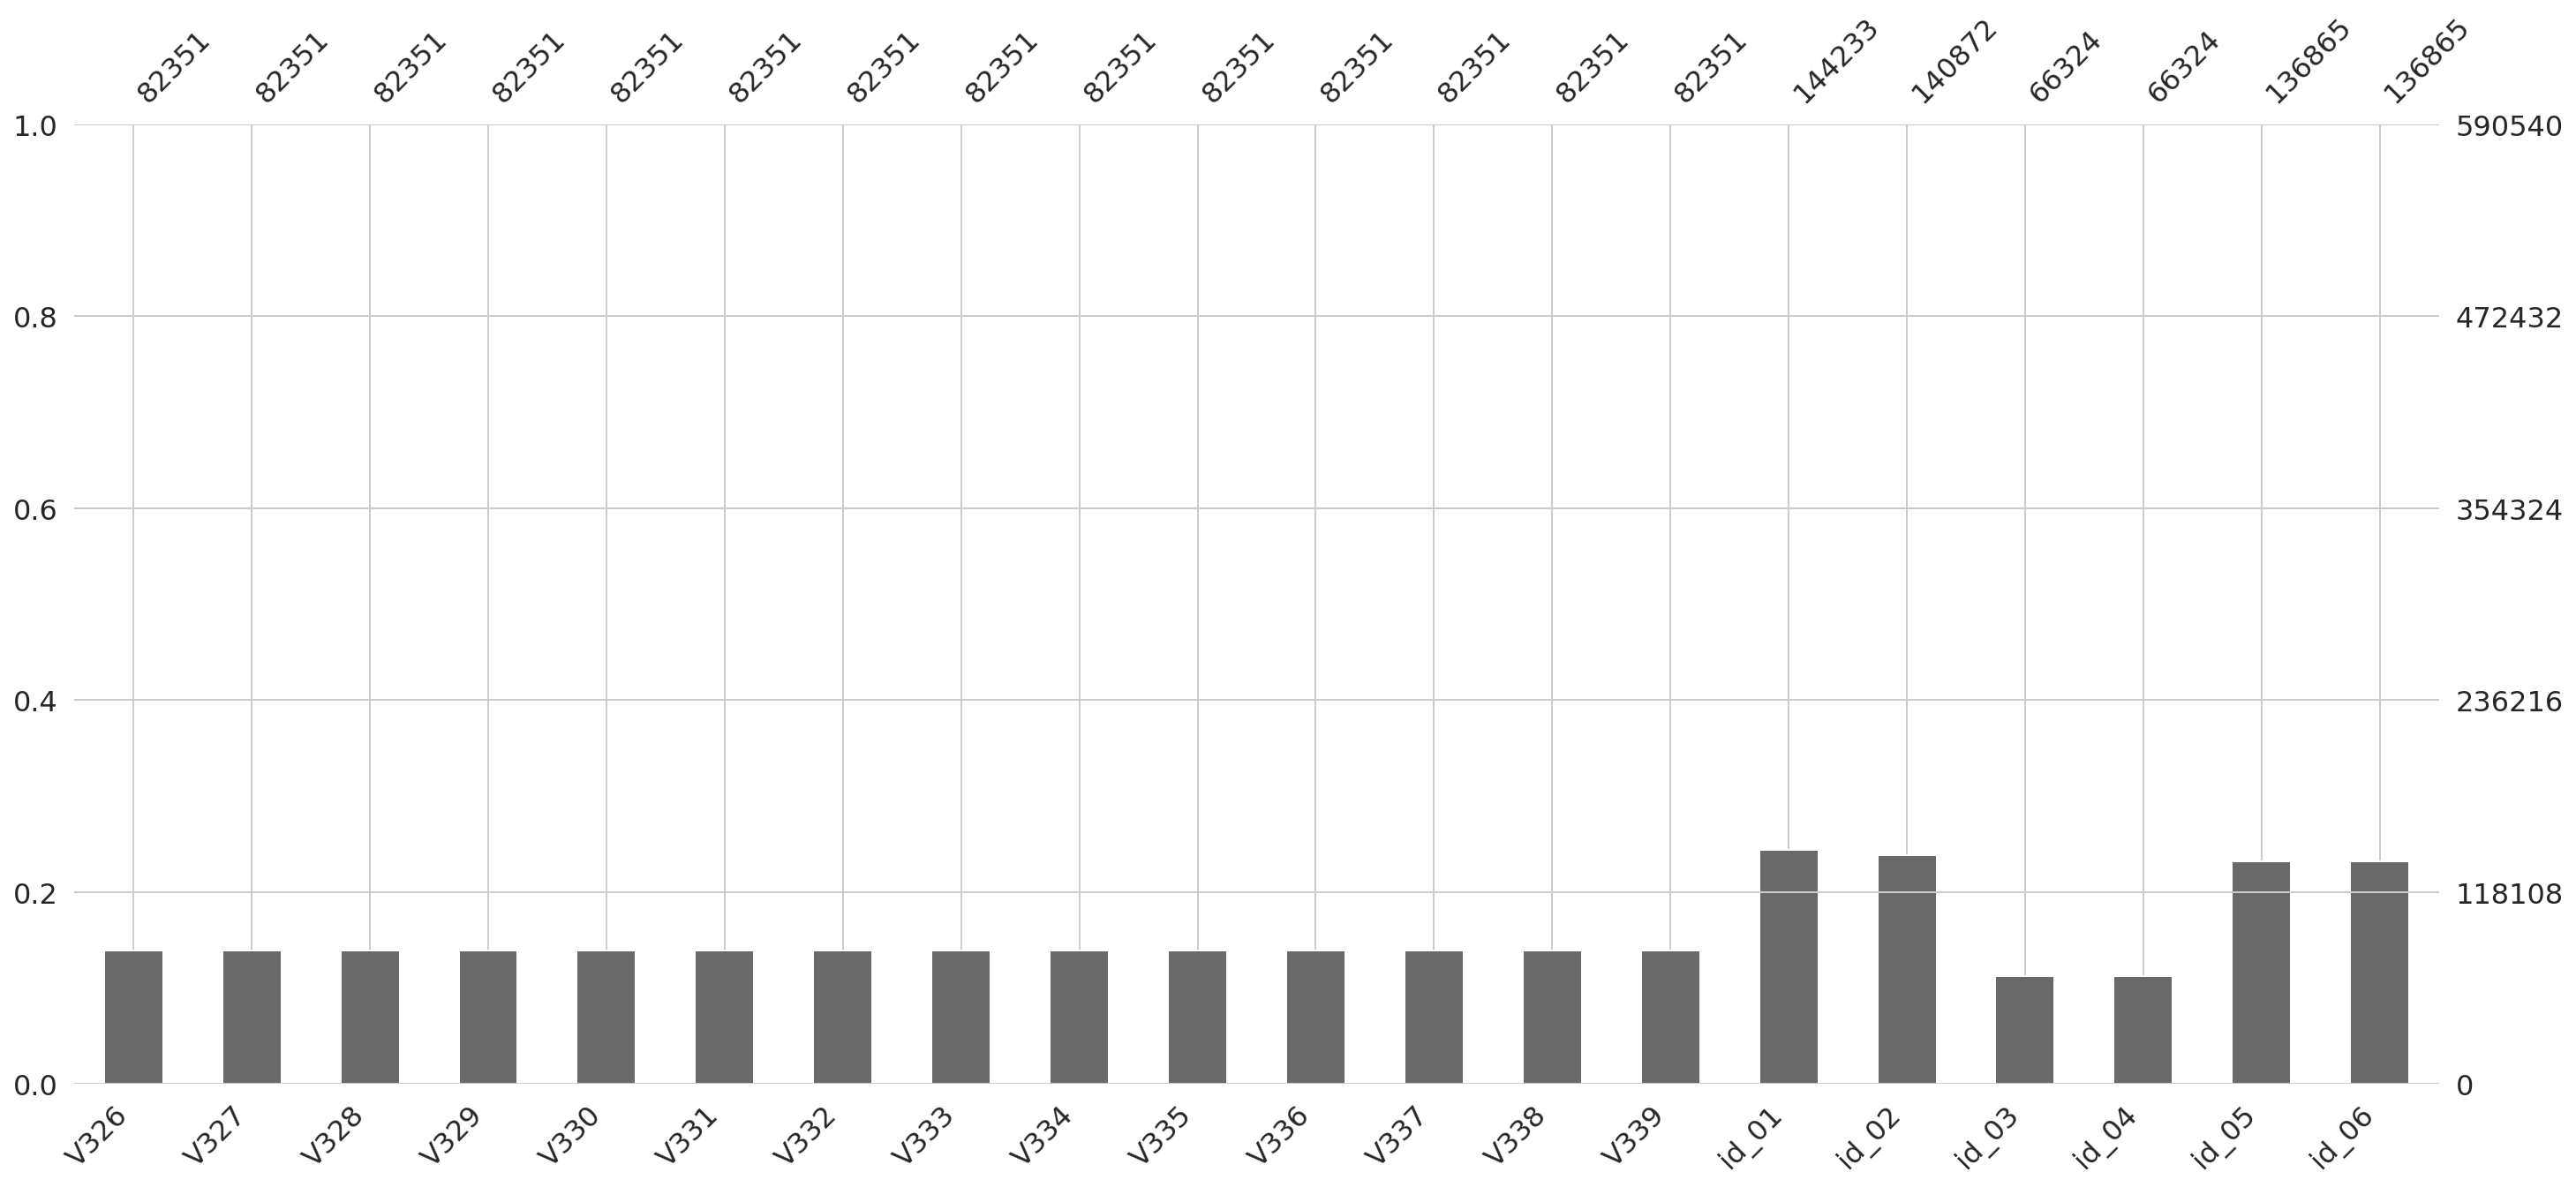

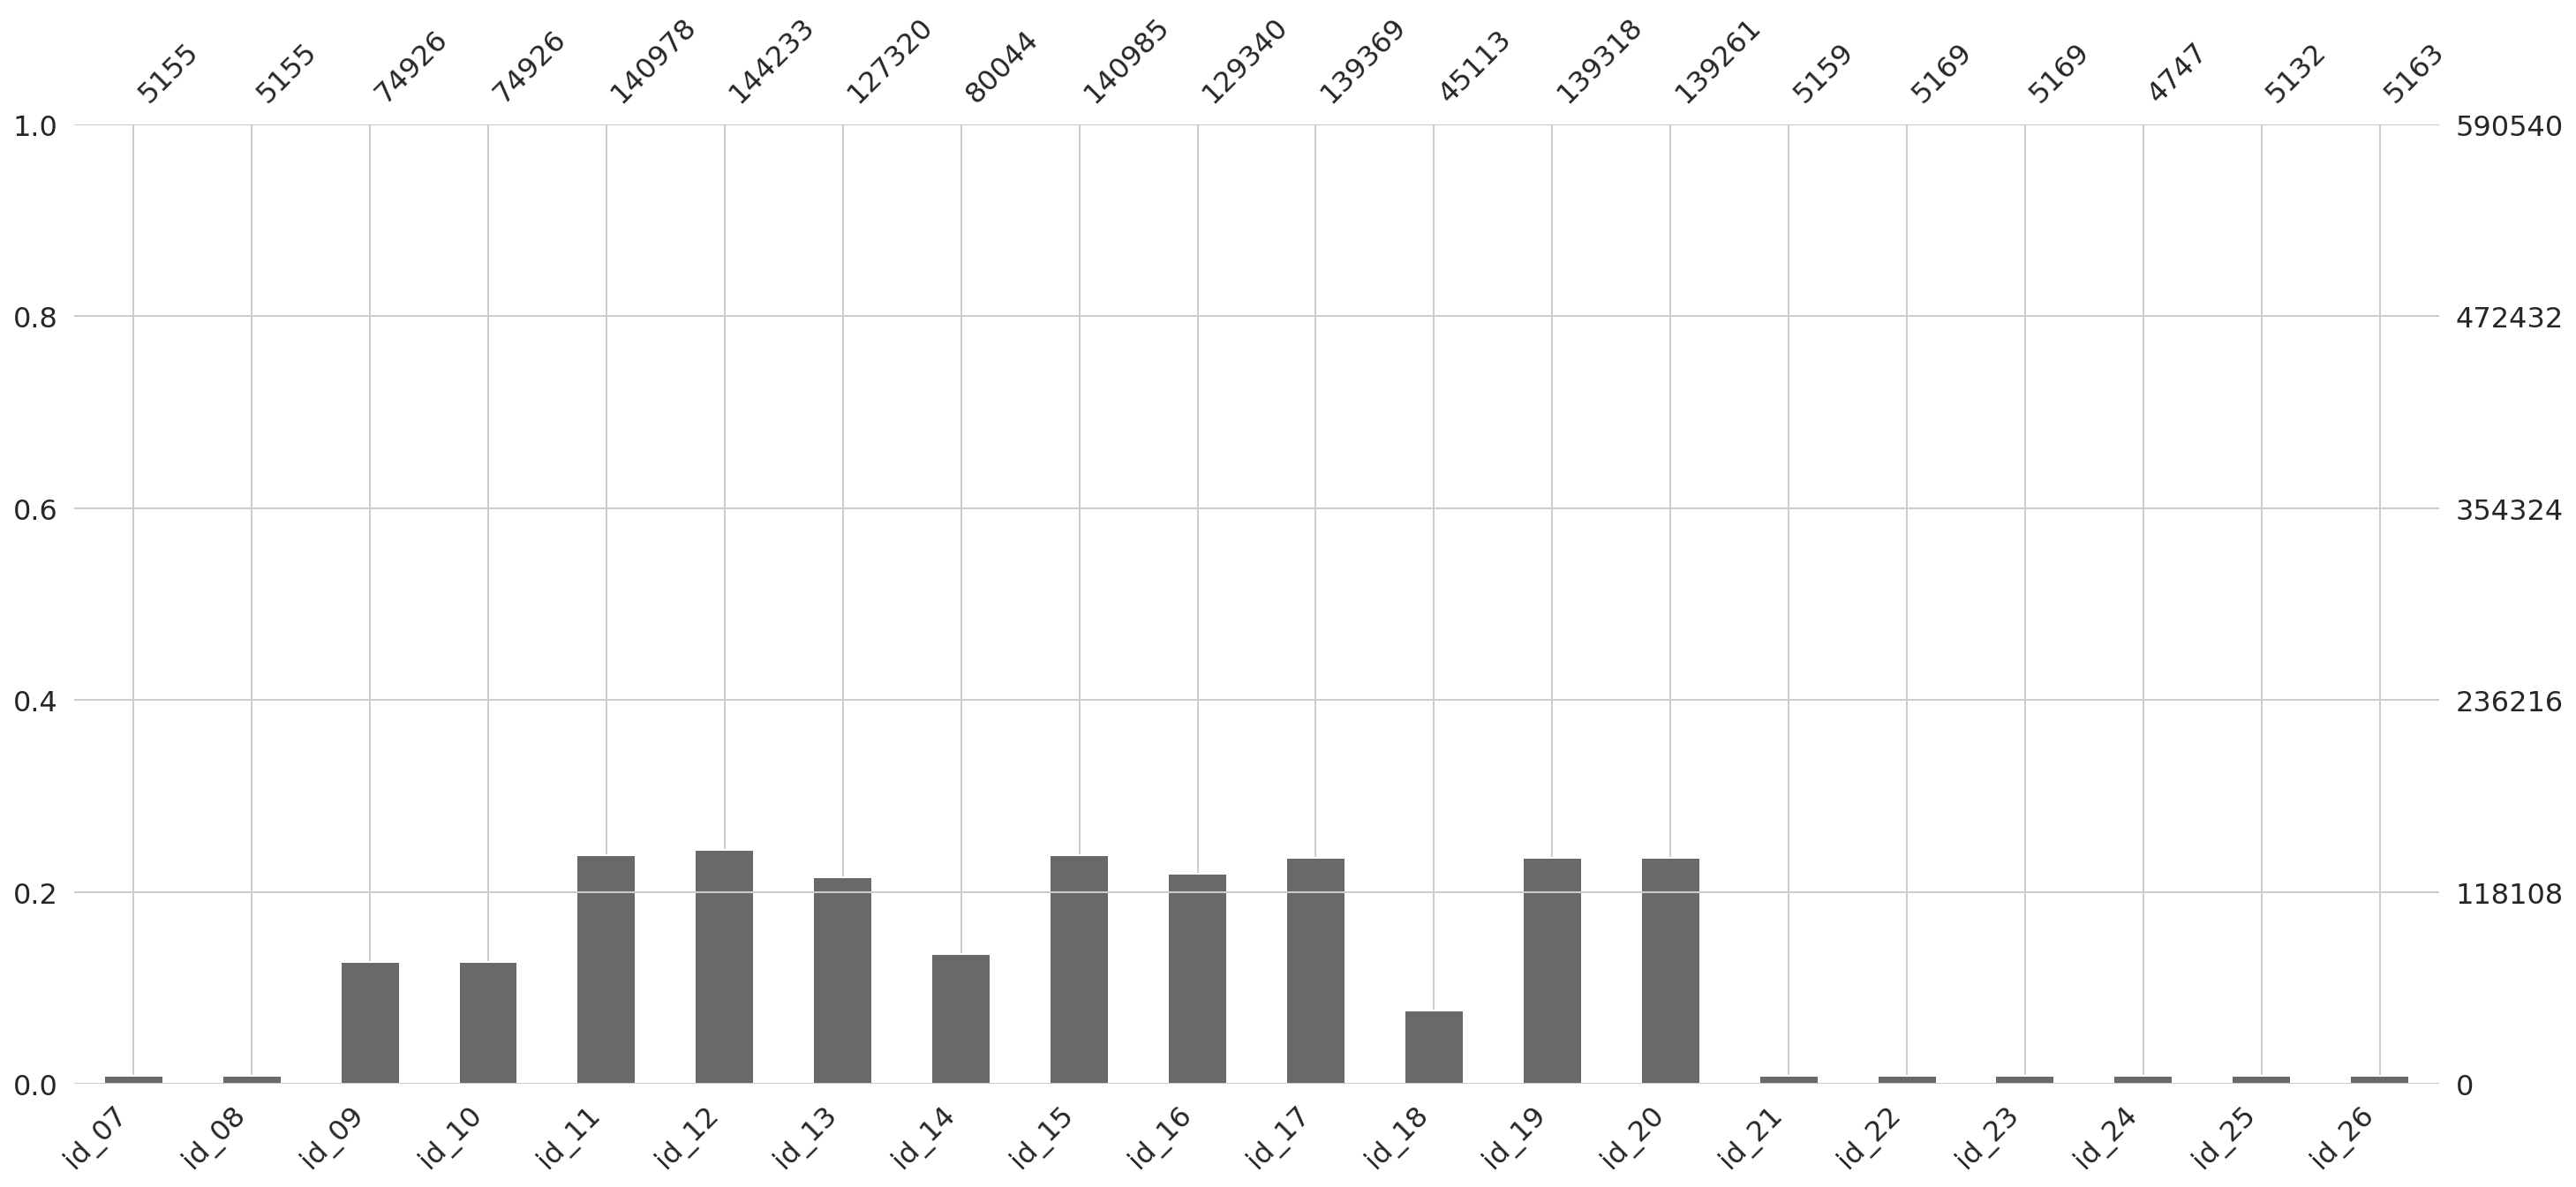

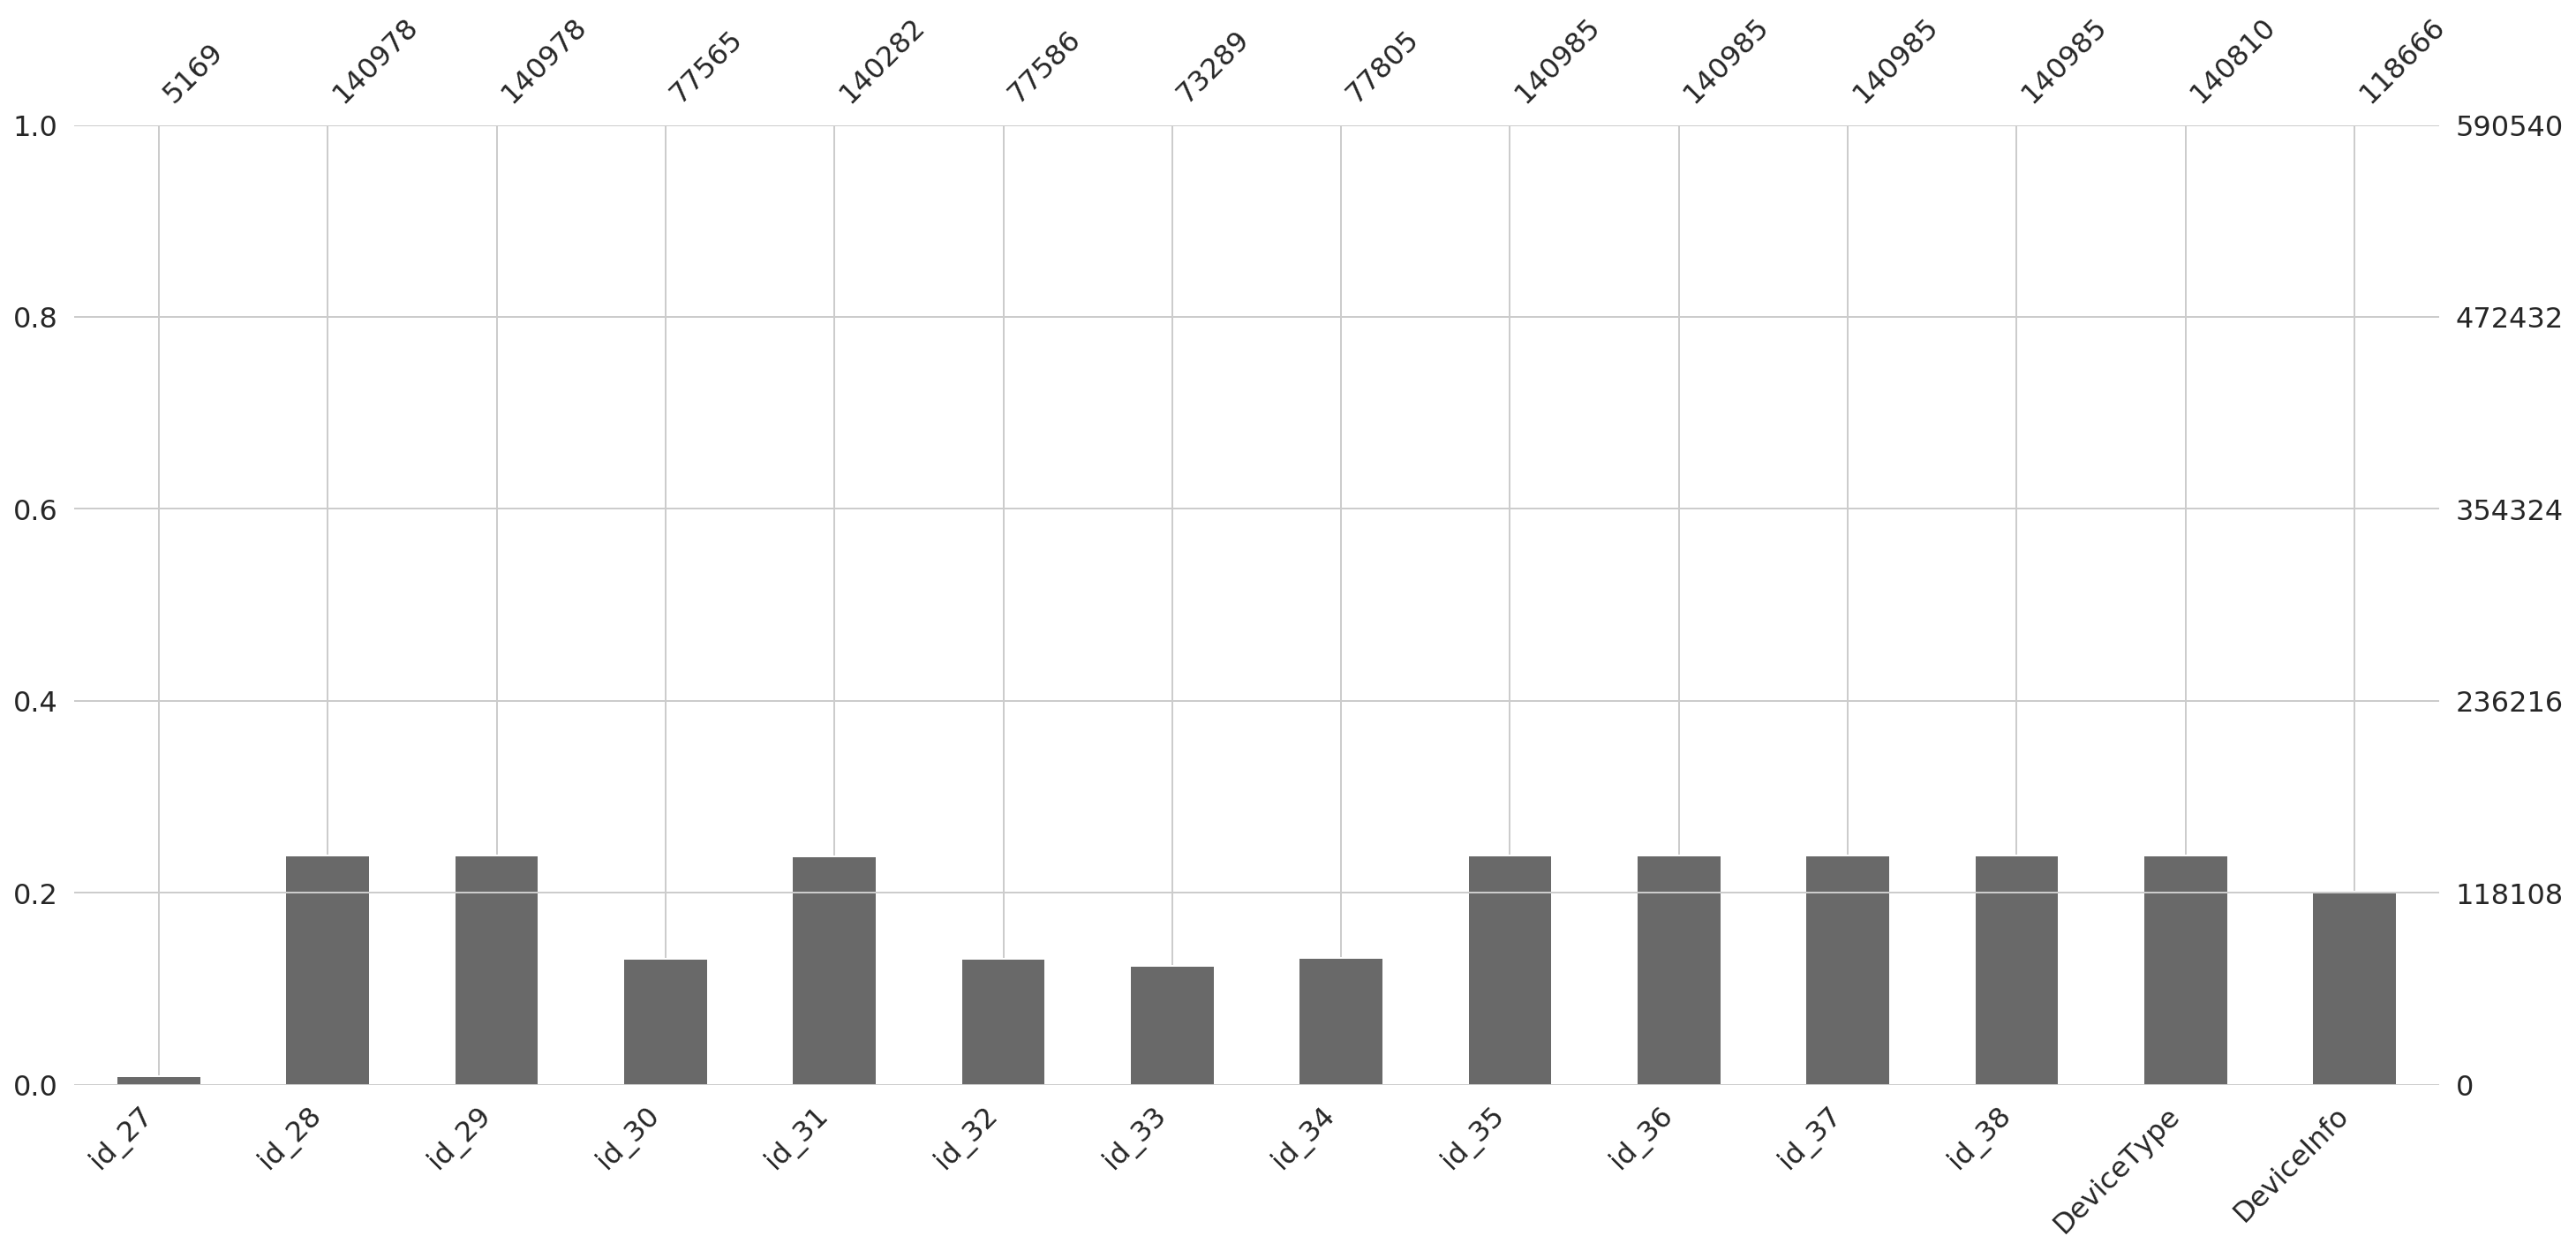

In [12]:
def list_chunks(initial_list: list, size: int = 20):
    """
    Generator for list chunks with equal size.
    
    :param initial_list: list to be divided into chunks.
    :param size: maximum size of each chunk.
    :yield: list chunk of maximum size `size`.
    """
    for x in range(0, len(initial_list), size):
        yield initial_list[x:x + size]


for columns in list_chunks(df.columns):
    msno.bar(df[columns])
    plt.show()

We can see that there are a lot of atributes with so many missing values (in some attributes, more that 50% are missing values). Those attributes should be dropped in preprocessing phase, or representative value should be filled in.

Because our method is based on using nature inspired algorithms for feature selection, maybe also attributes with majority of missing values will be used in modeling phase.

### Attributes analysis

In this section, we will analyze some of the attributes. From the dataset description, it is not clear what some concrete features are describing. Because of that, we will analyze just some features that can be interesting for prediction. Other features will be either analyzed in groups or just skipped (because we do not know meaning of some features and it is event not clear from values). But at the end, all features will be used/tried for prediction depending on preprocessing phase results.

*Some descriptions are taken from Kaggle description or discussions.*

In [96]:
def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param topn: number of top categories to be drawn.
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data, ax=ax)
    plt.xticks(rotation=ticks_rotation)

    
def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)


def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on boxplot.
    :param attribute: name of attribute to be drawn on boxplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

#### Transaction amount

At first, we will check the amount of transaction. Let's draw boxplot and kdeplot according to predicted attribute:

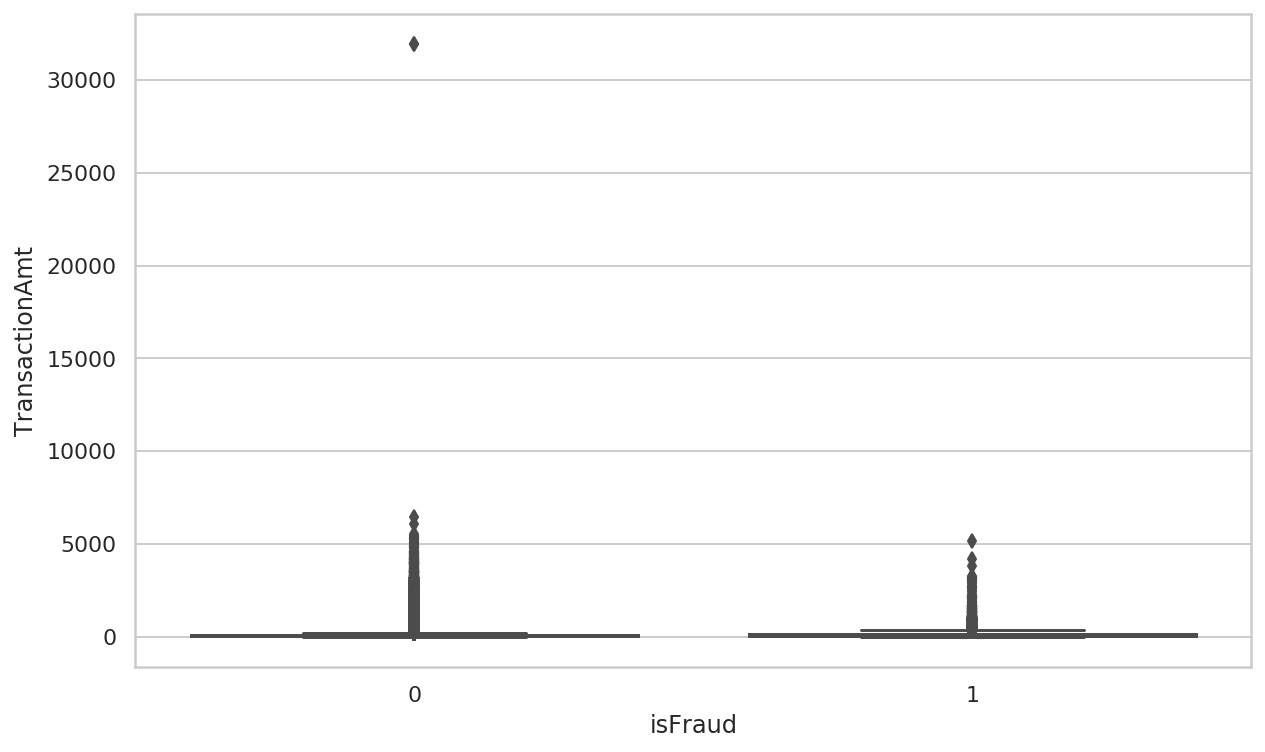

In [78]:
boxplot_per_classes(df, 'TransactionAmt', 'isFraud')

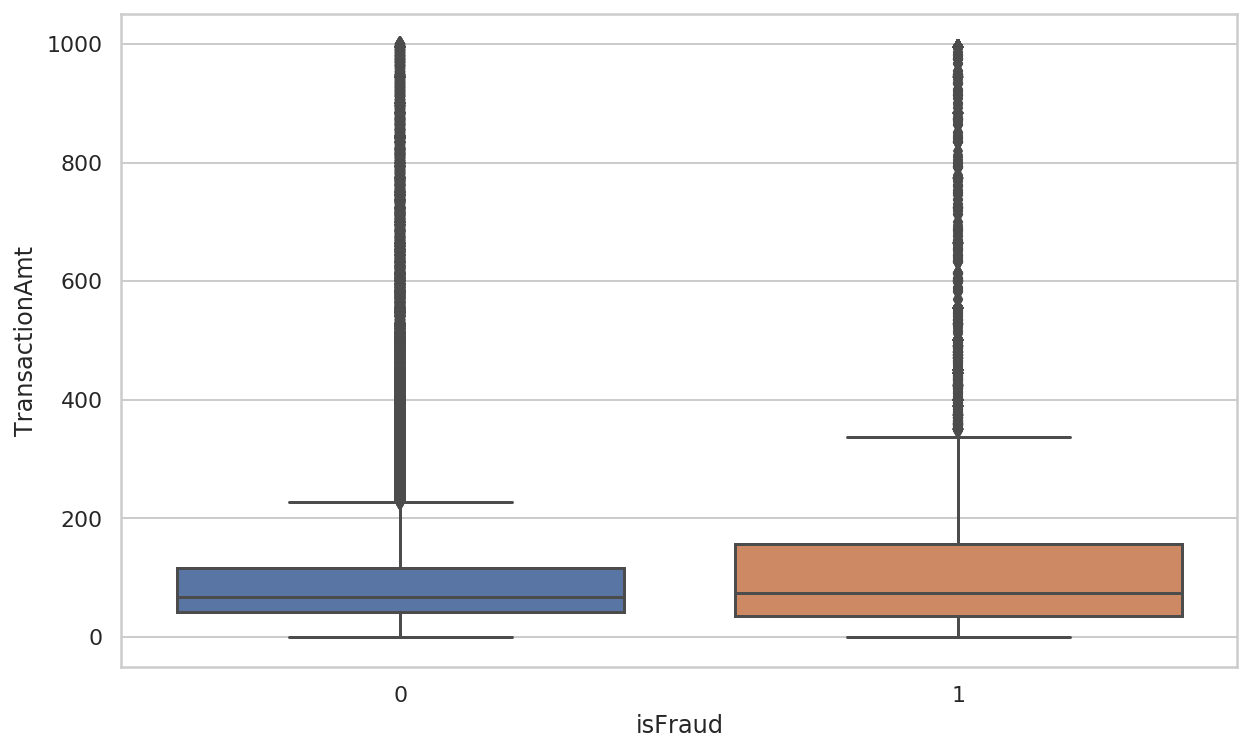

In [83]:
boxplot_per_classes(df[df.TransactionAmt < 1000], 'TransactionAmt', 'isFraud')

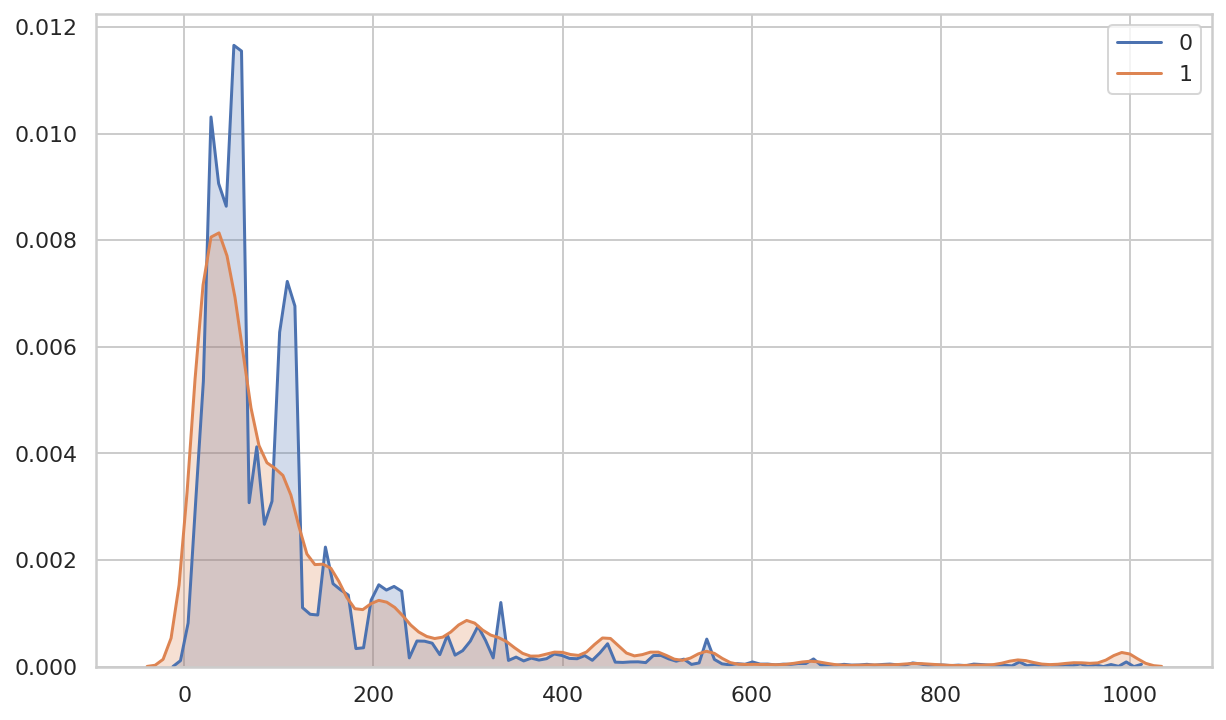

In [84]:
kdeplot_per_classes(df[df.TransactionAmt < 1000], 'TransactionAmt', 'isFraud')

It is hard to say if there is a significant difference between frauds and regular payments in transaction amount, but we will try to use this attribute. However, according to chosen classification algorithm we should be careful about outliers.

#### Product code

Product code can be interesting attribute for prediction. Let's check the product codes distribution according to predicted classes:

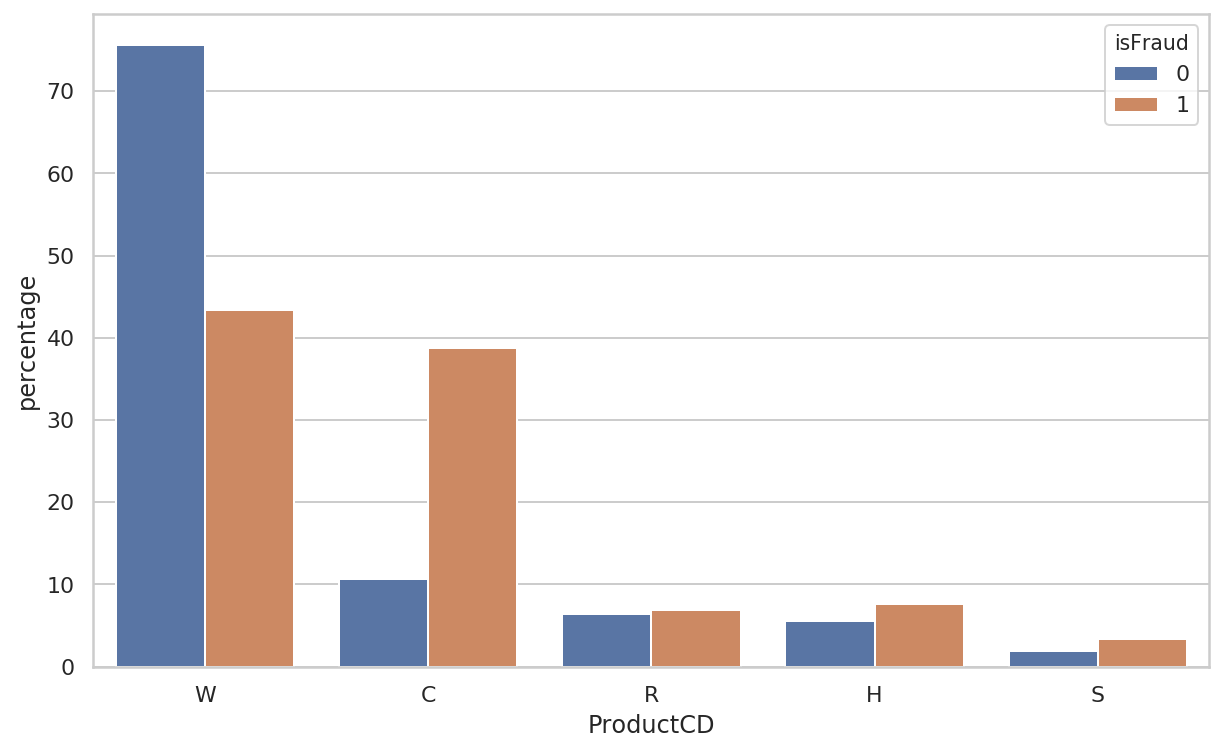

In [14]:
barplot_per_classes(df, 'ProductCD', 'isFraud')

As we can see from the plot, transactions of products with code `C` are likely to be fraudulent. This attribute definitely can help in detecting frauds.

#### Email attributes

Because there are a lot of unique values in email addresses columns (`P_emaildomain`, `R_emaildomain`), they can be aggregated into using domains only. That newly created attribute can be useful for prediction.

Probably, prefix `P` stands for purchaser and `R` for recipient.

In [15]:
def transform_email(value):
    """
    Transform email domains into domain names only.
    
    We have found in the data, that some email domains 
    are repeated (e.g. `gmail` and `gmail.com`). 
    
    :param value: .
    :return: transformed email domain.
    """
    if value is np.nan:
        return value
    return value.split('.')[0]

In [16]:
email_attributes = ['P_emaildomain', 'R_emaildomain']

for email_attribute in email_attributes:
    df[f'{email_attribute}_transformed'] = df[email_attribute].apply(lambda x: transform_email(x))

How many unique values are there after preprocessing?

In [17]:
len(df.P_emaildomain_transformed.unique()), len(df.R_emaildomain_transformed.unique())

(45, 46)

Because there is a lot of unique values, only top 10 classes will be plotted.

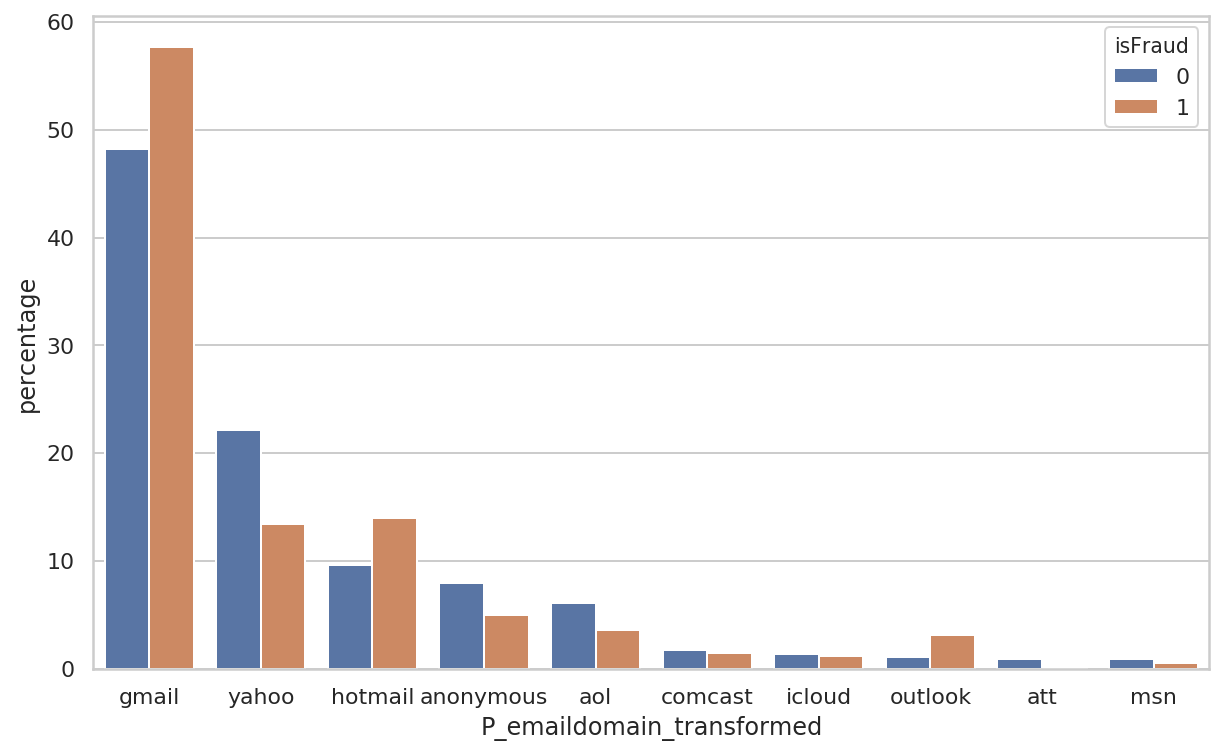

In [18]:
barplot_per_classes(df, 'P_emaildomain_transformed', 'isFraud', topn=10)

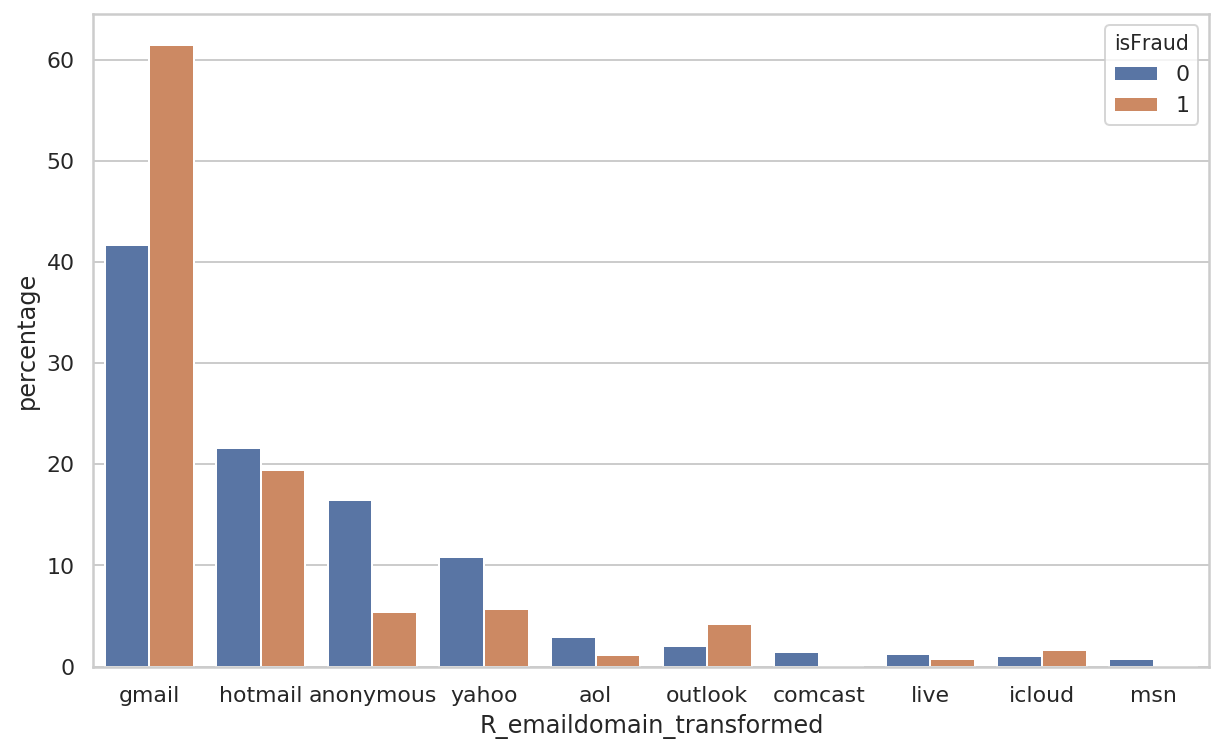

In [19]:
barplot_per_classes(df, 'R_emaildomain_transformed', 'isFraud', topn=10)

From both plots, we can see that some domains are more typical for fraud transactions. Because there is a lot of unique values, too small classes should be grouped into one `other` class during preprocessing.

#### Card attributes

According to dataset source (at Kaggle), attributes `card1`-`card6` are all categorical. Attributes store various information about payment card, such as card type, card category, issue bank, country, etc.

Let's check, how many unique values are there for each attribute:

In [20]:
for x in range(6):
    unique_count = len(df[f'card{x + 1}'].unique())
    print(f'Count of unique values for attribute card{x + 1}: {unique_count}')

Count of unique values for attribute card1: 13553
Count of unique values for attribute card2: 501
Count of unique values for attribute card3: 115
Count of unique values for attribute card4: 5
Count of unique values for attribute card5: 120
Count of unique values for attribute card6: 5


Most of card attributes have too many unique values. For attributes `card1`, `card2`, `card3` and `card5`, we will plot only top n classes by samples count (depending on attribute). 

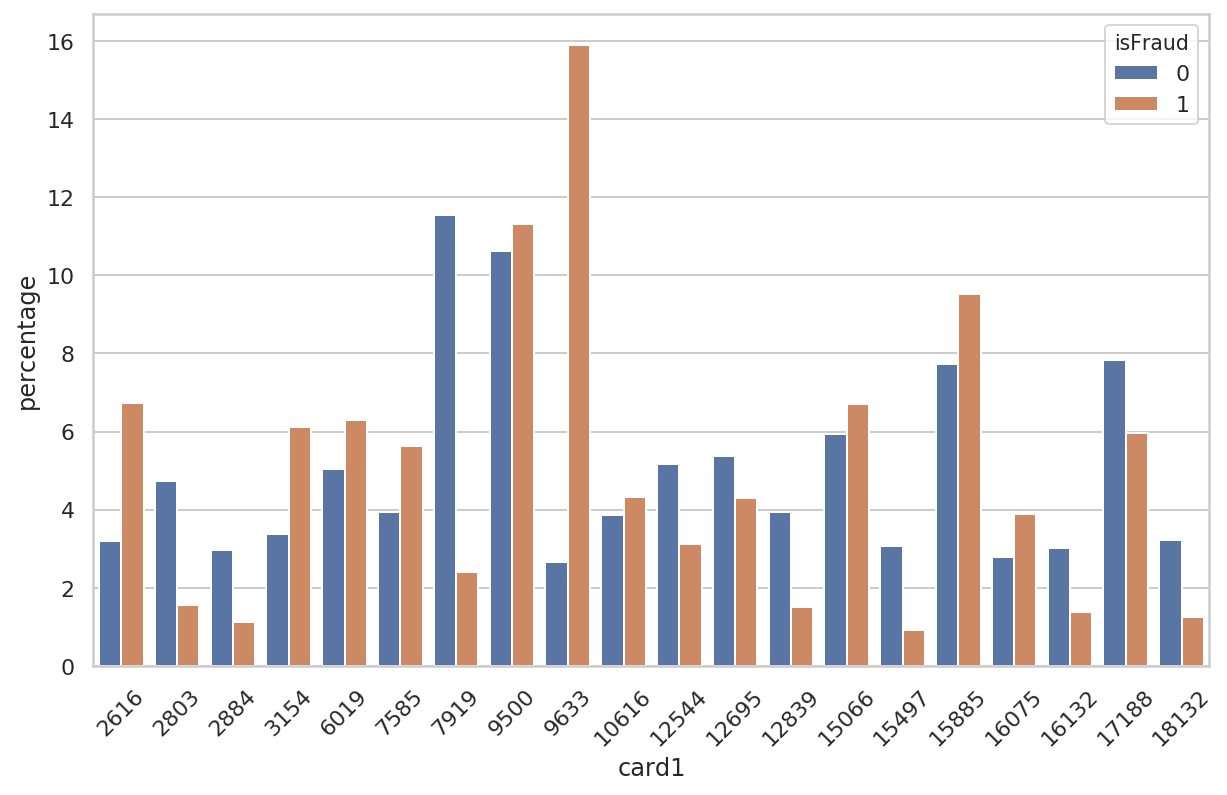

In [21]:
barplot_per_classes(df, 'card1', 'isFraud', topn=20, ticks_rotation=45)

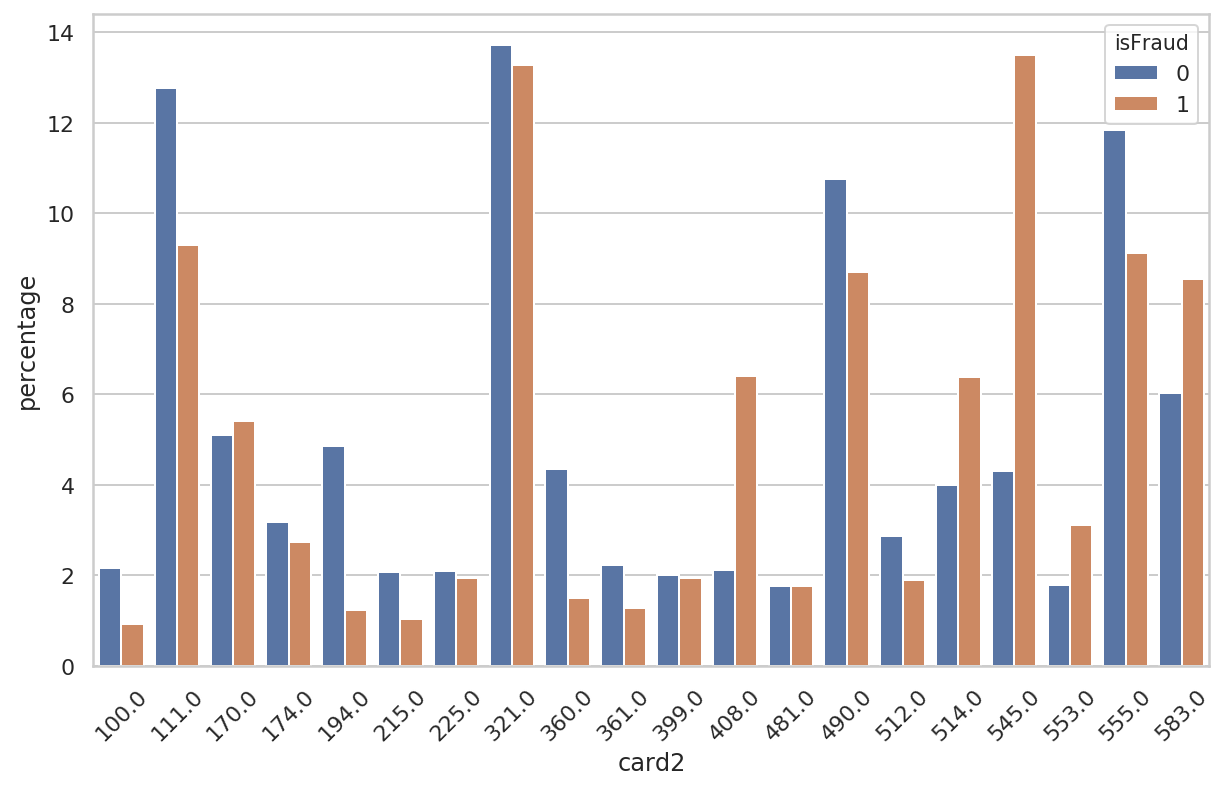

In [22]:
barplot_per_classes(df, 'card2', 'isFraud', topn=20, ticks_rotation=45)

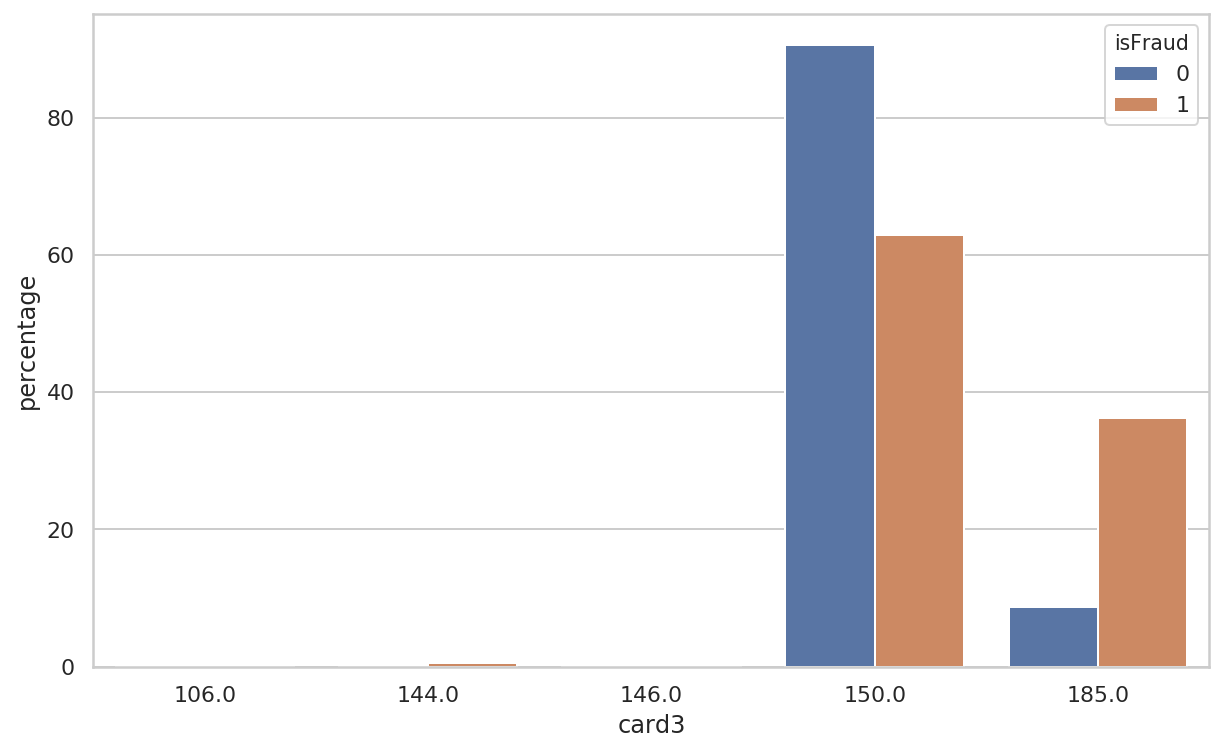

In [23]:
barplot_per_classes(df, 'card3', 'isFraud', topn=5)

Even though `card3` attribute has over 100 unique values, there are 2 major classes. The difference through label (`isFraud`) distribution looks significant and so it can be useful for prediction.

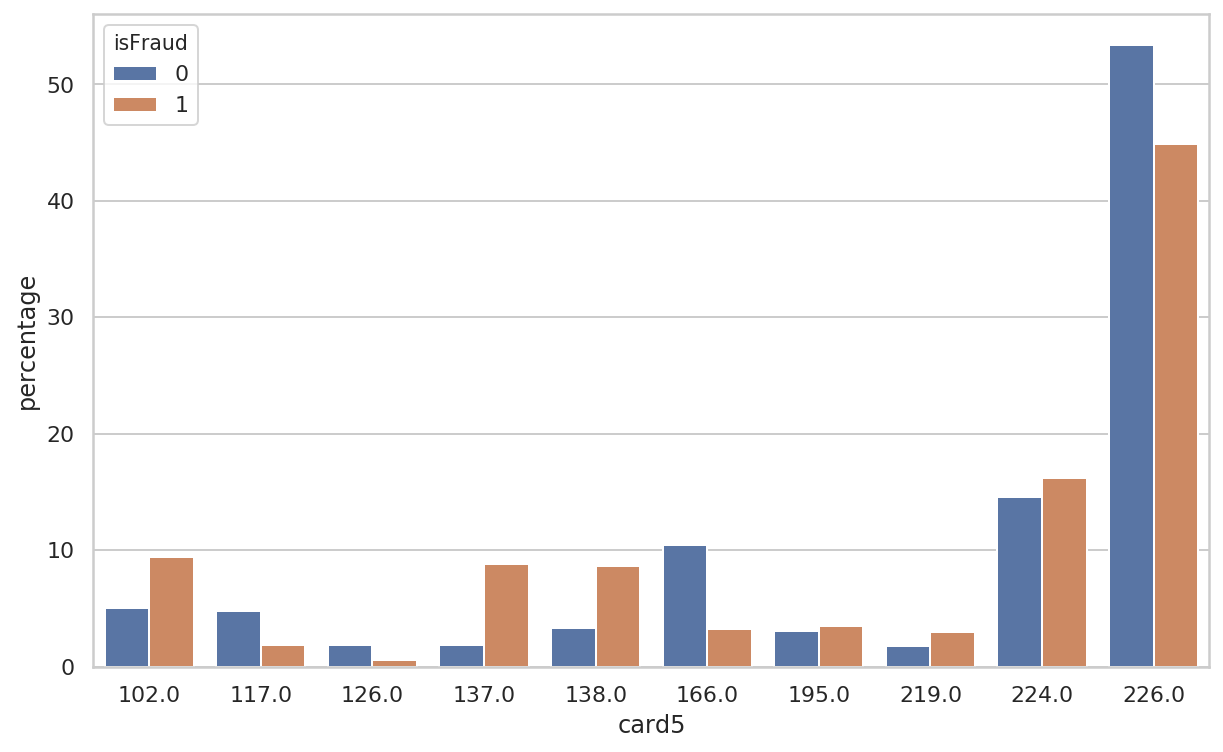

In [24]:
barplot_per_classes(df, 'card5', 'isFraud', topn=10)

And now, also let's check `card4` and `card6` attributes with only 5 unique values:

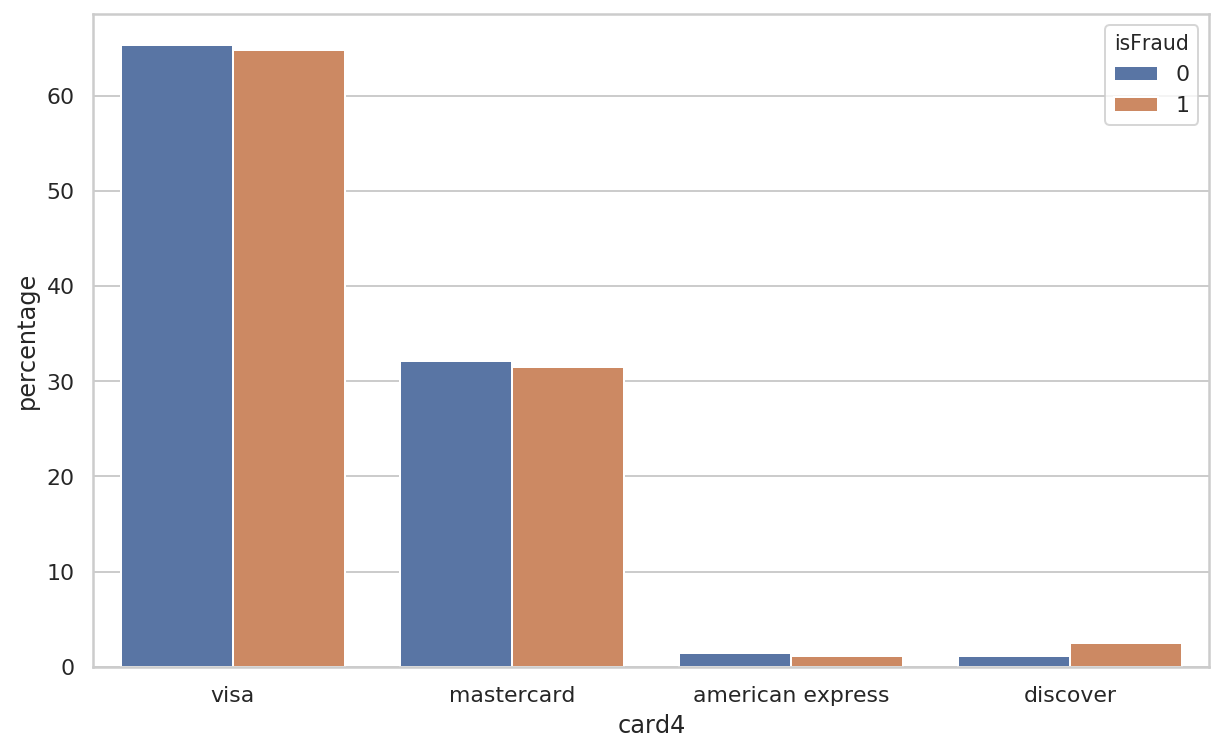

In [25]:
barplot_per_classes(df, 'card4', 'isFraud')

As we can see, `card4` is the mark of credit card. However, it looks like there is no sinificant difference between predicted classes in this attribute.

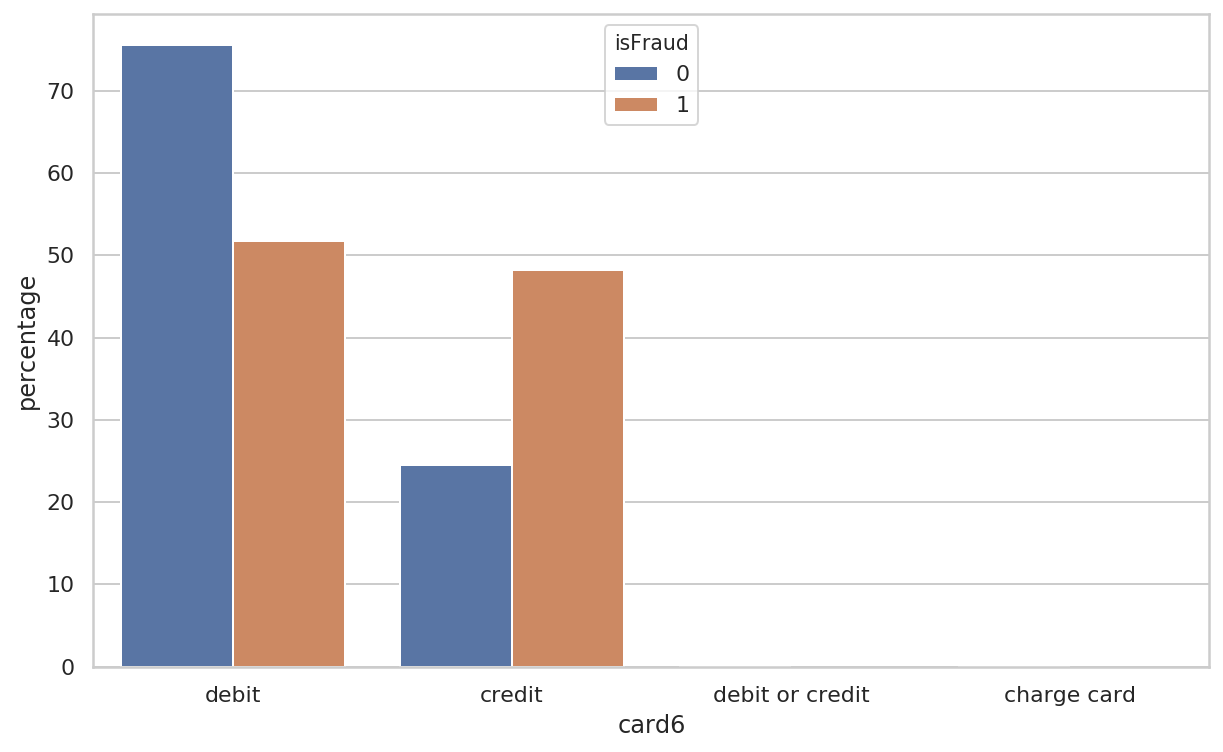

In [26]:
barplot_per_classes(df, 'card6', 'isFraud')

Last attribute is `card6`, showing type of the card (debit or credit). We can see from plot, that credit card are used for frauds more often.

#### Device attributes

From first view of data, we could see there are also attributes that describe device of payment. Let's look at them closer.

First attribute is `DeviceType` - whether it is mobile or computer (desktop):

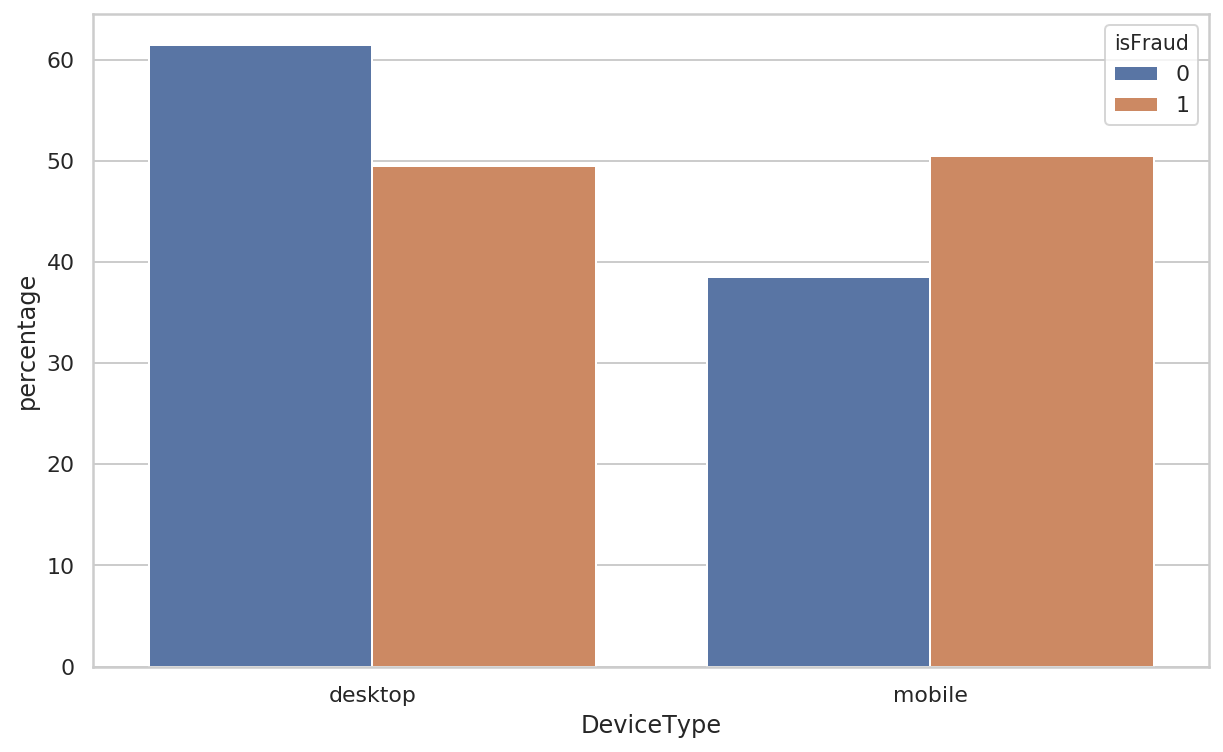

In [35]:
barplot_per_classes(df, 'DeviceType', 'isFraud')

This attribute can be useful in prediction. As we can see, fraudulent payments are more often when device type is mobile.

Next attribute is `DeviceInfo` that more specifies the device (e.g. operating system):

In [36]:
df.DeviceInfo.value_counts()

Windows                          47722
iOS Device                       19782
MacOS                            12573
Trident/7.0                       7440
rv:11.0                           1901
                                 ...  
SM-G900P                             1
SM-G900FD                            1
DUK-AL20                             1
A1-850                               1
SAMSUNG SM-A310M Build/LMY47X        1
Name: DeviceInfo, Length: 1786, dtype: int64

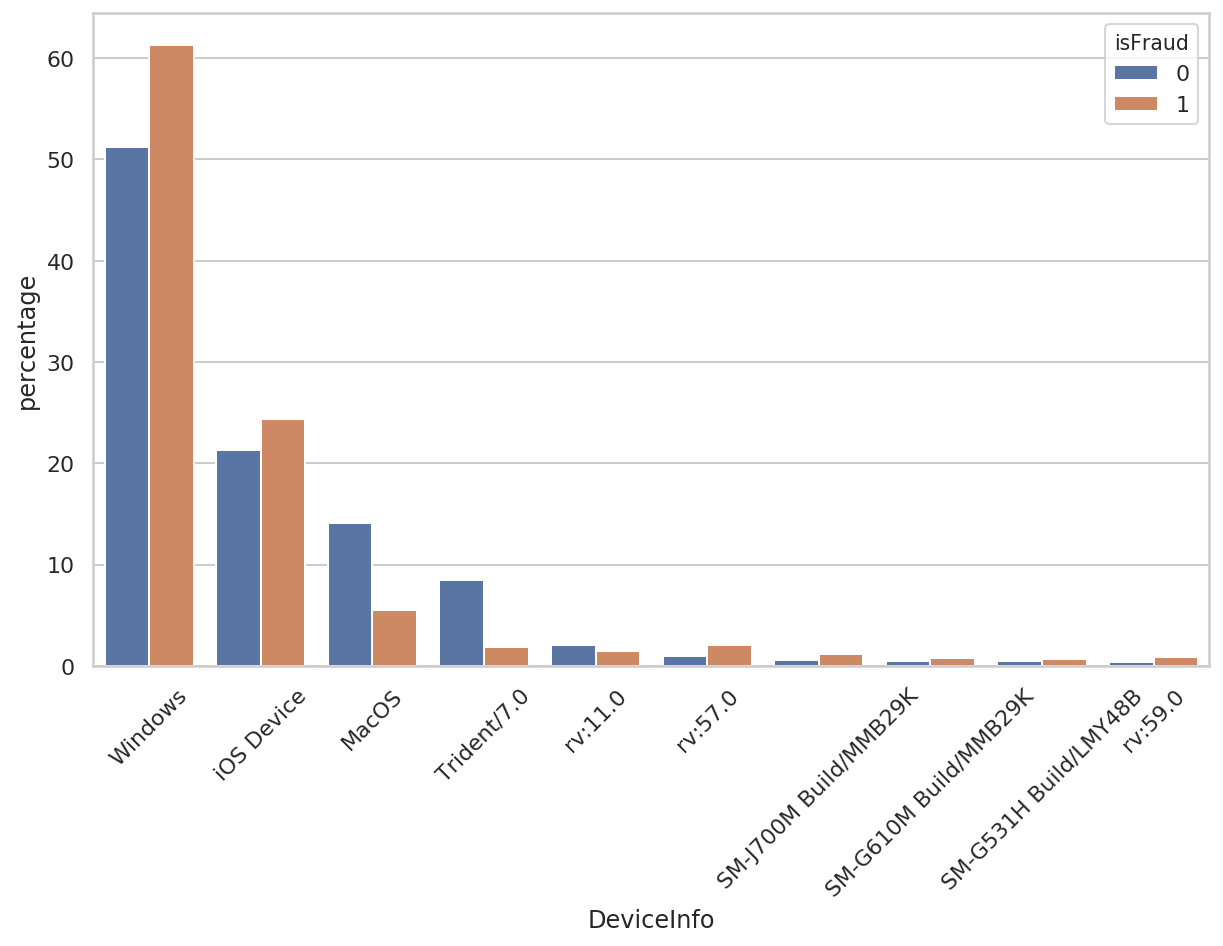

In [37]:
barplot_per_classes(df, 'DeviceInfo', 'isFraud', topn=10, ticks_rotation=45)

Also, this attribute can be useful. Because it contains a lot of unique values (1786), only top 10 or less will be used, other classes should be merged into `other` class.

Next attribute that will be analysed is `id_30`. According to first view at the data, it is probably storing operating system with version.

In [39]:
df.id_30.value_counts()

Windows 10          21155
Windows 7           13110
iOS 11.2.1           3722
iOS 11.1.2           3699
Android 7.0          2871
                    ...  
func                   10
iOS 11.4.0              5
Mac OS X 10_13_5        4
Windows                 3
iOS 11.4.1              1
Name: id_30, Length: 75, dtype: int64

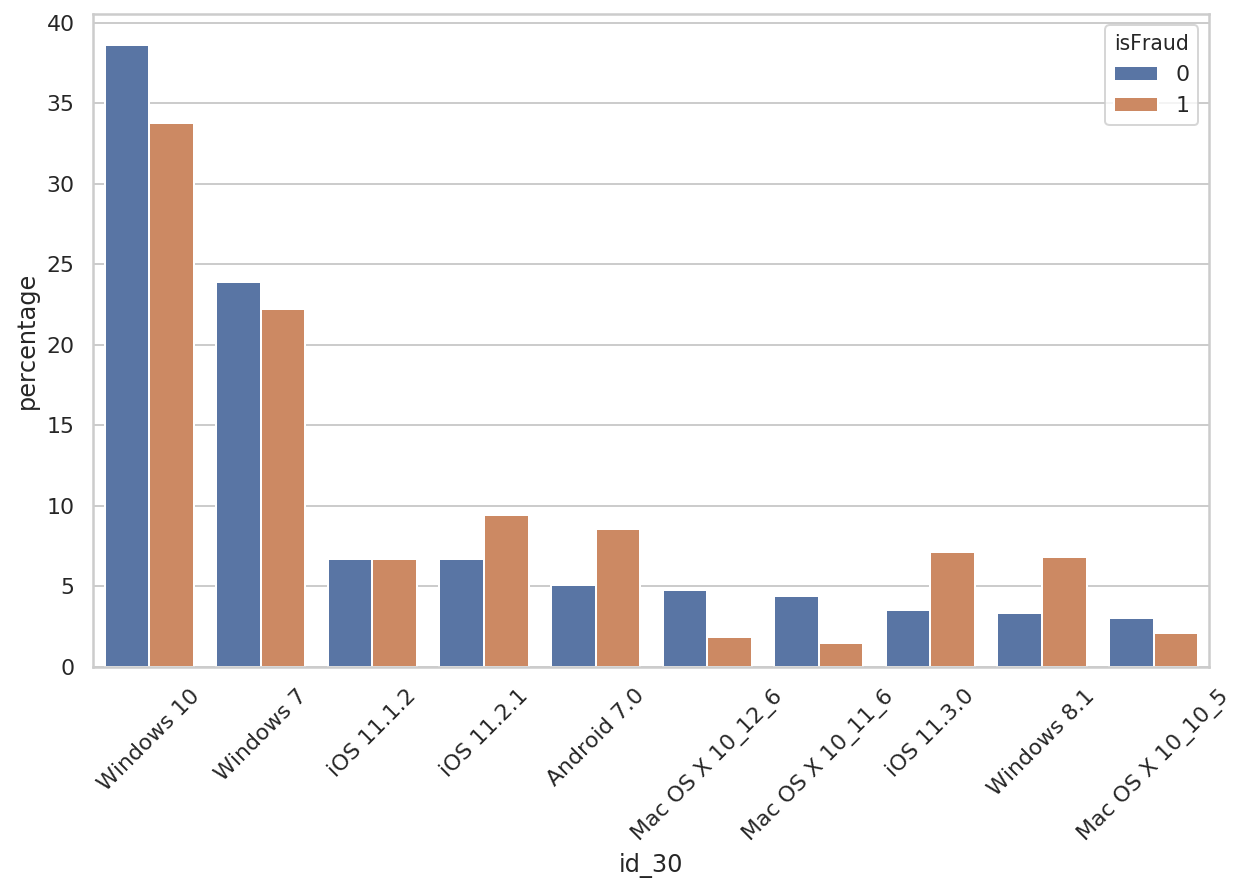

In [43]:
barplot_per_classes(df, 'id_30', 'isFraud', topn=10, ticks_rotation=45)

In this case, we can split this feature into two: `operating system` and `operating system version`.

Let's check `id_31` attribute, that contains the web browser used:

In [45]:
df.id_31.value_counts()

chrome 63.0              22000
mobile safari 11.0       13423
mobile safari generic    11474
ie 11.0 for desktop       9030
safari generic            8195
                         ...  
M4Tel/M4                     1
Samsung/SCH                  1
Cherry                       1
android                      1
firefox mobile 61.0          1
Name: id_31, Length: 130, dtype: int64

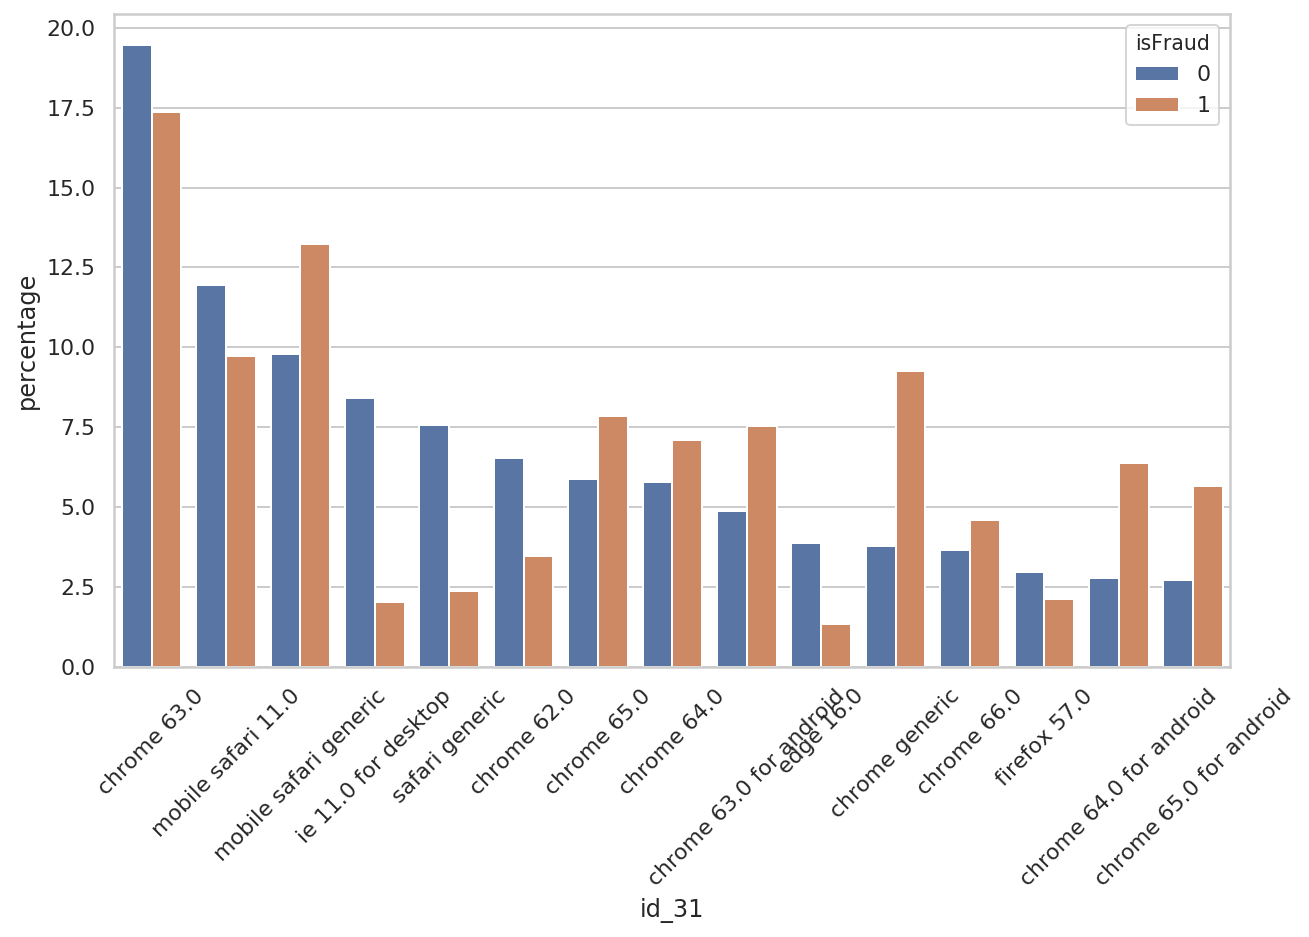

In [46]:
barplot_per_classes(df, 'id_31', 'isFraud', topn=15, ticks_rotation=45)

Again, this attribute can be splitted into `browser type` and `version` to reduce number of classes.

#### Addresses

According to dataset description, two categorical attributes `addr1` and `addr2` are available. We should check them.

In [48]:
df.addr1.value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
462.0        1
128.0        1
481.0        1
120.0        1
340.0        1
Name: addr1, Length: 332, dtype: int64

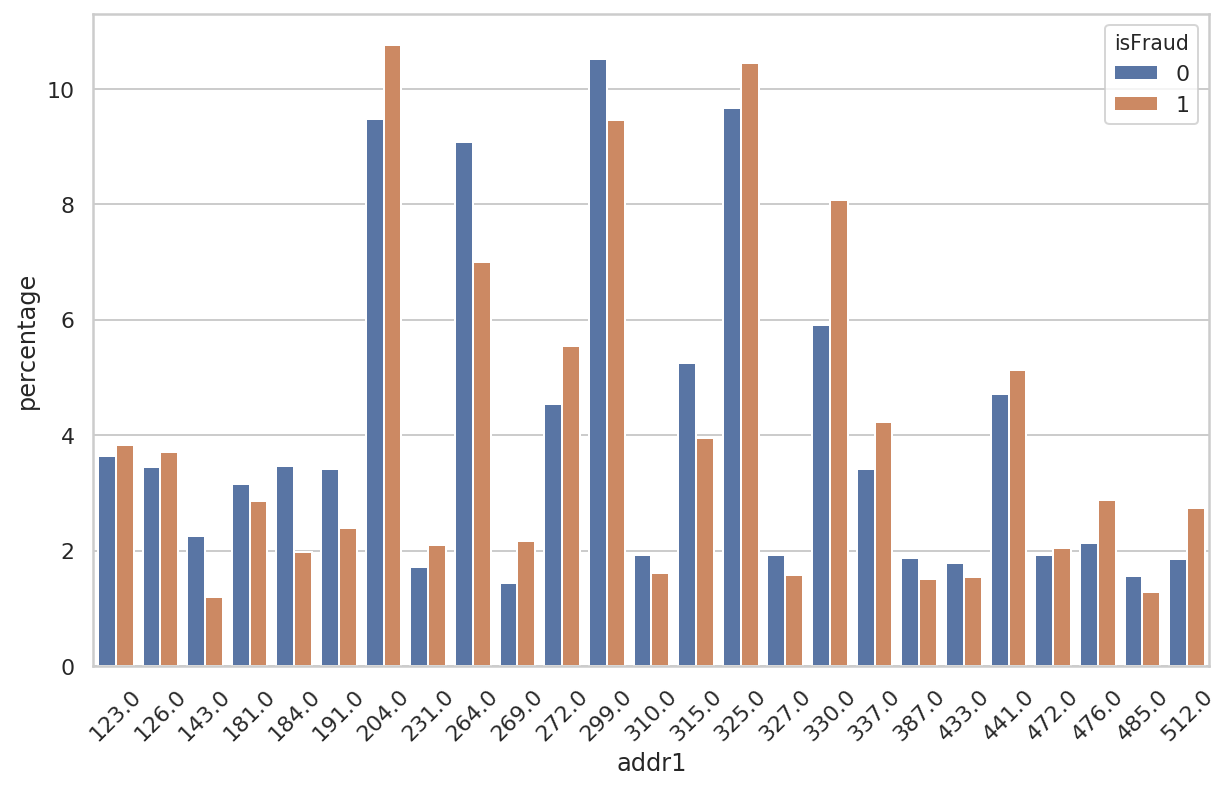

In [51]:
barplot_per_classes(df, 'addr1', 'isFraud', topn=25, ticks_rotation=45)

As we can see, addresses are probably coded into numbers (or something like that). However, this attribute should be considered categorical.

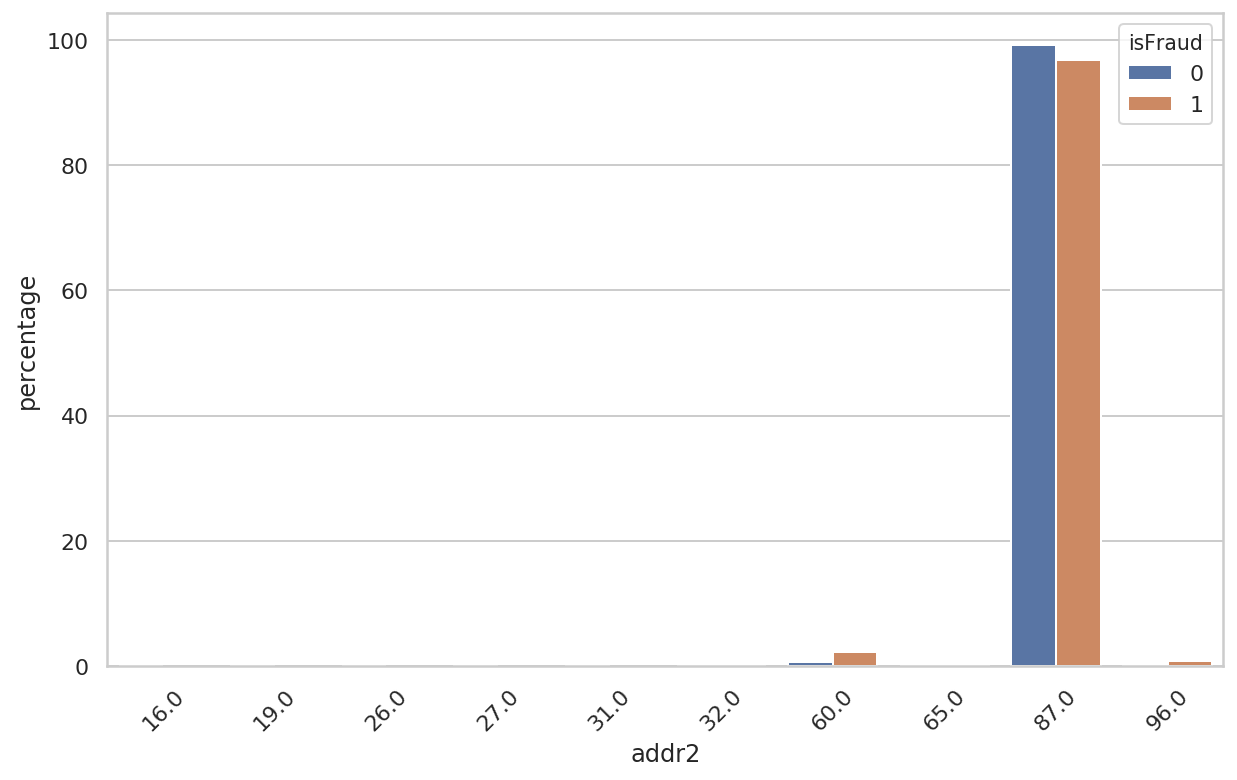

In [53]:
barplot_per_classes(df, 'addr2', 'isFraud', topn=10, ticks_rotation=45)

As we can see, this attribute contains one major value. Thus, it will be better to drop this attribute. There are also distance attributes available:

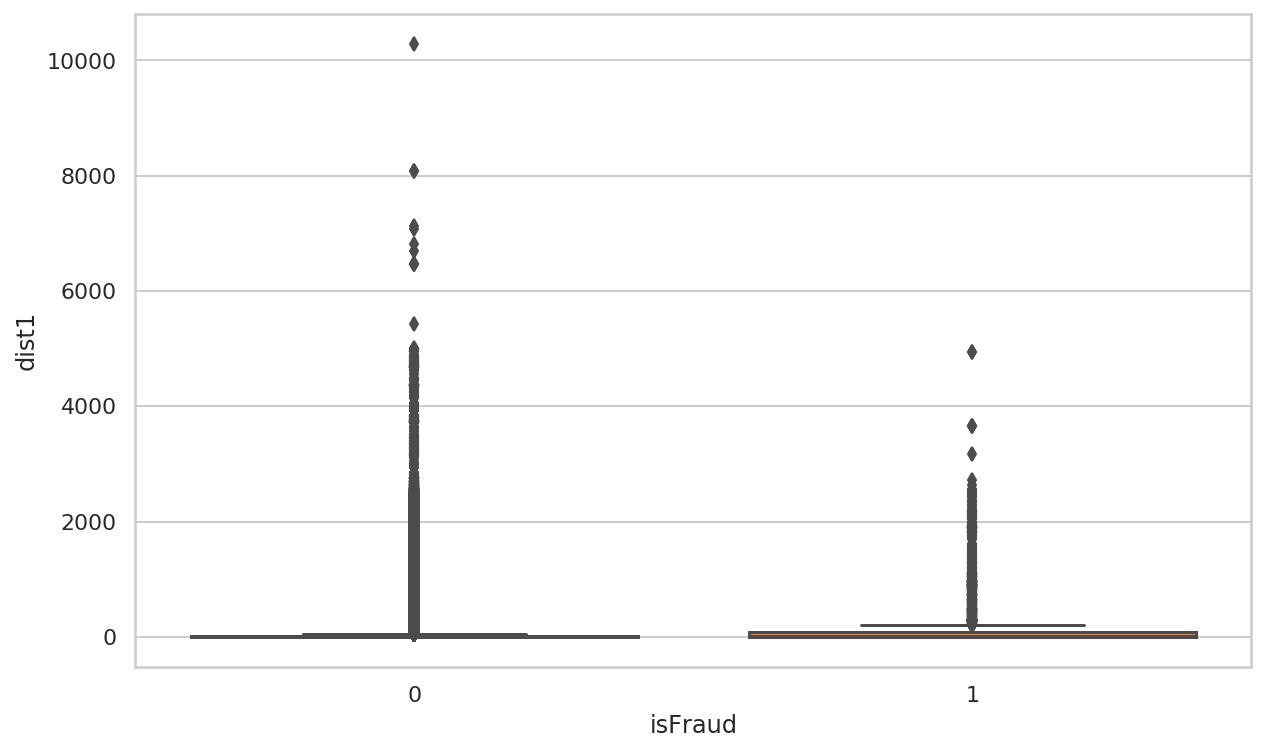

In [73]:
boxplot_per_classes(df, 'dist1', 'isFraud')

Most of values are very small (less than 100), but also outliers are present.

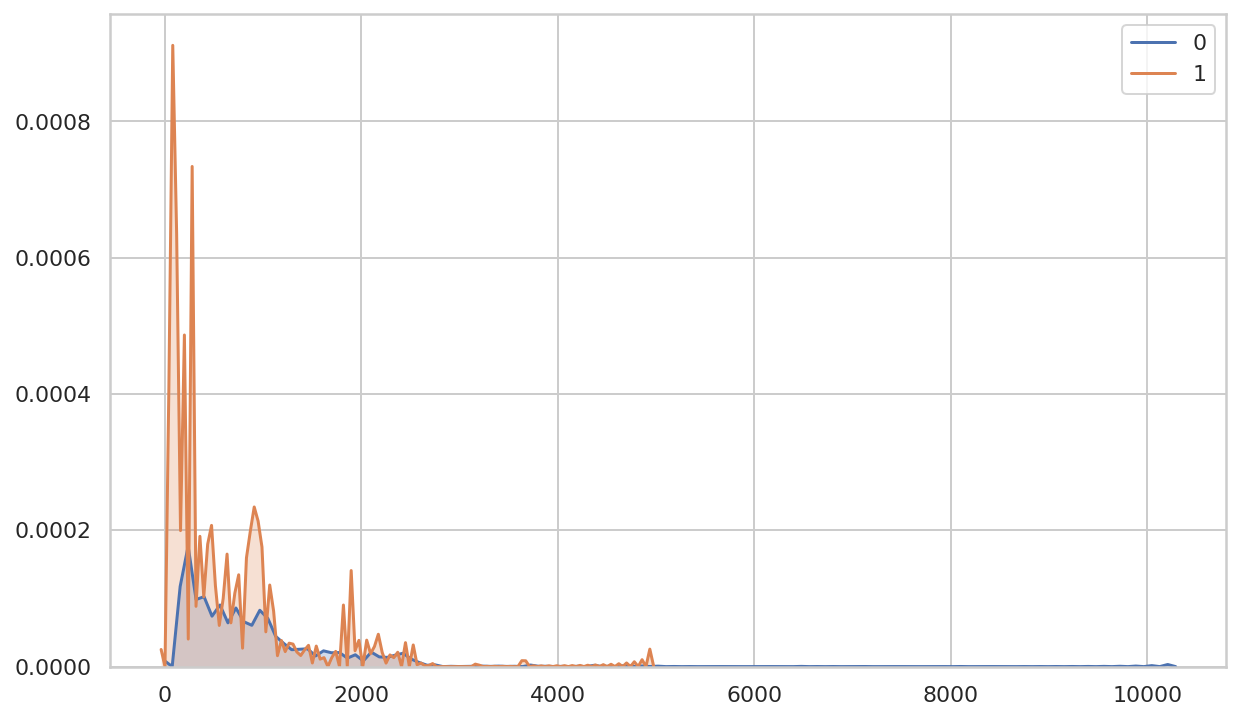

In [87]:
kdeplot_per_classes(df, 'dist1', 'isFraud')

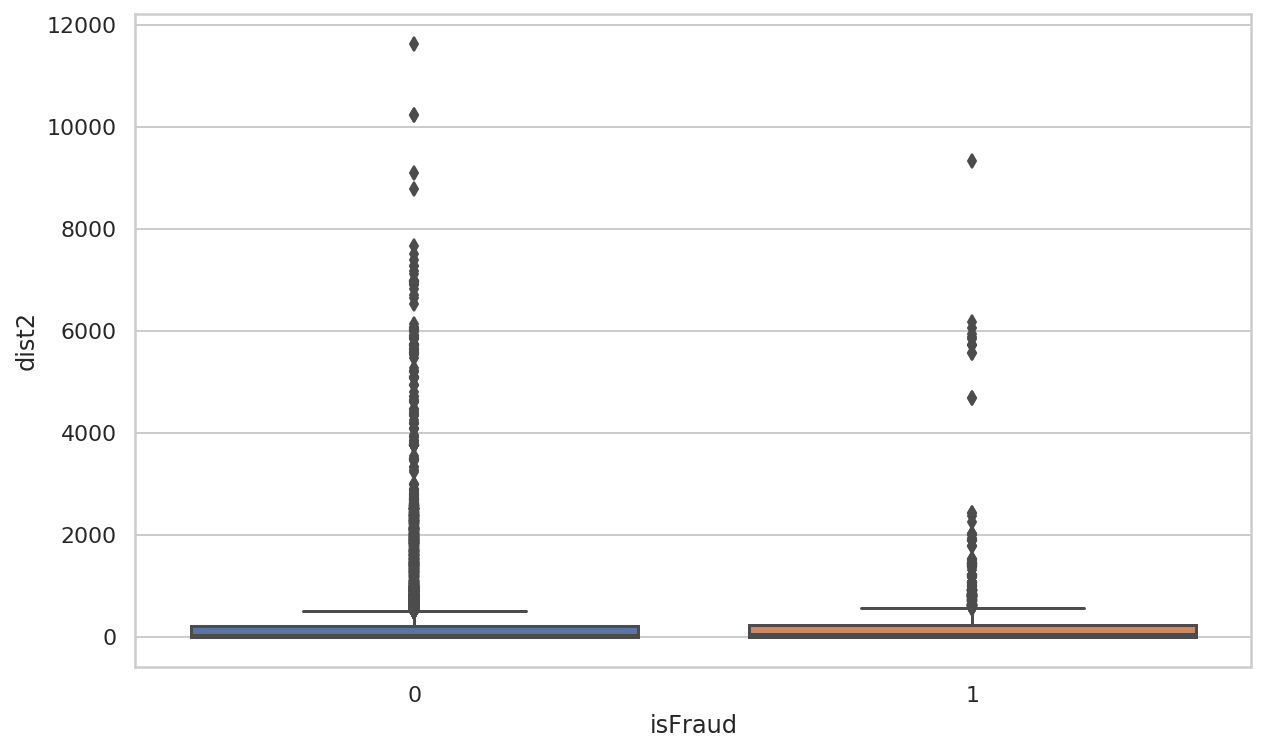

In [74]:
boxplot_per_classes(df, 'dist2', 'isFraud')

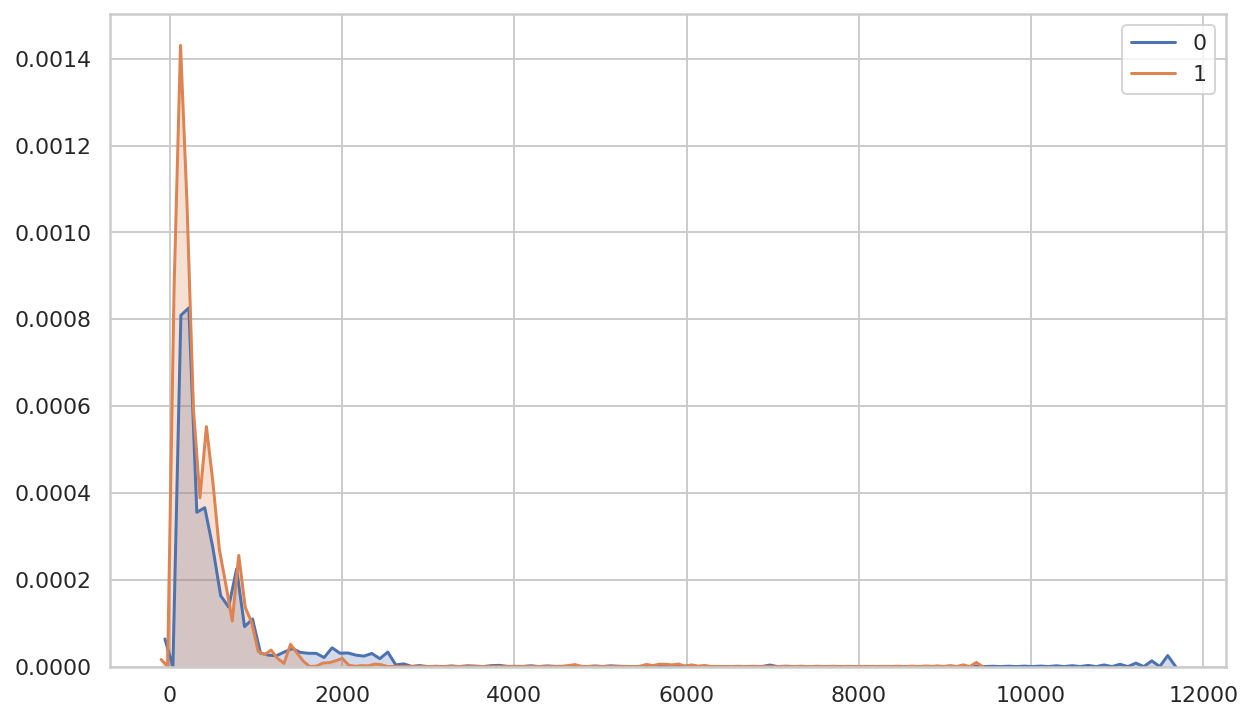

In [88]:
kdeplot_per_classes(df, 'dist2', 'isFraud')

Potentially, there can be difference between fraud and regular payments in case of distances attributes. 

#### D attributes

There are `D` attributes available. Meaning of those attributes is described as follows:
```
D1-D15: timedelta, such as days between previous transaction, etc.
```

Only pairplot will be drawn for those attributes (also kdeplot is shown on diagonal).

In [ ]:
columns = [f'D{i}' for i in range(1, 16)]
sns.pairplot(df, vars=columns, hue='isFraud');

#### C attributes

Meaning of `C` attributes is described as follows:
```
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
```

Only pairplot will be drawn for those attributes (also kdeplot is shown on diagonal).

In [ ]:
columns = [f'C{i}' for i in range(1, 15)]
sns.pairplot(df, vars=columns, hue='isFraud');

#### M attributes

`M` attributes are described as follows:
```
M1-M9: match, such as names on card and address, etc.
```

Those attributes should be treated categorical.

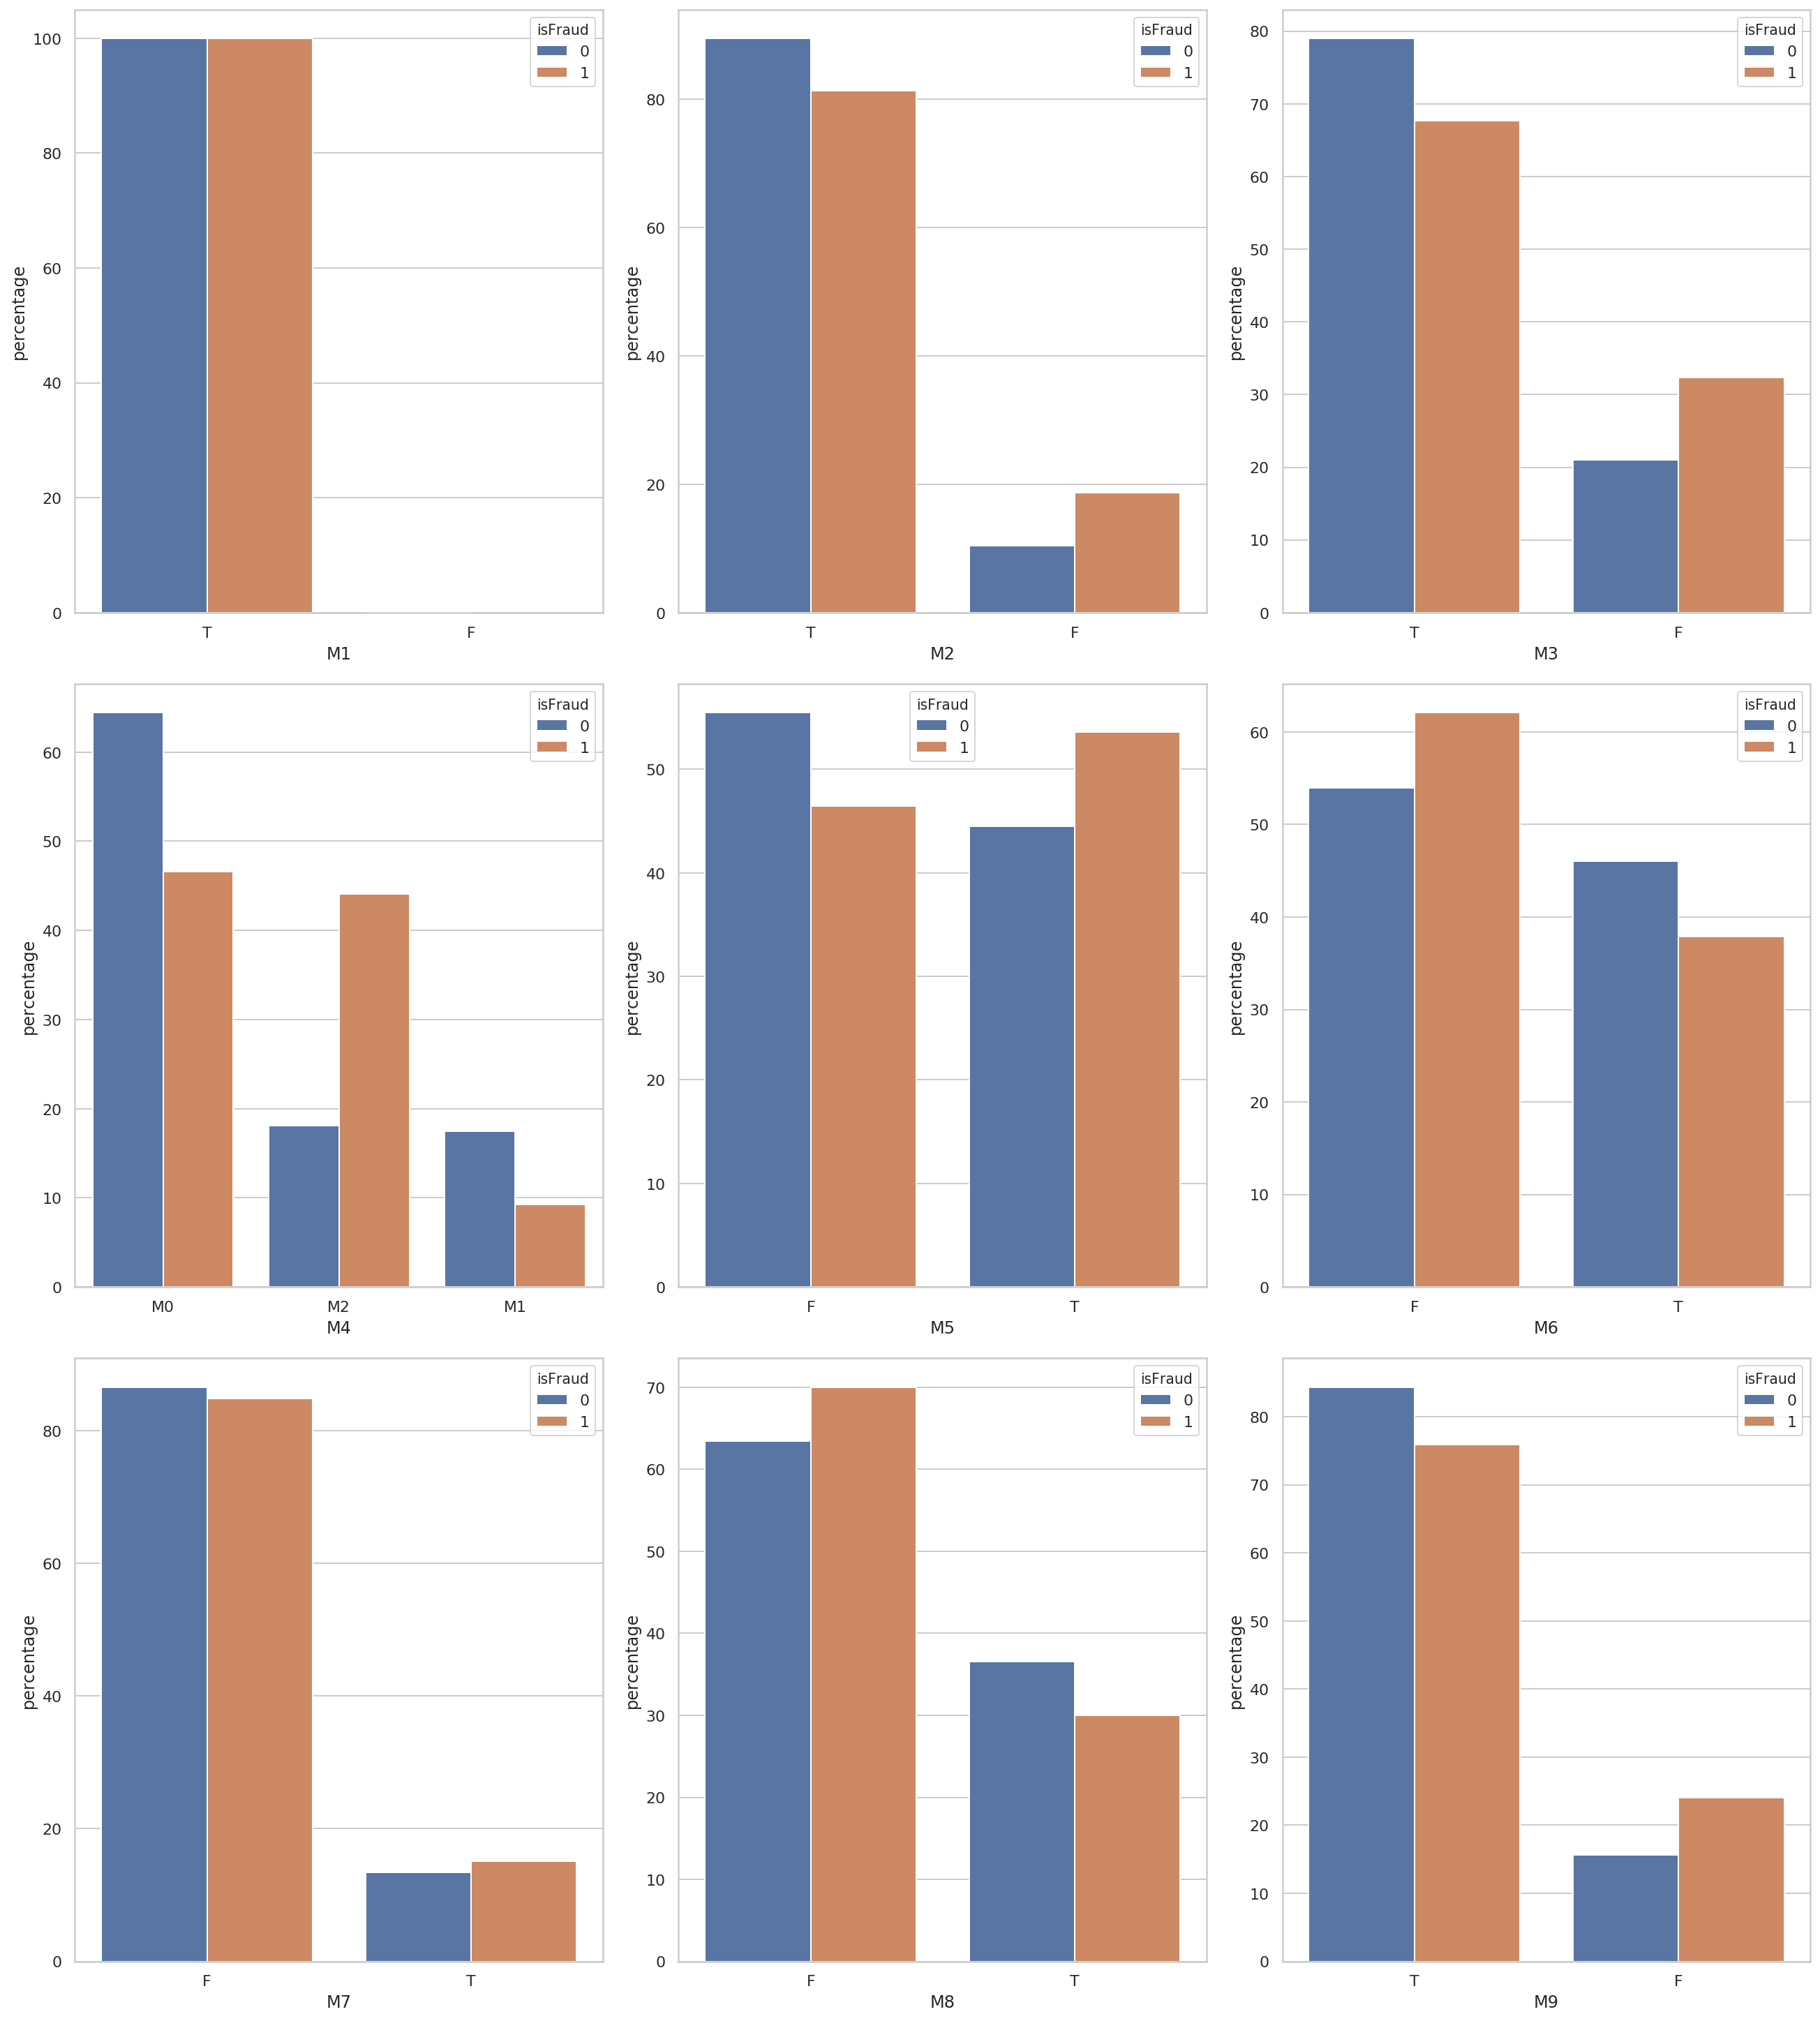

In [99]:
columns = [f'M{i}' for i in range(1, 10)]
fig, axs = plt.subplots(nrows=3, ncols=3, constrained_layout=True)
fig.set_size_inches(18, 20)
for y in range(3):
    for x in range(3):
        barplot_per_classes(df, columns[x + 3 * y], 'isFraud', ax=axs[y][x])

As we can see, there is very interesting attribute `M4` with very significant differences between predicted classes. Plots also shown that attribute `M1` will be probably useless in prediction phase.

#### Vxxx features

In the data, there are also attributes starting with `V` (`V1`, `V2`, ..., `V339`). Those attributes are engineered rich features according to dataset description:
```
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
```

In discussion section, we have found also better description:
```
“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking)."
```

All those features are considered numerical, so we will treat them like that.

### Conclusion

In this jupyter notebook, we have looked at the data and checked characteristics of attributes. During data analysis, we have found some problems with data (a lot of missing values, incorrect data types, imbalanced classes) that have to be figured out in preprocessing phase. The data analysis also gave us a picture about what attributes are available, of what data types are those attributes,  and which and how can be potentially used for prediction.